<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Solvay/Solvay_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SOLB.BR"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  50.98  51.94  50.60  51.29      34.22  225239
2009-01-05  52.12  53.09  51.94  52.80      35.23  296135
2009-01-06  53.28  54.60  51.93  54.28      36.22  450629
2009-01-07  54.51  55.09  54.05  54.74      36.53  339611
2009-01-08  54.20  55.09  53.71  54.37      36.28  246961
...           ...    ...    ...    ...        ...     ...
2018-12-21  86.60  87.84  86.04  87.84      84.19  376637
2018-12-24  86.68  87.70  86.68  86.68      83.08   59134
2018-12-27  88.50  89.20  85.44  86.18      82.60  229353
2018-12-28  87.00  87.90  86.62  87.24      83.61  127804
2018-12-31  88.14  88.14  87.02  87.32      83.69   52503

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     93.364765    94.264742    92.363294    93.322195    78.254002  2.714804e+05
std      20.571862    20.590779    20.589242    20.597084    22.959019  1.621162e+05
min      39.530000    39.850000    38.810000    39.480000    26.970000  7.063000e+03
25%      73.885000    74.592500    73.055000    73.897500    55.420000  1.785362e+05
50%      97.990000    98.970000    96.950000    98.005000    81.680000  2.357230e+05
75%     110.620000   111.427500   109.612500   110.670000    97.097500  3.145498e+05
max     132.380000   132.610000   130.870000   132.470000   122.000000  2.193711e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  39.84  40.10  39.57  39.69      27.12  386665   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  40.147247  42.934428 -41.020000  39.367810  40.384098  40.362938      40.170      39.915  43.266208  40.06750  39.922191  40.0855  40.053611  40.06750  40.130000  42.971055               41.012950                 40.06750               39.122050               41.485674                 40.06750               38.649326               41.958399                 40.06750               38.176601               42.431124                 40.06750               37.703876  40.384098  39.933159  42.402987               41.329547                40.384098               39.438648               41.802272                40.384098               38.965923               42.274997                40.384098               38.493199               42.747722                40.384098   
2009-03-16  39.92  40.23  39.47  40.04      27.36  324504   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  40.138620  42.821978 -40.580000  39.457712  40.307632  40.357272      40.170      39.915  42.909711  40.01250  40.018294  40.1300  40.047500  40.01250  39.865000  42.568054               40.905291                 40.01250               39.119709               41.351686                 40.01250               38.673314               41.798081                 40.01250               38.226919               42.244476                 40.01250               37.780524  40.307632  39.970536  42.034759               41.200422                40.307632               39.414841               41.646817                40.307632               38.968446               42.093213                40.307632               38.522051               42.539608                40.307632   
2009-03-17  40.41  42.39  40.07  41.56      28.39

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     94.250563    95.157302    93.249800    94.213771    79.155351  2.703826e+05    15.774142     1.998404   186.245810      30.462889      0.032721        0.027933        0.009976          0.007981     6.625698     2.540702    27.029928     1.998404      2.012769    27.029928    94.181390    94.102384     3.213135    94.213802    94.148047    94.184604    94.145780    94.101355    93.956568    94.148186    94.214088    94.148337    94.170121    94.148186    94.189819    94.016821               97.118363                94.148186               91.178009               98.603451                94.148186               89.692920              100.088540                94.148186               88.207832              101.573628                94.148186               86.722743    94.148047    94.197013    94.036347               97.118224                94.148047               91.177870               98.603312                94.148047               89.692781              100.088400   
std      19.774543    19.778908    19.791238    19.787572    22.268145  1.623122e+05     8.732031     1.408556   103.650851       0.785865      0.177942        0.164814        0.099401          0.088996     3.396541     1.106387    14.824654     1.408556      1.412461    14.824654    19.884139    19.902649    96.058737    19.821593    19.779848    19.789514    19.808388    19.794002    20.098304    19.816262    19.800526    19.831711    19.793767    19.816262    19.788554    19.871025               19.872935                19.816262               19.893630               19.951285                19.816262               19.982198               20.062513                19.816262               20.103492               20.206074                19.816262               20.256922    19.779848    19.778803    19.865336               19.833357                19.779848               19.860621               19.910236                19.779848               19.950960               20.020073   
min      39.840000    40.100000    39.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.000000  0.000000  0.001094  0.000000   0.000000  386665   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000096  0.007789  0.353617  0.000000  0.000853  0.000064    0.000000    0.000000  0.047508  0.000611  0.000000  0.000000  0.000067  0.000611  0.002880  0.014951                0.001158                 0.000611                0.012822                0.001390                 0.000611                0.030097                0.001607                 0.000611                0.047175                0.001809                 0.000611                0.082196  0.000853  0.000000  0.011947                0.001396                 0.000853                0.007902                0.001645                 0.000853                0.025423                0.001857                 0.000853                0.042464                0.002054                 0.000853   
2009-03-16  0.000864  0.001405  0.000000  0.003772   0.002530  324504   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000000  0.006486  0.355316  0.000976  0.000000  0.000000    0.000000    0.000000  0.043707  0.000000  0.001048  0.000492  0.000000  0.000000  0.000000  0.010299                0.000000                 0.000000                0.012796                0.000000                 0.000000                0.030365                0.000000                 0.000000                0.047734                0.000000                 0.000000                0.083018  0.000000  0.000409  0.007721                0.000000                 0.000000                0.007631                0.000000                 0.000000                0.025452                0.000000                 0.000000                0.042786                0.000000                 0.000000   
2009-03-17  0.006159  0.024754  0.006565  0.020155   0.0

139898

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 26 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_h6qm0m
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.707438  0.713942              0.308423  0.479760  0.230170
1  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.705022  0.726703              0.312556  0.485041  0.235264
2  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.693897  0.665266              0.313128  0.470424  0.221298
3  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.692308  0.693053              0.321678  0.483629  0.233897
4  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.679021  0.683004              0.342467  0.482695  0.232995
5  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.676542  1.265607              0.346313  0.573786  0.329231
6  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.663795  0.728454              0.382772  0.494155  0.244189
7              DeepLearning_1_AutoML_20190825_143935  0.659695  0.926710              0.389034  0.555954  0.309085
8  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.644374  4.098638              0.394310  0.650729  0.423448
9  DeepLearning_grid_1_AutoML_20190825_143935_mod...  0.582041  0.770285              0.454704  0.532358  0.283405

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.007007
1                          SUB             0.531535           0.531535    0.003724
2                  CDLLONGLINE             0.481631           0.481631    0.003375
3                       TRANGE             0.464563           0.464563    0.003255
4                 STOCHF_fastk             0.418740           0.418740    0.002934
...                        ...                  ...                ...         ...
1034  BBANDS_middleband_14_1_4             0.107007           0.107007    0.000750
1035   BBANDS_upperband_14_2_5             0.106998           0.106998    0.000750
1036   BBANDS_upperband_20_6_2             0.106714           0.106714    0.000748
1037                   DEMA_20             0.105647           0.105647    0.000740
1038    BBANDS_upperband_8_8_2             0.105244           0.105244    0.000737

[1039 rows x 4 columns]

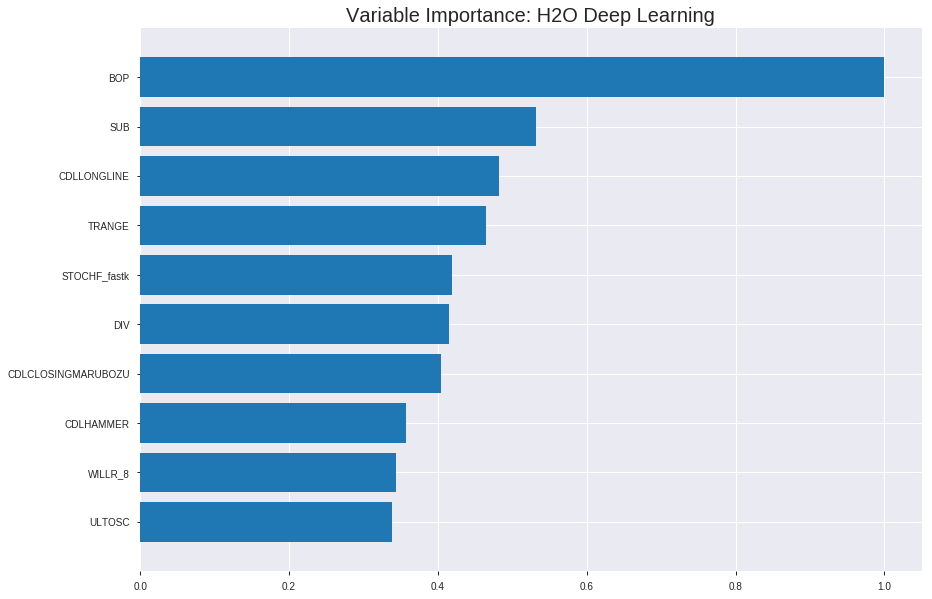

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_143935_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21885390581794925
RMSE: 0.4678182401509685
LogLoss: 0.6429606029983495
Mean Per-Class Error: 0.32200515578007205
AUC: 0.7434810629239522
pr_auc: 0.7323196536031322
Gini: 0.48696212584790444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21134223961160428: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      401  462   0.5353   (462.0/863.0)
1      113  777   0.127    (113.0/890.0)
Total  514  1239  0.328    (575.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211342     0.72992   302
max f2                       0.0629271    0.850732  366
max f0point5                 0.428235     0.680966  214
max accuracy                 0.316773     0.679407  258
max precision                0.981675     1         0
max recall                   0.000682876  1         399
max specificity              0.981675     1         0
max absolute_mcc             0.214892     0.371845  300
max min_per_class_accuracy   0.405545     0.669757  222
max mean_per_class_accuracy  0.316773     0.677995  258

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 43.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.967293           1.96966   1.96966            1                0.975175   1                           0.975175            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.955878           1.86024   1.91495            0.944444         0.960207   0.972222                    0.967691            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.937866           1.73794   1.85817            0.882353         0.946182   0.943396                    0.960792            0.0168539       0.0561798                  73.7938   85.8173
    4        0.040502                    0.928925           1.42253   1.74773            0.722222         0.934173   0.887324                    0.954044            0.0146067       0.0707865                  42.2534   74.7729
    5        0.0501997                   0.920305           1.62208   1.72346            0.823529         0.92539    0.875                       0.948508            0.0157303       0.0865169                  62.2075   72.3455
    6        0.100399                    0.852779           1.58916   1.65631            0.806818         0.88724    0.840909                    0.917874            0.0797753       0.166292                   58.916    65.6307
    7        0.150029                    0.78514            1.53951   1.61767            0.781609         0.81669    0.821293                    0.884403            0.0764045       0.242697                   53.9507   61.767
    8        0.200228                    0.728624           1.34295   1.54879            0.681818         0.755466   0.786325                    0.852077            0.0674157       0.310112                   34.2952   54.8795
    9        0.300057                    0.61381            1.32812   1.47537            0.674286         0.66852    0.749049                    0.791008            0.132584        0.442697                   32.8116   47.5375
    10       0.399886                    0.506929           1.15929   1.39647            0.588571         0.559174   0.708987                    0.733132            0.11573         0.558427                   15.9287   39.6466
    11       0.500285                    0.407616           1.09674   1.33632            0.556818         0.456179   0.678449                    0.677552            0.110112        0.668539                   9.67441   33.6316
    12       0.600114                    0.309783           1.03548   1.28627            0.525714         0.357319   0.653042                    0.624281            0.103371        0.77191                    3.54799   28.6272
    13       0.699943                    0.215118           0.945438  1.23766            0.48             0.258616   0.628362                    0.572129            0.094382        0.866292                   -5.45618  23.7661
    14       0.799772                    0.138278           0.641547  1.16325            0.325714         0.177164   0.590585                    0.522828            0.0640449       0.930337                   -35.8453  16.3253
    15       0.899601                    0.0558487          0.51774   1.09162            0.262857         0.0968614  0.554217                    0.475559            0.0516854       0.982022                   -48.226   9.16204
    16       1                           5.45943e-05        0.17906   1                  0.0909091        0.0254545  0.507701                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2358186999997563
RMSE: 0.48561167613614514
LogLoss: 0.6943759903524087
Mean Per-Class Error: 0.34172713845363467
AUC: 0.6949332134600564
pr_auc: 0.7064040222586031
Gini: 0.38986642692011286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1911118811623602: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   159  0.6943   (159.0/229.0)
1      22   250  0.0809   (22.0/272.0)
Total  92   409  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.191112     0.734214  324
max f2                       0.0442971    0.859525  375
max f0point5                 0.491938     0.687322  218
max accuracy                 0.491938     0.662675  218
max precision                0.98965      1         0
max recall                   0.0126576    1         395
max specificity              0.98965      1         0
max absolute_mcc             0.491938     0.318066  218
max min_per_class_accuracy   0.537021     0.646288  199
max mean_per_class_accuracy  0.491938     0.658273  218

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.979732           1.84191   1.84191            1                0.985087   1                           0.985087            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.969214           1.84191   1.84191            1                0.973218   1                           0.979692            0.0183824       0.0404412                  84.1912   84.1912
    3        0.0319361                   0.963361           0.736765  1.49655            0.4              0.965916   0.8125                      0.975387            0.00735294      0.0477941                  -26.3235  49.6553
    4        0.0419162                   0.94779            1.84191   1.57878            1                0.957023   0.857143                    0.971014            0.0183824       0.0661765                  84.1912   57.8782
    5        0.0518962                   0.941756           1.84191   1.62938            1                0.943454   0.884615                    0.965714            0.0183824       0.0845588                  84.1912   62.9383
    6        0.101796                    0.909056           1.10515   1.3724             0.6              0.925799   0.745098                    0.946148            0.0551471       0.139706                   10.5147   37.2405
    7        0.151697                    0.86162            1.2525    1.33296            0.68             0.878824   0.723684                    0.924002            0.0625          0.202206                   25.25     33.2962
    8        0.201597                    0.818208           1.47353   1.36776            0.8              0.838369   0.742574                    0.902806            0.0735294       0.275735                   47.3529   36.7756
    9        0.301397                    0.741073           1.17882   1.3052             0.64             0.781149   0.708609                    0.862522            0.117647        0.393382                   17.8824   30.5196
    10       0.401198                    0.647075           1.36301   1.31958            0.74             0.689215   0.716418                    0.819411            0.136029        0.529412                   36.3015   31.9579
    11       0.500998                    0.544109           1.03147   1.26219            0.56             0.599103   0.685259                    0.775525            0.102941        0.632353                   3.14706   26.2187
    12       0.600798                    0.449878           1.03147   1.22386            0.56             0.501789   0.664452                    0.730054            0.102941        0.735294                   3.14706   22.3862
    13       0.700599                    0.334968           0.773603  1.15972            0.42             0.394936   0.62963                     0.682316            0.0772059       0.8125                     -22.6397  15.9722
    14       0.800399                    0.204404           0.920956  1.12995            0.5              0.2519     0.613466                    0.628648            0.0919118       0.904412                   -7.90441  12.9951
    15       0.9002                      0.0884787          0.62625   1.07411            0.34             0.150929   0.583149                    0.575686            0.0625          0.966912                   -37.375   7.41082
    16       1                           0.00129705         0.331544  1                  0.18             0.0413629  0.542914                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:41:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:41:06  1 min 28.511 sec  395 obs/sec       0.601825  1             1055       0.661421         9.42131             -0.750326      0.57096         0.327458           1.3563           0.492299                         0.695135           11.1234               -0.947193        0.552             0.544627             0.613971           0.457086
    2019-08-25 14:41:21  1 min 43.611 sec  395 obs/sec       3.70051   6             6487       0.461469         0.61754             0.147984       0.731426        0.72125            1.86024          0.335995                         0.488402           0.697825              0.038773         0.677562          0.663639             1.22794            0.359281
    2019-08-25 14:41:35  1 min 57.589 sec  411 obs/sec       6.80034   11            11921      0.508464         0.743945            -0.0343882     0.656237        0.649228           1.64139          0.412436                         0.514388           0.812888              -0.0662342       0.653168          0.658904             1.53493            0.393214
    2019-08-25 14:41:51  2 min 13.383 sec  426 obs/sec       10.5619   17            18515      0.476893         0.690175            0.090076       0.738664        0.728944           1.86024          0.361095                         0.560212           0.981824              -0.264667        0.652614          0.677113             1.53493            0.377246
    2019-08-25 14:42:06  2 min 28.769 sec  436 obs/sec       14.3217   23            25106      0.458058         0.62233             0.160531       0.760427        0.739206           1.64139          0.340559                         0.484588           0.712472              0.0537263        0.711983          0.708378             1.22794            0.351297
    2019-08-25 14:42:21  2 min 43.788 sec  445 obs/sec       18.0719   29            31680      0.477294         0.683773            0.0885443      0.743883        0.739375           1.96966          0.333143                         0.50461            0.751349              -0.026082        0.684458          0.701194             1.84191            0.371257
    2019-08-25 14:42:36  2 min 58.536 sec  452 obs/sec       21.81     35            38233      0.467818         0.642961            0.124377       0.743481        0.73232            1.96966          0.328009                         0.485612           0.694376              0.049725         0.694933          0.706404             1.84191            0.361277
    2019-08-25 14:42:50  3 min 12.743 sec  459 obs/sec       25.5111   41            44721      0.446717         0.59249             0.201585       0.775201        0.764228           1.96966          0.300627                         0.48723            0.701923              0.0433823        0.696057          0.722141             1.84191            0.363273
    2019-08-25 14:43:04

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.007006808461264473
SUB                       0.5315352082252502     0.5315352082252502   0.0037243653944526566
CDLLONGLINE               0.48163092136383057    0.48163092136383057  0.003374695615018692
TRANGE                    0.4645627439022064     0.4645627439022064   0.00325510216476222
STOCHF_fastk              0.4187402129173279     0.4187402129173279   0.00293403246694082
---                       ---                    ---                  ---
BBANDS_middleband_14_1_4  0.1070072203874588     0.1070072203874588   0.0007497790972272385
BBANDS_upperband_14_2_5   0.10699761658906937    0.10699761658906937  0.0007497118052514232
BBANDS_upperband_20_6_2   0.10671427100896835    0.10671427100896835  0.0007477264570433094
DEMA_20                   0.10564671456813812    0.10564671456813812  0.0007402462935408228
BBANDS_upperband_8_8_2    0.1052444577217102     0.1052444577217102   0.0007374277568656701


See the whole table with table.as_data_frame()


('accuracy', 0.6852589641434262)

('F1', 0.726643598615917)

('auc', 0.7074380165289256)

('logloss', 0.7139424195982453)

('mean_per_class_error', 0.3084233947870312)

('rmse', 0.4797601187499056)

('mse', 0.2301697715429235)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


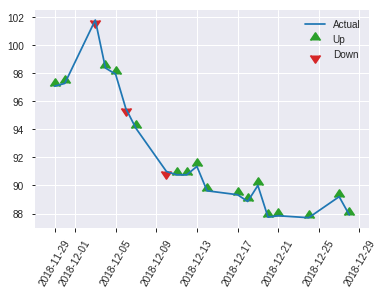


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2301697715429235
RMSE: 0.4797601187499056
LogLoss: 0.7139424195982453
Mean Per-Class Error: 0.3084233947870312
AUC: 0.7074380165289256
pr_auc: 0.6387416226754404
Gini: 0.41487603305785115
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40393989788120893: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   63   0.4846   (63.0/130.0)
1      16   105  0.1322   (16.0/121.0)
Total  83   168  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40394      0.726644  167
max f2                       0.110541     0.841655  216
max f0point5                 0.431276     0.663601  159
max accuracy                 0.431276     0.685259  159
max precision                0.977961     1         0
max recall                   7.01926e-06  1         250
max specificity              0.977961     1         0
max absolute_mcc             0.40394      0.406952  167
max min_per_class_accuracy   0.581858     0.652893  123
max mean_per_class_accuracy  0.40394      0.691577  167

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 53.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.966997           2.07438   2.07438            1                0.973766   1                           0.973766            0.0247934       0.0247934                  107.438   107.438
    2        0.0239044                   0.9548             1.38292   1.72865            0.666667         0.958502   0.833333                    0.966134            0.0165289       0.0413223                  38.292    72.865
    3        0.0318725                   0.949743           0         1.29649            0                0.952196   0.625                       0.962649            0               0.0413223                  -100      29.6488
    4        0.0438247                   0.936901           1.38292   1.32006            0.666667         0.94183    0.636364                    0.956971            0.0165289       0.0578512                  38.292    32.006
    5        0.0517928                   0.929968           1.03719   1.27654            0.5              0.933104   0.615385                    0.953299            0.00826446      0.0661157                  3.71901   27.6542
    6        0.103586                    0.909681           1.43611   1.35633            0.692308         0.920287   0.653846                    0.936793            0.0743802       0.140496                   43.6109   35.6325
    7        0.151394                    0.873161           1.38292   1.36472            0.666667         0.895872   0.657895                    0.923871            0.0661157       0.206612                   38.292    36.4724
    8        0.203187                    0.836748           1.43611   1.38292            0.692308         0.852425   0.666667                    0.905659            0.0743802       0.280992                   43.6109   38.292
    9        0.302789                    0.751442           1.24463   1.33743            0.6              0.794748   0.644737                    0.869175            0.123967        0.404959                   24.4628   33.7429
    10       0.40239                     0.669946           1.3276    1.335              0.64             0.708766   0.643564                    0.82947             0.132231        0.53719                    32.7603   33.4997
    11       0.501992                    0.577766           1.24463   1.31707            0.6              0.618718   0.634921                    0.787654            0.123967        0.661157                   24.4628   31.7067
    12       0.601594                    0.492825           1.16165   1.29134            0.56             0.532217   0.622517                    0.745363            0.115702        0.77686                    16.1653   29.1336
    13       0.701195                    0.360125           1.07868   1.26113            0.52             0.420868   0.607955                    0.69927             0.107438        0.884298                   7.86777   26.1129
    14       0.800797                    0.165934           0.414876  1.15587            0.2              0.24029    0.557214                    0.642183            0.0413223       0.92562                    -58.5124  15.5874
    15       0.900398                    0.0860524          0.497851  1.08308            0.24             0.123414   0.522124                    0.584797            0.0495868       0.975207                   -50.2149  8.30834
    16       1                           7.01926e-06        0.248926  1                  0.12             0.0347603  0.482072                    0.

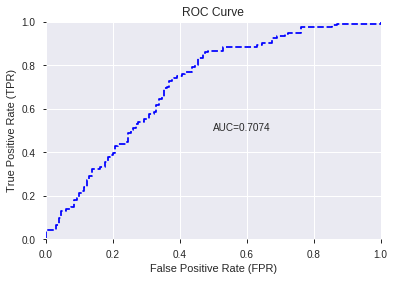

This function is available for GLM models only


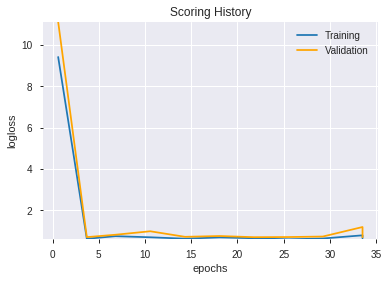

--2019-08-25 15:14:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_143935_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_143935_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_151434_model_8  0.708137  0.600110              0.333058  0.457853  0.209629
1  DeepLearning_grid_1_AutoML_20190825_151434_model_9  0.701844  0.626495              0.304577  0.467899  0.218929
2  DeepLearning_grid_1_AutoML_20190825_151434_model_5  0.700572  0.627641              0.322378  0.468154  0.219168
3  DeepLearning_grid_1_AutoML_20190825_151434_model_7  0.697457  0.702111              0.337190  0.484946  0.235173
4  DeepLearning_grid_1_AutoML_20190825_151434_model_6  0.697107  0.617342              0.316402  0.465111  0.216328
5  DeepLearning_grid_1_AutoML_20190825_151434_model_3  0.692435  0.693132              0.349015  0.483696  0.233962
6  DeepLearning_grid_1_AutoML_20190825_151434_model_4  0.691036  0.824149              0.311983  0.509100  0.259182
7               DeepLearning_1_AutoML_20190825_151434  0.679720  0.661022              0.316116  0.483340  0.233618
8  DeepLearning_grid_1_AutoML_20190825_151434_model_2  0.675842  0.756837              0.393452  0.510002  0.260102
9  DeepLearning_grid_1_AutoML_20190825_151434_model_1  0.673872  0.876127              0.378640  0.517833  0.268151

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.036348
1                   SUB             0.710086           0.710086    0.025811
2    CDLCLOSINGMARUBOZU             0.693911           0.693911    0.025223
3                TRANGE             0.649777           0.649777    0.023618
4                   SIN             0.631953           0.631953    0.022971
5           CDLLONGLINE             0.628030           0.628030    0.022828
6        STOCHRSI_fastd             0.619589           0.619589    0.022521
7             CDLHAMMER             0.608228           0.608228    0.022108
8          STOCHF_fastk             0.601627           0.601627    0.021868
9             CORREL_30             0.600522           0.600522    0.021828
10               ULTOSC             0.593727           0.593727    0.021581
11         weekday_name             0.582512           0.582512    0.021173
12         aroondown_24             0.578646           0.578646    0.021033
13         HT_TRENDMODE             0.575833           0.575833    0.020931
14             WILLR_12             0.562685           0.562685    0.020453
15            CORREL_24             0.557648           0.557648    0.020270
16         aroondown_14             0.557268           0.557268    0.020256
17                  COS             0.554783           0.554783    0.020166
18            dayofweek             0.554067           0.554067    0.020139
19           aroonup_12             0.545825           0.545825    0.019840
20         CDLSHORTLINE             0.545781           0.545781    0.019838
21               SAREXT             0.545452           0.545452    0.019826
22              weekday             0.540195           0.540195    0.019635
23            aroonup_8             0.538662           0.538662    0.019579
24              WILLR_8             0.538576           0.538576    0.019576
25                  day             0.537385           0.537385    0.019533
26        days_in_month             0.534894           0.534894    0.019443
27           AROONOSC_8             0.528587           0.528587    0.019213
28         CDLENGULFING             0.528079           0.528079    0.019195
29          AROONOSC_14             0.522368           0.522368    0.018987
30       STOCHRSI_fastk             0.521825           0.521825    0.018967
31                 COSH             0.516852           0.516852    0.018787
32         aroondown_12             0.510010           0.510010    0.018538
33                  EXP             0.509800           0.509800    0.018530
34            CDL2CROWS             0.508333           0.508333    0.018477
35           aroonup_20             0.508175           0.508175    0.018471
36                  DIV             0.507504           0.507504    0.018447
37             CORREL_8             0.507386           0.507386    0.018443
38   CDLEVENINGDOJISTAR             0.501869           0.501869    0.018242
39                 SINH             0.497783           0.497783    0.018094
40         aroondown_20             0.487414           0.487414    0.017717
41       CDLEVENINGSTAR             0.485451           0.485451    0.017645
42    CDLSTALLEDPATTERN             0.482510           0.482510    0.017538
43      CDLADVANCEBLOCK             0.477844           0.477844    0.017369
44    CDLDARKCLOUDCOVER             0.476240           0.476240    0.017311
45        CDLHIKKAKEMOD             0.471947           0.471947    0.017155
46            CDLONNECK             0.469318           0.469318    0.017059
47    CDL3WHITESOLDIERS             0.468797           0.468797    0.017040
48       CDL3LINESTRIKE             0.430546           0.430546    0.015650
49  CDLGAPSIDESIDEWHITE             0.405209           0.405209    0.014729

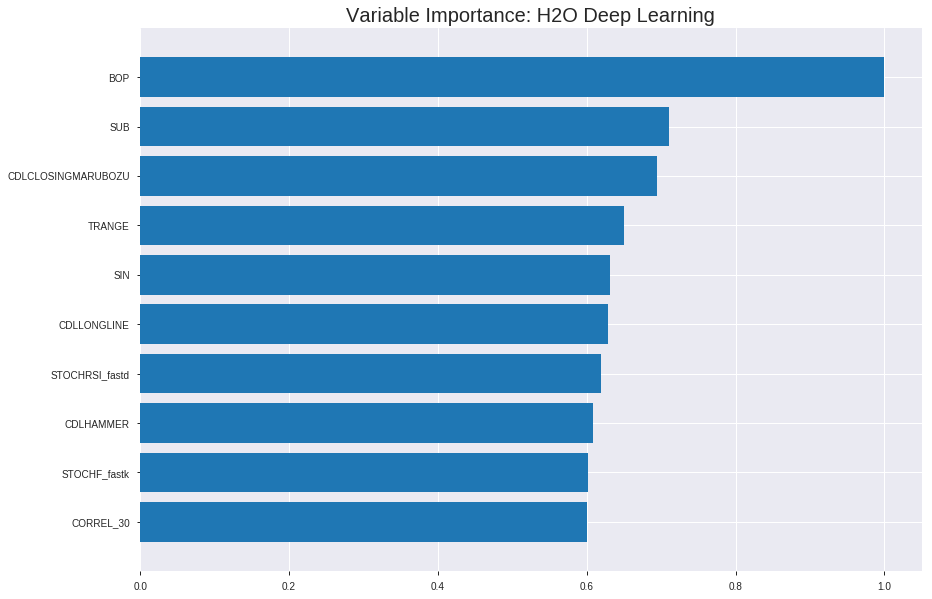

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_151434_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19374303376902477
RMSE: 0.4401625083637006
LogLoss: 0.5656766988960565
Mean Per-Class Error: 0.2980405431796581
AUC: 0.7729620998086112
pr_auc: 0.7643360744582919
Gini: 0.5459241996172224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3962851243532377: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      344  519   0.6014   (519.0/863.0)
1      60   830   0.0674   (60.0/890.0)
Total  404  1349  0.3303   (579.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396285     0.741402  262
max f2                       0.270027     0.861006  306
max f0point5                 0.561513     0.700152  160
max accuracy                 0.510316     0.703366  197
max precision                0.894131     1         0
max recall                   0.0386345    1         385
max specificity              0.894131     1         0
max absolute_mcc             0.508582     0.41157   198
max min_per_class_accuracy   0.540244     0.688297  176
max mean_per_class_accuracy  0.510316     0.701959  197

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.84485            1.96966   1.96966            1                0.85573    1                           0.85573             0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.823727           1.86024   1.91495            0.944444         0.832939   0.972222                    0.844335            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.812187           1.8538    1.89534            0.941176         0.81824    0.962264                    0.835965            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.802564           1.64139   1.83095            0.833333         0.807543   0.929577                    0.828759            0.0168539       0.0741573                  64.1386   83.0954
    5        0.0501997                   0.790958           1.62208   1.7906             0.823529         0.796482   0.909091                    0.822524            0.0157303       0.0898876                  62.2075   79.0603
    6        0.100399                    0.743376           1.54439   1.6675             0.784091         0.766727   0.846591                    0.794625            0.0775281       0.167416                   54.4395   66.7499
    7        0.150029                    0.710446           1.63007   1.65512            0.827586         0.728198   0.840304                    0.772651            0.0808989       0.248315                   63.0066   65.5116
    8        0.200228                    0.672925           1.52201   1.62175            0.772727         0.690322   0.823362                    0.75201             0.0764045       0.324719                   52.2012   62.1745
    9        0.300057                    0.614784           1.31686   1.52031            0.668571         0.64437    0.771863                    0.716198            0.131461        0.45618                    31.686    52.031
    10       0.399886                    0.571066           1.20431   1.44142            0.611429         0.590091   0.731812                    0.684716            0.120225        0.576404                   20.4308   44.1422
    11       0.500285                    0.540613           1.11913   1.37674            0.568182         0.55616    0.698974                    0.658917            0.11236         0.688764                   11.9127   37.6743
    12       0.600114                    0.50669            1.09176   1.32934            0.554286         0.525218   0.674905                    0.636676            0.108989        0.797753                   9.1756    32.9335
    13       0.699943                    0.458176           0.742844  1.24569            0.377143         0.481096   0.632437                    0.614487            0.0741573       0.87191                    -25.7156  24.5687
    14       0.799772                    0.338137           0.765355  1.18573            0.388571         0.408598   0.601997                    0.588788            0.0764045       0.948315                   -23.4645  18.5731
    15       0.899601                    0.135247           0.393933  1.09787            0.2              0.24316    0.557387                    0.550433            0.0393258       0.98764                    -60.6067  9.78654
    16       1                           0.000348972        0.123104  1                  0.0625           0.0642392  0.507701                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21607955189317757
RMSE: 0.4648435778766633
LogLoss: 0.6230003709493693
Mean Per-Class Error: 0.3472418443359877
AUC: 0.6994605702543026
pr_auc: 0.7045123849194455
Gini: 0.3989211405086053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36000337632335433: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   162  0.7074   (162.0/229.0)
1      15   257  0.0551   (15.0/272.0)
Total  82   419  0.3533   (177.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360003     0.743849  321
max f2                       0.221        0.865198  356
max f0point5                 0.547962     0.682471  211
max accuracy                 0.501363     0.658683  256
max precision                0.856436     0.888889  6
max recall                   0.0483842    1         391
max specificity              0.873024     0.995633  0
max absolute_mcc             0.360003     0.319685  321
max min_per_class_accuracy   0.562194     0.637555  193
max mean_per_class_accuracy  0.547962     0.652758  211

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.858399           1.53493   1.53493            0.833333         0.866688  0.833333                    0.866688            0.0183824       0.0183824                  53.4926    53.4926
    2        0.0219561                   0.842293           1.47353   1.50702            0.8              0.852215  0.818182                    0.86011             0.0147059       0.0330882                  47.3529    50.7019
    3        0.0319361                   0.837062           1.47353   1.49655            0.8              0.839331  0.8125                      0.853616            0.0147059       0.0477941                  47.3529    49.6553
    4        0.0419162                   0.825324           1.84191   1.57878            1                0.829227  0.857143                    0.847809            0.0183824       0.0661765                  84.1912    57.8782
    5        0.0518962                   0.811237           1.10515   1.4877             0.6              0.815831  0.807692                    0.84166             0.0110294       0.0772059                  10.5147    48.7698
    6        0.101796                    0.765428           1.47353   1.48075            0.8              0.783822  0.803922                    0.813308            0.0735294       0.150735                   47.3529    48.0753
    7        0.151697                    0.728896           1.39985   1.45414            0.76             0.748436  0.789474                    0.791969            0.0698529       0.220588                   39.9853    45.4141
    8        0.201597                    0.69744            1.03147   1.34952            0.56             0.713253  0.732673                    0.772485            0.0514706       0.272059                   3.14706    34.952
    9        0.301397                    0.641328           1.28934   1.32959            0.7              0.667096  0.721854                    0.737588            0.128676        0.400735                   28.9338    32.9592
    10       0.401198                    0.59366            1.10515   1.27376            0.6              0.613938  0.691542                    0.706829            0.110294        0.511029                   10.5147    27.376
    11       0.500998                    0.563634           1.17882   1.25485            0.64             0.577691  0.681275                    0.681104            0.117647        0.628676                   17.8824    25.4848
    12       0.600798                    0.537382           0.994632  1.21162            0.54             0.550842  0.657807                    0.659466            0.0992647       0.727941                   -0.536765  21.1623
    13       0.700599                    0.490902           0.957794  1.17547            0.52             0.516656  0.638177                    0.639123            0.0955882       0.823529                   -4.22059   17.5465
    14       0.800399                    0.405967           0.884118  1.13914            0.48             0.450357  0.618454                    0.615586            0.0882353       0.911765                   -11.5882   13.9137
    15       0.9002                      0.245534           0.663088  1.08636            0.36             0.337005  0.5898                      0.584701            0.0661765       0.977941                   -33.6912   8.63604
    16       1                           0.0207131          0.221029  1                  0.12             0.116372  0.542914                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:20:36  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:20:38  1 min 37.002 sec  602 obs/sec       0.609241  1             1068       0.565028         0.902812            -0.277332      0.744206        0.723857           1.86024          0.357673                         0.561777           0.915522              -0.271744        0.688447          0.673288             1.53493            0.341317
    2019-08-25 15:20:52  1 min 51.126 sec  909 obs/sec       7.53109   12            13202      0.440163         0.565677            0.224844       0.772962        0.764336           1.96966          0.330291                         0.464844           0.623                 0.129268         0.699461          0.704512             1.53493            0.353293
    2019-08-25 15:21:06  2 min  5.531 sec  1034 obs/sec      16.2812   26            28541      0.432552         0.547128            0.251419       0.78584         0.780146           1.96966          0.317171                         0.478316           0.68648               0.0780637        0.699244          0.711967             1.53493            0.351297
    2019-08-25 15:21:20  2 min 19.124 sec  1101 obs/sec      25.0234   40            43866      0.422912         0.526073            0.284412       0.807196        0.806934           1.96966          0.294923                         0.481082           0.681871              0.0673683        0.67936           0.686781             1.53493            0.371257
    2019-08-25 15:21:34  2 min 33.300 sec  1145 obs/sec      34.3799   55            60268      0.40854          0.489388            0.332222       0.829428        0.833881           1.96966          0.284084                         0.481925           0.709763              0.0640971        0.68453           0.694923             1.53493            0.365269
    2019-08-25 15:21:48  2 min 47.236 sec  1177 obs/sec      43.8129   70            76804      0.398124         0.465792            0.365838       0.851158        0.8531             1.96966          0.275528                         0.494197           0.786472              0.0158285        0.662969          0.668285             1.53493            0.371257
    2019-08-25 15:22:01  3 min  0.744 sec  1205 obs/sec      53.2151   85            93286      0.380974         0.428527            0.419298       0.869752        0.865269           1.96966          0.250428                         0.495593           0.83081               0.0102606        0.669455          0.674381             1.53493            0.373253
    2019-08-25 15:22:03  3 min  2.121 sec  1205 obs/sec      53.2151   85            93286      0.440163         0.565677            0.224844       0.772962        0.764336           1.96966          0.330291                         0.464844           0.623                 0.129268         0.699461          0.704512             1.53493            0.353293

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.03634842185349914
SUB                  0.7100858688354492     0.7100858688354492   0.025810500712639368
CDLCLOSINGMARUBOZU   0.6939114928245544     0.6939114928245544   0.025222587670178247
TRANGE               0.6497769951820374     0.6497769951820374   0.02361836833157577
SIN                  0.631953239440918      0.631953239440918    0.022970502938883836
---                  ---                    ---                  ---
CDLHIKKAKEMOD        0.4719468057155609     0.4719468057155609   0.017154521586560608
CDLONNECK            0.4693182706832886     0.4693182706832886   0.01705897848635087
CDL3WHITESOLDIERS    0.46879714727401733    0.46879714727401733  0.017040036472832948
CDL3LINESTRIKE       0.43054595589637756    0.43054595589637756  0.015649666032239568
CDLGAPSIDESIDEWHITE  0.40520939230918884    0.40520939230918884  0.014728721930654425


See the whole table with table.as_data_frame()


('accuracy', 0.6772908366533864)

('F1', 0.7243589743589742)

('auc', 0.7081373172282263)

('logloss', 0.6001100162183263)

('mean_per_class_error', 0.31783216783216783)

('rmse', 0.45785280654533644)

('mse', 0.20962919246144127)

deeplearning prediction progress: |███████████████████████████████████████| 100%


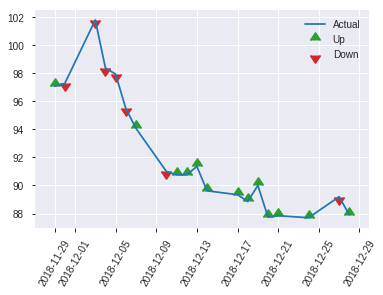


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20962919246144127
RMSE: 0.45785280654533644
LogLoss: 0.6001100162183263
Mean Per-Class Error: 0.31783216783216783
AUC: 0.7081373172282263
pr_auc: 0.6527196292869297
Gini: 0.4162746344564525
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32966013421002066: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   78   0.6      (78.0/130.0)
1      8    113  0.0661   (8.0/121.0)
Total  60   191  0.3426   (86.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32966      0.724359  190
max f2                       0.114954     0.849719  227
max f0point5                 0.493125     0.658073  153
max accuracy                 0.493125     0.677291  153
max precision                0.844872     1         0
max recall                   0.114954     1         227
max specificity              0.844872     1         0
max absolute_mcc             0.395938     0.393484  179
max min_per_class_accuracy   0.533392     0.646154  124
max mean_per_class_accuracy  0.474769     0.682168  157

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 47.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.821848           2.07438    2.07438            1                0.83695    1                           0.83695             0.0247934       0.0247934                  107.438    107.438
    2        0.0239044                   0.802704           2.07438    2.07438            1                0.808918   1                           0.822934            0.0247934       0.0495868                  107.438    107.438
    3        0.0318725                   0.791807           0          1.55579            0                0.796718   0.75                        0.81638             0               0.0495868                  -100       55.5785
    4        0.0438247                   0.781676           1.38292    1.50864            0.666667         0.786539   0.727273                    0.808242            0.0165289       0.0661157                  38.292     50.864
    5        0.0517928                   0.777053           2.07438    1.59568            1                0.780012   0.769231                    0.803899            0.0165289       0.0826446                  107.438    59.5677
    6        0.103586                    0.725605           1.43611    1.51589            0.692308         0.748129   0.730769                    0.776014            0.0743802       0.157025                   43.6109    51.5893
    7        0.151394                    0.682893           1.38292    1.4739             0.666667         0.707067   0.710526                    0.754241            0.0661157       0.22314                    38.292     47.3902
    8        0.203187                    0.636748           1.27654    1.42359            0.615385         0.658047   0.686275                    0.729721            0.0661157       0.289256                   27.6542    42.3594
    9        0.302789                    0.588082           0.995702   1.28284            0.48             0.608476   0.618421                    0.689838            0.0991736       0.38843                    -0.429752  28.284
    10       0.40239                     0.562621           1.07868    1.23231            0.52             0.573359   0.594059                    0.661006            0.107438        0.495868                   7.86777    23.2305
    11       0.501992                    0.533355           1.6595     1.31707            0.8              0.548815   0.634921                    0.638746            0.165289        0.661157                   65.9504    31.7067
    12       0.601594                    0.500698           1.24463    1.30507            0.6              0.513164   0.629139                    0.617954            0.123967        0.785124                   24.4628    30.5074
    13       0.701195                    0.411303           0.829752   1.23756            0.4              0.455879   0.596591                    0.594932            0.0826446       0.867769                   -17.0248   23.7556
    14       0.800797                    0.254001           0.746777   1.17651            0.36             0.33769    0.567164                    0.562937            0.0743802       0.942149                   -25.3223   17.6514
    15       0.900398                    0.126756           0.497851   1.10144            0.24             0.182488   0.530973                    0.520852            0.0495868       0.991736                   -50.2149   10.1441
    16       1                           0.00657711         0.0829752  1                  0.04             0.063

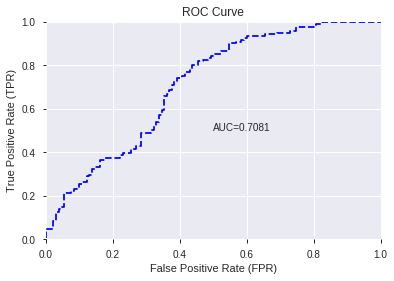

This function is available for GLM models only


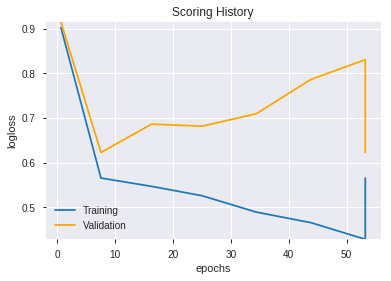

--2019-08-25 15:23:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_151434_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_151434_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'SIN',
 'CDLLONGLINE',
 'STOCHRSI_fastd',
 'CDLHAMMER',
 'STOCHF_fastk',
 'CORREL_30',
 'ULTOSC',
 'weekday_name',
 'aroondown_24',
 'HT_TRENDMODE',
 'WILLR_12',
 'CORREL_24',
 'aroondown_14',
 'COS',
 'dayofweek',
 'aroonup_12',
 'CDLSHORTLINE',
 'SAREXT',
 'weekday',
 'aroonup_8',
 'WILLR_8',
 'day',
 'days_in_month',
 'AROONOSC_8',
 'CDLENGULFING',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'COSH',
 'aroondown_12',
 'EXP',
 'CDL2CROWS',
 'aroonup_20',
 'DIV',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'SINH',
 'aroondown_20',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_152343_model_1  0.708201  0.61308              0.300159  0.462051  0.213491

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.319893           1.000000    0.107763
1                   SUB             0.171800           0.537056    0.057875
2             CDLHAMMER             0.159312           0.498017    0.053668
3           CDLLONGLINE             0.154729           0.483690    0.052124
4                TRANGE             0.152496           0.476711    0.051372
5    CDLCLOSINGMARUBOZU             0.146365           0.457545    0.049306
6          STOCHF_fastk             0.120387           0.376335    0.040555
7               WILLR_8             0.088422           0.276412    0.029787
8        STOCHRSI_fastd             0.082895           0.259132    0.027925
9              WILLR_12             0.079575           0.248755    0.026807
10         HT_TRENDMODE             0.074139           0.231762    0.024975
11           aroonup_20             0.072229           0.225791    0.024332
12         CDLSHORTLINE             0.067929           0.212348    0.022883
13    CDLDARKCLOUDCOVER             0.065062           0.203386    0.021918
14               ULTOSC             0.058898           0.184119    0.019841
15         CDLENGULFING             0.058470           0.182781    0.019697
16            aroonup_8             0.058086           0.181580    0.019568
17            CDLONNECK             0.055096           0.172232    0.018560
18         aroondown_24             0.054816           0.171358    0.018466
19         aroondown_14             0.053537           0.167359    0.018035
20      CDLADVANCEBLOCK             0.053102           0.166000    0.017889
21               SAREXT             0.051920           0.162304    0.017490
22         aroondown_20             0.051373           0.160593    0.017306
23       CDLEVENINGSTAR             0.050675           0.158413    0.017071
24          AROONOSC_14             0.048771           0.152460    0.016430
25            CORREL_30             0.047771           0.149335    0.016093
26           AROONOSC_8             0.044722           0.139803    0.015066
27                  EXP             0.037810           0.118196    0.012737
28                 SINH             0.037784           0.118115    0.012728
29                 COSH             0.037782           0.118109    0.012728
30            dayofweek             0.034211           0.106946    0.011525
31              weekday             0.034149           0.106751    0.011504
32    CDL3WHITESOLDIERS             0.033217           0.103837    0.011190
33         aroondown_12             0.031294           0.097826    0.010542
34       STOCHRSI_fastk             0.029895           0.093453    0.010071
35                  SIN             0.029558           0.092399    0.009957
36           aroonup_12             0.027603           0.086290    0.009299
37                  day             0.027113           0.084756    0.009134
38            CDL2CROWS             0.026004           0.081291    0.008760
39         weekday_name             0.022346           0.069855    0.007528
40        CDLHIKKAKEMOD             0.017775           0.055566    0.005988
41        days_in_month             0.016778           0.052448    0.005652
42                  COS             0.016579           0.051826    0.005585
43   CDLEVENINGDOJISTAR             0.015400           0.048141    0.005188
44            CORREL_24             0.013320           0.041639    0.004487
45                  DIV             0.010797           0.033752    0.003637
46       CDL3LINESTRIKE             0.010428           0.032598    0.003513
47  CDLGAPSIDESIDEWHITE             0.009669           0.030225    0.003257
48    CDLSTALLEDPATTERN             0.004944           0.015455    0.001665
49             CORREL_8             0.001556           0.004865    0.000524

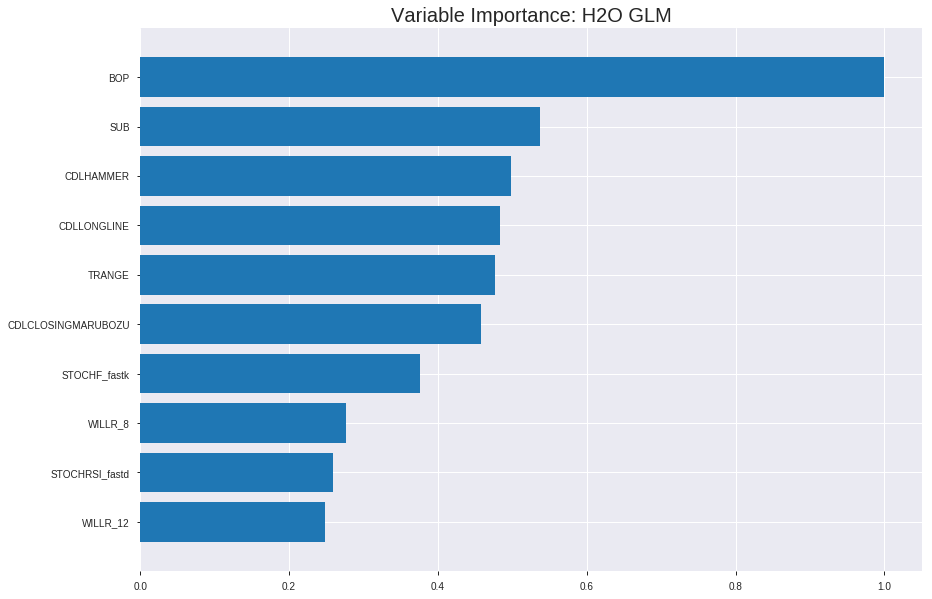

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_152343_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19976808535658946
RMSE: 0.44695423183653765
LogLoss: 0.583680247497053
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.7581400712443
Residual deviance: 2046.3829477246682
AIC: 2148.382947724668
AUC: 0.75974455453279
pr_auc: 0.7498133376312123
Gini: 0.51948910906558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35941988385028567: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      326  537   0.6222   (537.0/863.0)
1      65   825   0.073    (65.0/890.0)
Total  391  1362  0.3434   (602.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35942      0.732682  282
max f2                       0.29753      0.850387  309
max f0point5                 0.528259     0.698409  184
max accuracy                 0.474401     0.694809  219
max precision                0.919846     1         0
max recall                   0.115808     1         383
max specificity              0.919846     1         0
max absolute_mcc             0.474401     0.393104  219
max min_per_class_accuracy   0.51803      0.688764  190
max mean_per_class_accuracy  0.474401     0.693497  219

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.862119           1.86024   1.86024            0.944444         0.883954  0.944444                    0.883954            0.0191011       0.0191011                  86.0237    86.0237
    2        0.0205362                   0.84449            1.75081   1.80552            0.888889         0.853274  0.916667                    0.868614            0.0179775       0.0370787                  75.0811    80.5524
    3        0.0302339                   0.829793           1.8538    1.82101            0.941176         0.836585  0.924528                    0.85834             0.0179775       0.0550562                  85.38      82.1009
    4        0.040502                    0.812859           1.86024   1.83095            0.944444         0.820864  0.929577                    0.848839            0.0191011       0.0741573                  86.0237    83.0954
    5        0.0501997                   0.800475           1.50621   1.76822            0.764706         0.806177  0.897727                    0.840598            0.0146067       0.088764                   50.6213    76.822
    6        0.100399                    0.75125            1.63392   1.70107            0.829545         0.775397  0.863636                    0.807997            0.0820225       0.170787                   63.3925    70.1073
    7        0.150029                    0.717355           1.40367   1.60269            0.712644         0.732664  0.813688                    0.783077            0.0696629       0.240449                   40.3668    60.2692
    8        0.200228                    0.683981           1.45486   1.56563            0.738636         0.701379  0.794872                    0.762594            0.0730337       0.313483                   45.4865    56.563
    9        0.300057                    0.624496           1.42941   1.52031            0.725714         0.652743  0.771863                    0.726047            0.142697        0.45618                    42.9413    52.031
    10       0.399886                    0.570102           1.1818    1.4358             0.6              0.594855  0.728959                    0.693296            0.117978        0.574157                   18.1798    43.5803
    11       0.500285                    0.517603           1.11913   1.37225            0.568182         0.54425   0.696693                    0.663384            0.11236         0.686517                   11.9127    37.2251
    12       0.600114                    0.467644           0.990459  1.30874            0.502857         0.492693  0.664449                    0.63499             0.0988764       0.785393                   -0.954093  30.874
    13       0.699943                    0.410154           0.77661   1.23285            0.394286         0.440354  0.625917                    0.60723             0.0775281       0.862921                   -22.339    23.2845
    14       0.799772                    0.334259           0.77661   1.1759             0.394286         0.375568  0.597004                    0.578314            0.0775281       0.940449                   -22.339    17.5897
    15       0.899601                    0.229687           0.382677  1.08787            0.194286         0.283964  0.552315                    0.54565             0.0382022       0.978652                   -61.7323   8.78734
    16       1                           0.0335823          0.212634  1                  0.107955         0.167675  0.507701                    0.50



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2161507150268174
RMSE: 0.4649201168231134
LogLoss: 0.6202307259527403
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.327648451823
Residual deviance: 621.4711874046458
AIC: 723.4711874046458
AUC: 0.7000545851528385
pr_auc: 0.7146000740857523
Gini: 0.40010917030567694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33293777120888485: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   166  0.7249   (166.0/229.0)
1      12   260  0.0441   (12.0/272.0)
Total  75   426  0.3553   (178.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.332938     0.744986  329
max f2                       0.205371     0.863724  376
max f0point5                 0.512321     0.692568  237
max accuracy                 0.512321     0.672655  237
max precision                0.930387     1         0
max recall                   0.174882     1         386
max specificity              0.930387     1         0
max absolute_mcc             0.512321     0.336056  237
max min_per_class_accuracy   0.557458     0.633188  203
max mean_per_class_accuracy  0.512321     0.665048  237

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.870418           1.84191   1.84191            1                0.901322  1                           0.901322            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.851455           1.47353   1.67447            0.8              0.862965  0.909091                    0.883887            0.0147059       0.0367647                  47.3529   67.4465
    3        0.0319361                   0.837723           1.84191   1.72679            1                0.842195  0.9375                      0.870858            0.0183824       0.0551471                  84.1912   72.6792
    4        0.0419162                   0.83071            1.10515   1.57878            0.6              0.834124  0.857143                    0.862112            0.0110294       0.0661765                  10.5147   57.8782
    5        0.0518962                   0.823268           1.84191   1.62938            1                0.824655  0.884615                    0.854909            0.0183824       0.0845588                  84.1912   62.9383
    6        0.101796                    0.784011           1.32618   1.48075            0.72             0.802987  0.803922                    0.829457            0.0661765       0.150735                   32.6176   48.0753
    7        0.151697                    0.74939            1.32618   1.42991            0.72             0.764634  0.776316                    0.808134            0.0661765       0.216912                   32.6176   42.9905
    8        0.201597                    0.723342           1.10515   1.34952            0.6              0.733426  0.732673                    0.789642            0.0551471       0.272059                   10.5147   34.952
    9        0.301397                    0.660834           1.28934   1.32959            0.7              0.689224  0.721854                    0.756391            0.128676        0.400735                   28.9338   32.9592
    10       0.401198                    0.609566           1.03147   1.25543            0.56             0.632097  0.681592                    0.725472            0.102941        0.503676                   3.14706   25.5432
    11       0.500998                    0.562083           1.14199   1.23283            0.62             0.581899  0.669323                    0.696872            0.113971        0.617647                   14.1985   23.2833
    12       0.600798                    0.514394           1.32618   1.24834            0.72             0.535656  0.677741                    0.670092            0.132353        0.75                       32.6176   24.8339
    13       0.700599                    0.450206           0.663088  1.16497            0.36             0.485118  0.632479                    0.643742            0.0661765       0.816176                   -33.6912  16.497
    14       0.800399                    0.373356           0.920956  1.13454            0.5              0.414239  0.61596                     0.615126            0.0919118       0.908088                   -7.90441  13.4544
    15       0.9002                      0.286669           0.62625   1.07819            0.34             0.329623  0.585366                    0.583474            0.0625          0.970588                   -37.375   7.81923
    16       1                           0.0743756          0.294706  1                  0.16             0.199753  0.542914                    0.545178           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:23:43  0.000 sec   2            19        51            1.37006           1.37018
    2019-08-25 15:23:43  0.015 sec   4            12        51            1.36148           1.36294
    2019-08-25 15:23:44  0.029 sec   6            7.2       51            1.34916           1.35265
    2019-08-25 15:23:44  0.039 sec   8            4.4       51            1.3324            1.33894
    2019-08-25 15:23:44  0.049 sec   10           2.8       51            1.31108           1.322
    2019-08-25 15:23:44  0.059 sec   12           1.7       51            1.28613           1.30297
    2019-08-25 15:23:44  0.070 sec   14           1.1       51            1.25955           1.28393
    2019-08-25 15:23:44  0.080 sec   16           0.66      51            1.23382           1.26709
    2019-08-25 15:23:44  0.090 sec   18           0.41      51            1.21109           1.25417
    2019-08-25 15:23:44  0.104 sec   20           0.26      51            1.19248           1.24577
    2019-08-25 15:23:44  0.114 sec   22           0.16      51            1.17811           1.24152
    2019-08-25 15:23:44  0.135 sec   24           0.098     51            1.16736           1.24046
    2019-08-25 15:23:44  0.149 sec   26           0.061     51            1.15943           1.24158
    2019-08-25 15:23:44  0.159 sec   28           0.038     51            1.15363           1.2441
    2019-08-25 15:23:44  0.170 sec   30           0.024     51            1.14948           1.24744
    2019-08-25 15:23:44  0.182 sec   32           0.015     51            1.14664           1.25122
    2019-08-25 15:23:44  0.194 sec   34           0.0091    51            1.14481           1.25519

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7353951890034365)

('auc', 0.7082008900190718)

('logloss', 0.6130800403574722)

('mean_per_class_error', 0.30015893197711385)

('rmse', 0.4620509381046867)

('mse', 0.21349106940342102)

glm prediction progress: |████████████████████████████████████████████████| 100%


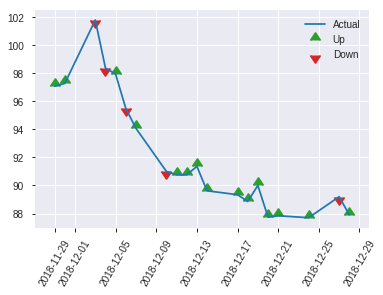


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21349106940342102
RMSE: 0.4620509381046867
LogLoss: 0.6130800403574722
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.2966965690315
Residual deviance: 307.76618025945106
AIC: 409.76618025945106
AUC: 0.7082008900190718
pr_auc: 0.6353270974442841
Gini: 0.41640178003814365
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930357586085634: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   63   0.4846   (63.0/130.0)
1      14   107  0.1157   (14.0/121.0)
Total  81   170  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393036     0.735395  169
max f2                       0.263548     0.847578  217
max f0point5                 0.393036     0.667915  169
max accuracy                 0.393036     0.693227  169
max precision                0.859612     1         0
max recall                   0.203392     1         230
max specificity              0.859612     1         0
max absolute_mcc             0.393036     0.427181  169
max min_per_class_accuracy   0.518025     0.646154  124
max mean_per_class_accuracy  0.393036     0.699841  169

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.840505           2.07438    2.07438            1                0.852495  1                           0.852495            0.0247934       0.0247934                  107.438   107.438
    2        0.0239044                   0.836345           1.38292    1.72865            0.666667         0.836951  0.833333                    0.844723            0.0165289       0.0413223                  38.292    72.865
    3        0.0318725                   0.80304            1.03719    1.55579            0.5              0.816397  0.75                        0.837641            0.00826446      0.0495868                  3.71901   55.5785
    4        0.0438247                   0.77714            0.69146    1.32006            0.333333         0.79105   0.636364                    0.824935            0.00826446      0.0578512                  -30.854   32.006
    5        0.0517928                   0.773218           2.07438    1.43611            1                0.77465   0.692308                    0.817199            0.0165289       0.0743802                  107.438   43.6109
    6        0.103586                    0.71362            1.11697    1.27654            0.538462         0.736305  0.615385                    0.776752            0.0578512       0.132231                   11.6974   27.6542
    7        0.151394                    0.684813           1.38292    1.31013            0.666667         0.699816  0.631579                    0.752456            0.0661157       0.198347                   38.292    31.0135
    8        0.203187                    0.645945           1.75524    1.42359            0.846154         0.664021  0.686275                    0.729914            0.0909091       0.289256                   75.5245   42.3594
    9        0.302789                    0.612077           0.912727   1.25555            0.44             0.62751   0.605263                    0.696228            0.0909091       0.380165                   -8.72727  25.5546
    10       0.40239                     0.565755           1.41058    1.29392            0.68             0.59104   0.623762                    0.670192            0.140496        0.520661                   41.0579   29.392
    11       0.501992                    0.51548            1.41058    1.31707            0.68             0.538628  0.634921                    0.644088            0.140496        0.661157                   41.0579   31.7067
    12       0.601594                    0.458543           1.16165    1.29134            0.56             0.481441  0.622517                    0.617159            0.115702        0.77686                    16.1653   29.1336
    13       0.701195                    0.375992           1.16165    1.27292            0.56             0.419524  0.613636                    0.589086            0.115702        0.892562                   16.1653   27.2915
    14       0.800797                    0.319532           0.414876   1.16619            0.2              0.347021  0.562189                    0.558979            0.0413223       0.933884                   -58.5124  16.6194
    15       0.900398                    0.223497           0.580826   1.10144            0.28             0.274515  0.530973                    0.527511            0.0578512       0.991736                   -41.9174  10.1441
    16       1                           0.0419221          0.0829752  1                  0.04             0.154239  0.482072                    0.

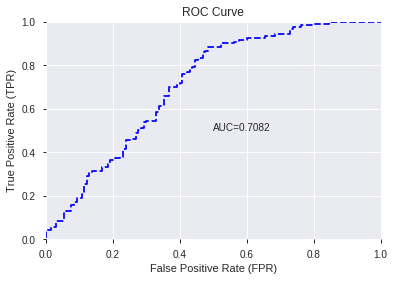

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


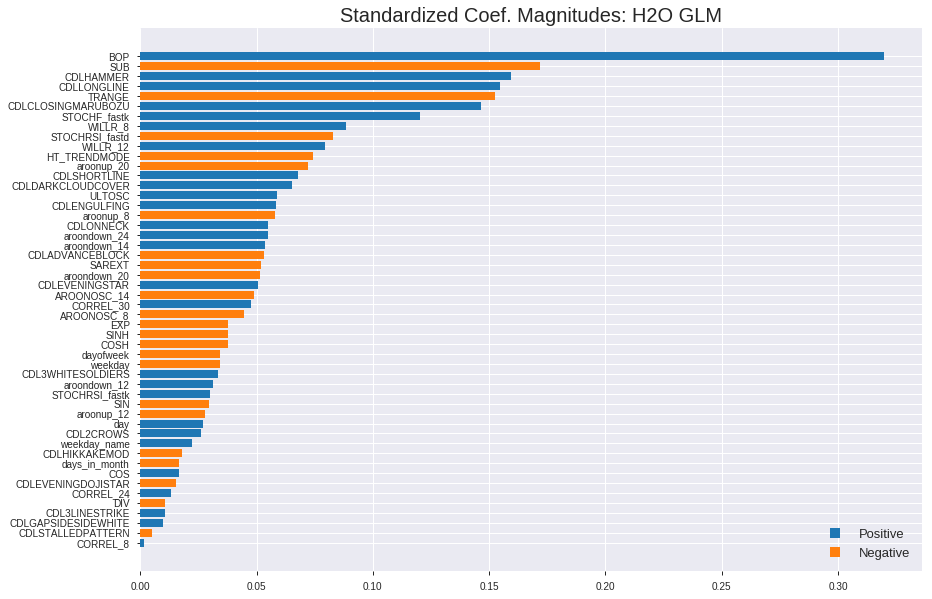

'log_likelihood'
--2019-08-25 15:23:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_152343_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_152343_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CDLHAMMER',
 'CDLLONGLINE',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCHRSI_fastd',
 'WILLR_12',
 'HT_TRENDMODE',
 'aroonup_20',
 'CDLSHORTLINE',
 'CDLDARKCLOUDCOVER',
 'ULTOSC',
 'CDLENGULFING',
 'aroonup_8',
 'CDLONNECK',
 'aroondown_24',
 'aroondown_14',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'aroondown_20',
 'CDLEVENINGSTAR',
 'AROONOSC_14',
 'CORREL_30',
 'AROONOSC_8',
 'EXP',
 'SINH',
 'COSH',
 'dayofweek',
 'weekday',
 'CDL3WHITESOLDIERS',
 'aroondown_12',
 'STOCHRSI_fastk',
 'SIN',
 'aroonup_12',
 'day',
 'CDL2CROWS',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'days_in_month',
 'COS',
 'CDLEVENINGDOJISTAR',
 'CORREL_24',
 'DIV',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CORREL_8']

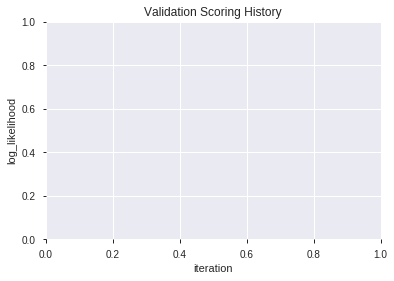

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_152354_model_4  0.712715  0.616375              0.302161  0.462374  0.213790
1  XGBoost_grid_1_AutoML_20190825_152354_model_1  0.702861  0.635581              0.322537  0.469276  0.220220
2  XGBoost_grid_1_AutoML_20190825_152354_model_2  0.701335  0.625907              0.314844  0.466325  0.217459
3  XGBoost_grid_1_AutoML_20190825_152354_model_6  0.699619  0.634613              0.325238  0.470014  0.220913
4               XGBoost_3_AutoML_20190825_152354  0.697266  0.629380              0.338620  0.468640  0.219624
5  XGBoost_grid_1_AutoML_20190825_152354_model_3  0.696885  0.633167              0.317260  0.469884  0.220791
6  XGBoost_grid_1_AutoML_20190825_152354_model_5  0.696758  0.644231              0.330356  0.473844  0.224528
7               XGBoost_2_AutoML_20190825_152354  0.692117  0.637492              0.333217  0.471829  0.222623
8               XGBoost_1_AutoML_20190825_152354  0.685251  0.643305              0.354291  0.474342  0.225000
9  XGBoost_grid_1_AutoML_20190825_152354_model_7  0.680992  0.653590              0.368818  0.478325  0.228795

variable  relative_importance  scaled_importance  percentage
0                  BOP          2088.120850           1.000000    0.447291
1                  SUB           377.581726           0.180824    0.080881
2                  DIV           249.398361           0.119437    0.053423
3          AROONOSC_14           150.073837           0.071870    0.032147
4               TRANGE           139.581024           0.066845    0.029899
5              WILLR_8           127.327454           0.060977    0.027274
6               ULTOSC           127.077240           0.060857    0.027221
7             CORREL_8           112.229462           0.053747    0.024040
8            CORREL_30           108.244957           0.051838    0.023187
9                  COS            99.011269           0.047416    0.021209
10        aroondown_24            94.262611           0.045142    0.020192
11          aroonup_20            92.404579           0.044253    0.019794
12                COSH            91.494392           0.043817    0.019599
13        STOCHF_fastk            86.560905           0.041454    0.018542
14              SAREXT            81.448639           0.039006    0.017447
15          aroonup_12            69.499352           0.033283    0.014887
16           dayofweek            61.457825           0.029432    0.013165
17      STOCHRSI_fastd            54.415207           0.026059    0.011656
18            WILLR_12            51.973522           0.024890    0.011133
19                 SIN            51.458961           0.024644    0.011023
20          AROONOSC_8            46.964851           0.022491    0.010060
21           aroonup_8            45.701157           0.021886    0.009790
22        weekday_name            44.463211           0.021293    0.009524
23         CDLLONGLINE            33.998875           0.016282    0.007283
24        aroondown_12            33.681541           0.016130    0.007215
25  CDLCLOSINGMARUBOZU            31.599388           0.015133    0.006769
26           CORREL_24            26.365698           0.012627    0.005648
27        aroondown_14            25.720150           0.012317    0.005509
28                 day            18.960505           0.009080    0.004061
29        HT_TRENDMODE            17.938961           0.008591    0.003843
30      STOCHRSI_fastk            16.440805           0.007873    0.003522
31        aroondown_20             6.552151           0.003138    0.001404
32       days_in_month             6.367228           0.003049    0.001364

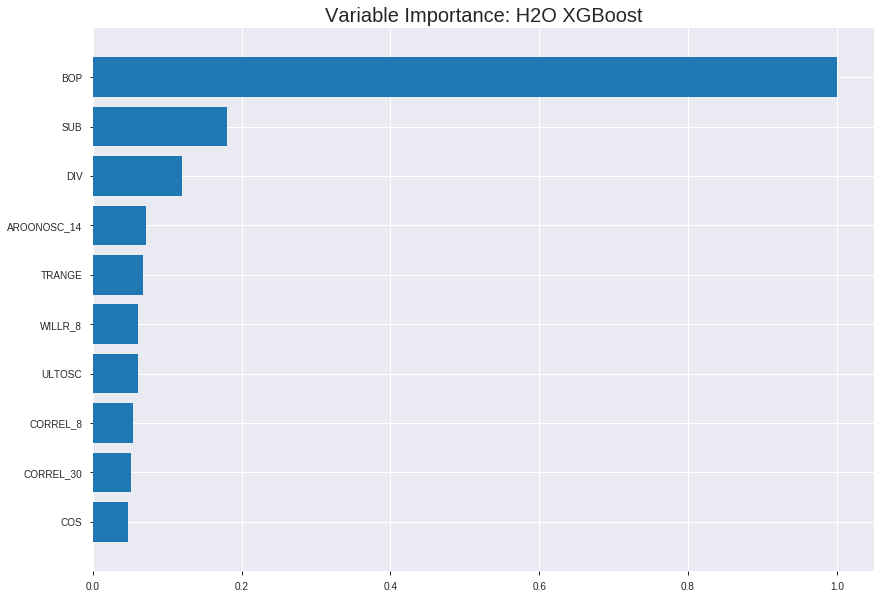

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_152354_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18202370200761525
RMSE: 0.42664235843105786
LogLoss: 0.5442149909708813
Mean Per-Class Error: 0.2621186870988321
AUC: 0.8136283151275274
pr_auc: 0.8145449339542795
Gini: 0.6272566302550548
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43860934178034466: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      479  384   0.445    (384.0/863.0)
1      116  774   0.1303   (116.0/890.0)
Total  595  1158  0.2852   (500.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438609     0.755859  235
max f2                       0.244644     0.858786  328
max f0point5                 0.556813     0.744175  164
max accuracy                 0.527318     0.738163  182
max precision                0.860679     1         0
max recall                   0.146692     1         376
max specificity              0.860679     1         0
max absolute_mcc             0.50614      0.476855  195
max min_per_class_accuracy   0.538887     0.733488  174
max mean_per_class_accuracy  0.527318     0.737881  182

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.826628           1.96966   1.96966            1                0.838077  1                           0.838077            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.809133           1.96966   1.96966            1                0.816692  1                           0.827385            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.800402           1.73794   1.89534            0.882353         0.80417   0.962264                    0.819939            0.0168539       0.0573034                  73.7938   89.5336
    4        0.040502                    0.791832           1.75081   1.8587             0.888889         0.796322  0.943662                    0.813951            0.0179775       0.0752809                  75.0811   85.8696
    5        0.0501997                   0.785017           1.96966   1.88013            1                0.788069  0.954545                    0.808951            0.0191011       0.094382                   96.9663   88.0133
    6        0.100399                    0.749708           1.7906    1.83537            0.909091         0.765705  0.931818                    0.787328            0.0898876       0.18427                    79.0603   83.5368
    7        0.150029                    0.724605           1.67535   1.78243            0.850575         0.736783  0.904943                    0.770608            0.0831461       0.267416                   67.5345   78.2433
    8        0.200228                    0.701954           1.70107   1.76203            0.863636         0.713269  0.894587                    0.756232            0.0853933       0.352809                   70.1073   76.2035
    9        0.300057                    0.650928           1.41816   1.64763            0.72             0.677112  0.836502                    0.729909            0.141573        0.494382                   41.8157   64.7627
    10       0.399886                    0.593514           1.1818    1.53134            0.6              0.623556  0.777461                    0.703359            0.117978        0.61236                    18.1798   53.1336
    11       0.500285                    0.541124           1.18627   1.46209            0.602273         0.568402  0.742303                    0.676275            0.119101        0.731461                   18.6274   46.2087
    12       0.600114                    0.48456            0.889162  1.36678            0.451429         0.511836  0.693916                    0.648921            0.088764        0.820225                   -11.0838  36.6781
    13       0.699943                    0.401566           0.709079  1.27298            0.36             0.446145  0.646292                    0.62                0.0707865       0.891011                   -29.0921  27.2977
    14       0.799772                    0.293092           0.641547  1.19416            0.325714         0.348482  0.606277                    0.586109            0.0640449       0.955056                   -35.8453  19.4161
    15       0.899601                    0.197618           0.326401  1.09787            0.165714         0.243229  0.557387                    0.548059            0.0325843       0.98764                    -67.3599  9.78654
    16       1                           0.098603           0.123104  1                  0.0625           0.148431  0.507701                    0.507937         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.216350454857232
RMSE: 0.4651348781345385
LogLoss: 0.6208101691003745
Mean Per-Class Error: 0.3421846904700745
AUC: 0.7023744541484717
pr_auc: 0.710911640279486
Gini: 0.4047489082969433
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580990731716156: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      77   152  0.6638   (152.0/229.0)
1      23   249  0.0846   (23.0/272.0)
Total  100  401  0.3493   (175.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358099     0.73997   308
max f2                       0.17585      0.868033  374
max f0point5                 0.561141     0.687135  203
max accuracy                 0.536895     0.666667  227
max precision                0.87028      1         0
max recall                   0.123727     1         396
max specificity              0.87028      1         0
max absolute_mcc             0.536895     0.323392  227
max min_per_class_accuracy   0.579027     0.655022  190
max mean_per_class_accuracy  0.561141     0.657815  203

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 54.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.827161           1.84191   1.84191            1                0.847943  1                           0.847943            0.0220588       0.0220588                  84.1912    84.1912
    2        0.0219561                   0.814151           1.10515   1.50702            0.6              0.816645  0.818182                    0.833717            0.0110294       0.0330882                  10.5147    50.7019
    3        0.0319361                   0.804506           1.84191   1.61167            1                0.806949  0.875                       0.825352            0.0183824       0.0514706                  84.1912    61.1673
    4        0.0419162                   0.793594           1.47353   1.57878            0.8              0.79835   0.857143                    0.818923            0.0147059       0.0661765                  47.3529    57.8782
    5        0.0518962                   0.789625           1.10515   1.4877             0.6              0.791492  0.807692                    0.813648            0.0110294       0.0772059                  10.5147    48.7698
    6        0.101796                    0.766184           1.39985   1.44464            0.76             0.777485  0.784314                    0.795921            0.0698529       0.147059                   39.9853    44.4637
    7        0.151697                    0.7454             1.32618   1.40567            0.72             0.755064  0.763158                    0.782481            0.0661765       0.213235                   32.6176    40.567
    8        0.201597                    0.729142           1.39985   1.40423            0.76             0.737789  0.762376                    0.771419            0.0698529       0.283088                   39.9853    40.423
    9        0.301397                    0.686271           1.28934   1.36619            0.7              0.705143  0.741722                    0.749473            0.128676        0.411765                   28.9338    36.6186
    10       0.401198                    0.629219           0.994632  1.27376            0.54             0.656405  0.691542                    0.726322            0.0992647       0.511029                   -0.536765  27.376
    11       0.500998                    0.584337           1.32618   1.2842             0.72             0.606704  0.697211                    0.702494            0.132353        0.643382                   32.6176    28.4201
    12       0.600798                    0.543297           0.957794  1.22998            0.52             0.562392  0.667774                    0.679221            0.0955882       0.738971                   -4.22059   22.9981
    13       0.700599                    0.480845           0.699926  1.15447            0.38             0.516489  0.626781                    0.65604             0.0698529       0.808824                   -30.0074   15.4475
    14       0.800399                    0.358099           1.06831   1.14373            0.58             0.426271  0.620948                    0.62739             0.106618        0.915441                   6.83088    14.3731
    15       0.9002                      0.238758           0.552574  1.07819            0.3              0.293784  0.585366                    0.590405            0.0551471       0.970588                   -44.7426   7.81923
    16       1                           0.116245           0.294706  1                  0.16             0.170403  0.542914                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:24:00  2.358 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.457086
    2019-08-25 15:24:00  2.416 sec   5                  0.479909         0.65354             0.771686        0.747625           1.88013          0.336566                         0.484512           0.662499              0.723558          0.728553             1.26631            0.339321
    2019-08-25 15:24:00  2.455 sec   10                 0.465967         0.626251            0.779449        0.773099           1.86024          0.306332                         0.474283           0.642275              0.718084          0.714543             1.38143            0.333333
    2019-08-25 15:24:00  2.499 sec   15                 0.456261         0.606953            0.786518        0.785065           1.96966          0.308043                         0.467888           0.629295              0.719513          0.722978             1.84191            0.327345
    2019-08-25 15:24:00  2.553 sec   20                 0.449451         0.593053            0.789646        0.789993           1.86024          0.31603                          0.464278           0.621646              0.717787          0.722586             1.53493            0.327345
    2019-08-25 15:24:00  2.601 sec   25                 0.444445         0.582697            0.794141        0.794219           1.96966          0.309755                         0.463301           0.6192                0.714512          0.717834             1.84191            0.333333
    2019-08-25 15:24:00  2.649 sec   30                 0.439939         0.573196            0.798268        0.79946            1.96966          0.312037                         0.462347           0.616766              0.713139          0.716704             1.53493            0.329341
    2019-08-25 15:24:00  2.705 sec   35                 0.436692         0.566036            0.800352        0.800686           1.96966          0.302909                         0.46193            0.615501              0.712625          0.718127             1.84191            0.331337
    2019-08-25 15:24:00  2.758 sec   40                 0.433638         0.559399            0.804217        0.802956           1.96966          0.281232                         0.462864           0.617115              0.707801          0.711759             1.53493            0.351297
    2019-08-25 15:24:00  2.809 sec   45                 0.430938         0.553604            0.807778        0.808009           1.96966          0.274387                         0.463815           0.618678              0.704389          0.710859             1.84191            0.351297
    2019-08-25 15:24:00  2.868 sec   50                 0.428828         0.549165            0.811395        0.813575           1.96966          0.268682                         0.46502            0.620883              0.701387          0.709318             1.84191            0.353293
    2019-08-25 15:24:00  2.924 sec   55                 0.426642         0.544215            0.813628        0.814545           1.96966          0.285225                         0.465135           0.62081               0.702374          0

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             2088.120849609375      1.0                   0.447290565091411
SUB             377.58172607421875     0.18082369425354525   0.08088073238458478
DIV             249.3983612060547      0.11943674680165646   0.05342292996959269
AROONOSC_14     150.07383728027344     0.0718702834217415    0.03214689968499062
TRANGE          139.58102416992188     0.06684528062445874   0.029899263344208095
---             ---                    ---                   ---
day             18.96050453186035      0.009080175860227293  0.004061476991650455
HT_TRENDMODE    17.938961029052734     0.008590959202580913  0.003842654996399674
STOCHRSI_fastk  16.440805435180664     0.007873493259863886  0.003521739249447933
aroondown_20    6.552150726318359      0.003137821610058666  0.0014035180011191819
days_in_month   6.367228031158447      0.003049262226537111  0.0013639062244196786


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7220216606498194)

('auc', 0.7127145581691037)

('logloss', 0.6163747987030337)

('mean_per_class_error', 0.30216147488874756)

('rmse', 0.4623744032003452)

('mse', 0.21379008873487534)

xgboost prediction progress: |████████████████████████████████████████████| 100%


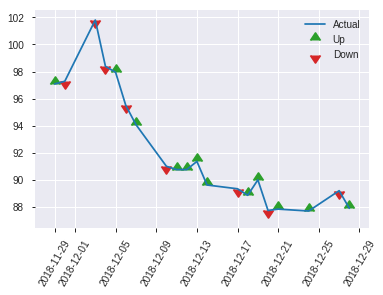


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21379008873487534
RMSE: 0.4623744032003452
LogLoss: 0.6163747987030337
Mean Per-Class Error: 0.30216147488874756
AUC: 0.7127145581691037
pr_auc: 0.6398084189389188
Gini: 0.42542911633820735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43905162811279297: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   56   0.4308   (56.0/130.0)
1      21   100  0.1736   (21.0/121.0)
Total  95   156  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439052     0.722022  155
max f2                       0.183092     0.83921   224
max f0point5                 0.439052     0.671141  155
max accuracy                 0.439052     0.693227  155
max precision                0.813605     1         0
max recall                   0.127623     1         243
max specificity              0.813605     1         0
max absolute_mcc             0.439052     0.407644  155
max min_per_class_accuracy   0.544132     0.661157  123
max mean_per_class_accuracy  0.439052     0.697839  155

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.792034           1.38292   1.38292            0.666667         0.805413  0.666667                    0.805413            0.0165289       0.0165289                  38.292    38.292
    2        0.0239044                   0.782564           1.38292   1.38292            0.666667         0.785346  0.666667                    0.79538             0.0165289       0.0330579                  38.292    38.292
    3        0.0318725                   0.780163           1.03719   1.29649            0.5              0.782341  0.625                       0.79212             0.00826446      0.0413223                  3.71901   29.6488
    4        0.0438247                   0.772464           2.07438   1.50864            1                0.775431  0.727273                    0.787568            0.0247934       0.0661157                  107.438   50.864
    5        0.0517928                   0.769341           2.07438   1.59568            1                0.770134  0.769231                    0.784886            0.0165289       0.0826446                  107.438   59.5677
    6        0.103586                    0.745196           1.11697   1.35633            0.538462         0.757623  0.653846                    0.771255            0.0578512       0.140496                   11.6974   35.6325
    7        0.151394                    0.720041           1.72865   1.4739             0.833333         0.731028  0.710526                    0.758551            0.0826446       0.22314                    72.865    47.3902
    8        0.203187                    0.698493           0.797839  1.30157            0.384615         0.709607  0.627451                    0.746075            0.0413223       0.264463                   -20.2161  30.1572
    9        0.302789                    0.654605           1.57653   1.39202            0.76             0.674182  0.671053                    0.722426            0.157025        0.421488                   57.6529   39.2018
    10       0.40239                     0.588281           1.41058   1.39661            0.68             0.62107   0.673267                    0.697338            0.140496        0.561983                   41.0579   39.6612
    11       0.501992                    0.533734           1.07868   1.33353            0.52             0.565364  0.642857                    0.671153            0.107438        0.669421                   7.86777   33.353
    12       0.601594                    0.454827           1.24463   1.31881            0.6              0.486878  0.635762                    0.640644            0.123967        0.793388                   24.4628   31.8811
    13       0.701195                    0.338007           0.663802  1.22577            0.32             0.394401  0.590909                    0.605666            0.0661157       0.859504                   -33.6198  22.577
    14       0.800797                    0.255066           0.580826  1.14555            0.28             0.290687  0.552239                    0.56649             0.0578512       0.917355                   -41.9174  14.5553
    15       0.900398                    0.182765           0.663802  1.09226            0.32             0.220195  0.526549                    0.528183            0.0661157       0.983471                   -33.6198  9.22621
    16       1                           0.101831           0.16595   1                  0.08             0.140675  0.482072                    0.489586            0.

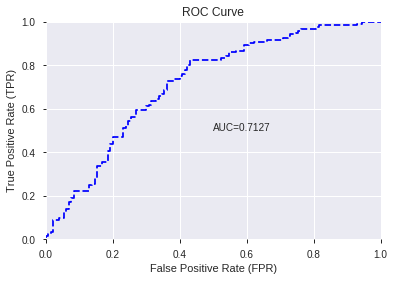

This function is available for GLM models only


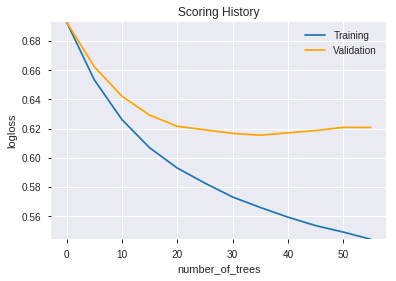

--2019-08-25 15:24:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_152354_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_152354_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'AROONOSC_14',
 'TRANGE',
 'WILLR_8',
 'ULTOSC',
 'CORREL_8',
 'CORREL_30',
 'COS',
 'aroondown_24',
 'aroonup_20',
 'COSH',
 'STOCHF_fastk',
 'SAREXT',
 'aroonup_12',
 'dayofweek',
 'STOCHRSI_fastd',
 'WILLR_12',
 'SIN',
 'AROONOSC_8',
 'aroonup_8',
 'weekday_name',
 'CDLLONGLINE',
 'aroondown_12',
 'CDLCLOSINGMARUBOZU',
 'CORREL_24',
 'aroondown_14',
 'day',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'aroondown_20',
 'days_in_month']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_152415_model_1  0.696122  0.634036              0.301875  0.468785  0.219759

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.208584           1.000000  3.565201e-02
1                  CDLLONGLINE             0.127628           0.611877  2.181463e-02
2           CDLCLOSINGMARUBOZU             0.118687           0.569010  2.028635e-02
3                          SUB             0.116234           0.557251  1.986710e-02
4                    CDLHAMMER             0.107408           0.514940  1.835863e-02
...                        ...                  ...                ...           ...
1034  BBANDS_middleband_30_0_5             0.000007           0.000034  1.224208e-06
1035                    MIN_20             0.000006           0.000029  1.047269e-06
1036  BBANDS_middleband_30_2_3             0.000004           0.000019  6.759799e-07
1037   BBANDS_upperband_24_0_3             0.000003           0.000016  5.846539e-07
1038  BBANDS_middleband_12_1_5             0.000003           0.000015  5.405277e-07

[1039 rows x 4 columns]

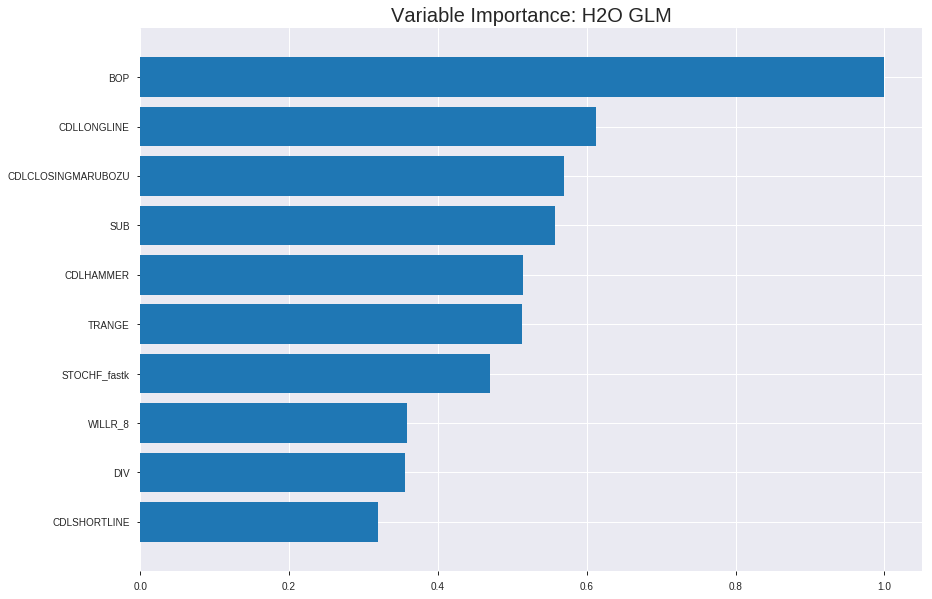

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_152415_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19633030029673232
RMSE: 0.44309175155573854
LogLoss: 0.5774443582278806
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2429.7581400712443
Residual deviance: 2024.5199199469494
AIC: 4104.51991994695
AUC: 0.7764116551876782
pr_auc: 0.765254456744372
Gini: 0.5528233103753564
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3936157741524332: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  467   0.5411   (467.0/863.0)
1      85   805   0.0955   (85.0/890.0)
Total  481  1272  0.3149   (552.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393616     0.744681  265
max f2                       0.296705     0.854743  318
max f0point5                 0.567595     0.722311  157
max accuracy                 0.535262     0.706788  180
max precision                0.872673     1         0
max recall                   0.139772     1         383
max specificity              0.872673     1         0
max absolute_mcc             0.554129     0.415859  167
max min_per_class_accuracy   0.524127     0.701124  188
max mean_per_class_accuracy  0.535262     0.707176  180

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.839471           1.86024   1.86024            0.944444         0.855889  0.944444                    0.855889            0.0191011       0.0191011                  86.0237   86.0237
    2        0.0205362                   0.817713           1.86024   1.86024            0.944444         0.828956  0.944444                    0.842423            0.0191011       0.0382022                  86.0237   86.0237
    3        0.0302339                   0.802727           1.8538    1.85817            0.941176         0.811212  0.943396                    0.832412            0.0179775       0.0561798                  85.38     85.8173
    4        0.040502                    0.789085           1.53196   1.77547            0.777778         0.794142  0.901408                    0.82271             0.0157303       0.0719101                  53.196    77.5471
    5        0.0501997                   0.774733           1.62208   1.74584            0.823529         0.782766  0.886364                    0.814993            0.0157303       0.0876404                  62.2075   74.5838
    6        0.100399                    0.7306             1.65631   1.70107            0.840909         0.750656  0.863636                    0.782825            0.0831461       0.170787                   65.6307   70.1073
    7        0.150029                    0.704777           1.63007   1.67758            0.827586         0.719087  0.851711                    0.76174             0.0808989       0.251685                   63.0066   67.7584
    8        0.200228                    0.671184           1.36533   1.5993             0.693182         0.689327  0.811966                    0.743585            0.0685393       0.320225                   36.5335   59.9299
    9        0.300057                    0.621249           1.39565   1.53154            0.708571         0.644323  0.777567                    0.710561            0.139326        0.459551                   39.5647   53.1544
    10       0.399886                    0.568933           1.38439   1.49481            0.702857         0.595231  0.758916                    0.681769            0.138202        0.597753                   38.4392   49.4808
    11       0.500285                    0.524192           1.00721   1.39696            0.511364         0.546663  0.709236                    0.654656            0.101124        0.698876                   0.721399  39.6956
    12       0.600114                    0.46774            0.877907  1.31061            0.445714         0.494539  0.665399                    0.62802             0.0876404       0.786517                   -12.2093  31.0612
    13       0.699943                    0.411593           0.889162  1.2505             0.451429         0.438151  0.634882                    0.60094             0.088764        0.875281                   -11.0838  25.0503
    14       0.799772                    0.344278           0.652803  1.1759             0.331429         0.378492  0.597004                    0.573174            0.0651685       0.940449                   -34.7197  17.5897
    15       0.899601                    0.25518            0.427698  1.09287            0.217143         0.301915  0.554851                    0.543072            0.0426966       0.983146                   -57.2302  9.28694
    16       1                           0.0624082          0.167869  1                  0.0852273        0.190767  0.507701                    0.507701         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2184359292968435
RMSE: 0.467371297039991
LogLoss: 0.627183977721467
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 693.327648451823
Residual deviance: 628.4383456769099
AIC: 2708.43834567691
AUC: 0.6966911764705882
pr_auc: 0.7087024183931822
Gini: 0.3933823529411764
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3221641768286635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   160  0.6987   (160.0/229.0)
1      17   255  0.0625   (17.0/272.0)
Total  86   415  0.3533   (177.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322164     0.742358  327
max f2                       0.234844     0.862291  368
max f0point5                 0.47715      0.681217  242
max accuracy                 0.47715      0.660679  242
max precision                0.877796     1         0
max recall                   0.0832728    1         399
max specificity              0.877796     1         0
max absolute_mcc             0.387368     0.318653  296
max min_per_class_accuracy   0.523104     0.628821  203
max mean_per_class_accuracy  0.47715      0.651602  242

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.831396           1.53493   1.53493            0.833333         0.853777  0.833333                    0.853777            0.0183824       0.0183824                  53.4926    53.4926
    2        0.0219561                   0.815665           1.47353   1.50702            0.8              0.822353  0.818182                    0.839493            0.0147059       0.0330882                  47.3529    50.7019
    3        0.0319361                   0.790571           1.84191   1.61167            1                0.799156  0.875                       0.826888            0.0183824       0.0514706                  84.1912    61.1673
    4        0.0419162                   0.77694            1.84191   1.66649            1                0.784911  0.904762                    0.816893            0.0183824       0.0698529                  84.1912    66.6492
    5        0.0518962                   0.76996            1.47353   1.62938            0.8              0.7721    0.884615                    0.808279            0.0147059       0.0845588                  47.3529    62.9383
    6        0.101796                    0.729664           1.32618   1.48075            0.72             0.749878  0.803922                    0.779651            0.0661765       0.150735                   32.6176    48.0753
    7        0.151697                    0.697861           1.17882   1.38143            0.64             0.717363  0.75                        0.759162            0.0588235       0.209559                   17.8824    38.1434
    8        0.201597                    0.671358           1.2525    1.34952            0.68             0.687129  0.732673                    0.741332            0.0625          0.272059                   25.25      34.952
    9        0.301397                    0.62899            1.21566   1.3052             0.66             0.64896   0.708609                    0.710745            0.121324        0.393382                   21.5662    30.5196
    10       0.401198                    0.569662           1.2525    1.29209            0.68             0.600722  0.701493                    0.683376            0.125           0.518382                   25.25      29.2087
    11       0.500998                    0.527713           0.994632  1.23283            0.54             0.545913  0.669323                    0.655993            0.0992647       0.617647                   -0.536765  23.2833
    12       0.600798                    0.482907           1.14199   1.21774            0.62             0.505364  0.66113                     0.630972            0.113971        0.731618                   14.1985    21.7742
    13       0.700599                    0.422685           0.957794  1.18071            0.52             0.454728  0.641026                    0.605866            0.0955882       0.827206                   -4.22059   18.0713
    14       0.800399                    0.352636           0.810441  1.13454            0.44             0.388397  0.61596                     0.57875             0.0808824       0.908088                   -18.9559   13.4544
    15       0.9002                      0.267409           0.62625   1.07819            0.34             0.305844  0.585366                    0.548494            0.0625          0.970588                   -37.375    7.81923
    16       1                           0.0831576          0.294706  1                  0.16             0.193358  0.542914                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:24:19  0.000 sec   2            19        1037          1.36006           1.37224
    2019-08-25 15:24:21  1.973 sec   4            14        1040          1.35321           1.36608
    2019-08-25 15:24:23  3.919 sec   6            9.8       1040          1.34462           1.35919
    2019-08-25 15:24:25  5.892 sec   8            7.2       1040          1.33418           1.35141
    2019-08-25 15:24:26  7.808 sec   10           5.2       1040          1.32181           1.34241
    2019-08-25 15:24:28  9.761 sec   12           3.8       1040          1.3075            1.33219
    2019-08-25 15:24:30  11.720 sec  14           2.8       1040          1.29143           1.32103
    2019-08-25 15:24:32  13.674 sec  16           2         1040          1.27396           1.30932
    2019-08-25 15:24:34  15.680 sec  18           1.5       1040          1.25558           1.29751
    2019-08-25 15:24:36  17.654 sec  20           1.1       1040          1.23691           1.28628
    2019-08-25 15:24:38  19.659 sec  22           0.78      1040          1.2185            1.27615
    2019-08-25 15:24:40  21.645 sec  24           0.56      1040          1.20083           1.26758
    2019-08-25 15:24:42  23.638 sec  26           0.41      1040          1.18423           1.26098
    2019-08-25 15:24:44  25.606 sec  28           0.3       1040          1.16891           1.25654
    2019-08-25 15:24:46  27.612 sec  30           0.22      1040          1.15489           1.25437
    2019-08-25 15:24:48  29.619 sec  32           0.16      1040          1.14213           1.25441
    2019-08-25 15:24:50  31.664 sec  34           0.12      1040          1.13053           1.2566
    2019-08-25 15:24:52  33.643 sec  36           0.084     1040          1.11996           1.26078
    2019-08-25 15:24:54  35.598 sec  38           0.061     1040          1.11031           1.26683
    2019-08-25 15:24:56  37.595 sec  40           0.044     1040          1.10149           1.27458

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7240143369175628)

('auc', 0.6961220597584235)

('logloss', 0.634035893498854)

('mean_per_class_error', 0.30187539732994284)

('rmse', 0.46878482176168523)

('mse', 0.21975920911413502)

glm prediction progress: |████████████████████████████████████████████████| 100%


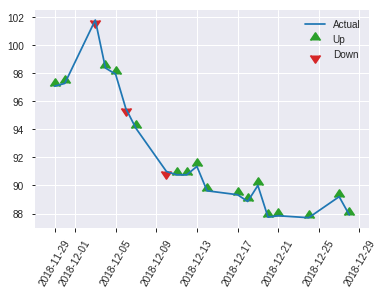


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21975920911413502
RMSE: 0.46878482176168523
LogLoss: 0.634035893498854
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 348.2966965690315
Residual deviance: 318.2860185364248
AIC: 2398.2860185364248
AUC: 0.6961220597584235
pr_auc: 0.6122115789734577
Gini: 0.3922441195168469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44542767743262224: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   57   0.4385   (57.0/130.0)
1      20   101  0.1653   (20.0/121.0)
Total  93   158  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445428     0.724014  157
max f2                       0.25319      0.836879  220
max f0point5                 0.445428     0.670651  157
max accuracy                 0.445428     0.693227  157
max precision                0.846106     1         0
max recall                   0.0251632    1         250
max specificity              0.846106     1         0
max absolute_mcc             0.445428     0.40998   157
max min_per_class_accuracy   0.503211     0.638462  124
max mean_per_class_accuracy  0.445428     0.698125  157

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.802019           1.38292   1.38292            0.666667         0.823903  0.666667                    0.823903            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.786209           1.38292   1.38292            0.666667         0.793213  0.666667                    0.808558            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.776963           2.07438   1.55579            1                0.78399   0.75                        0.802416            0.0165289       0.0495868                  107.438    55.5785
    4        0.0438247                   0.763736           0.69146   1.32006            0.333333         0.767046  0.636364                    0.79277             0.00826446      0.0578512                  -30.854    32.006
    5        0.0517928                   0.745663           1.03719   1.27654            0.5              0.758969  0.615385                    0.78757             0.00826446      0.0661157                  3.71901    27.6542
    6        0.103586                    0.691732           1.11697   1.19676            0.538462         0.709789  0.576923                    0.748679            0.0578512       0.123967                   11.6974    19.6758
    7        0.151394                    0.659176           1.55579   1.31013            0.75             0.674081  0.631579                    0.725122            0.0743802       0.198347                   55.5785    31.0135
    8        0.203187                    0.638918           1.27654   1.30157            0.615385         0.644398  0.627451                    0.704545            0.0661157       0.264463                   27.6542    30.1572
    9        0.302789                    0.594066           1.24463   1.28284            0.6              0.613797  0.618421                    0.674694            0.123967        0.38843                    24.4628    28.284
    10       0.40239                     0.544872           1.49355   1.335              0.72             0.570021  0.643564                    0.648785            0.14876         0.53719                    49.3554    33.4997
    11       0.501992                    0.502476           1.07868   1.28414            0.52             0.519425  0.619048                    0.623118            0.107438        0.644628                   7.86777    28.414
    12       0.601594                    0.45301            1.3276    1.29134            0.64             0.48171   0.622517                    0.599706            0.132231        0.77686                    32.7603    29.1336
    13       0.701195                    0.403752           0.995702  1.24934            0.48             0.433619  0.602273                    0.576114            0.0991736       0.876033                   -0.429752  24.9343
    14       0.800797                    0.30942            0.414876  1.14555            0.2              0.347562  0.552239                    0.547687            0.0413223       0.917355                   -58.5124   14.5553
    15       0.900398                    0.242615           0.580826  1.08308            0.28             0.278053  0.522124                    0.517861            0.0578512       0.975207                   -41.9174   8.30834
    16       1                           0.0251632          0.248926  1                  0.12             0.169043  0.482072                    0.483

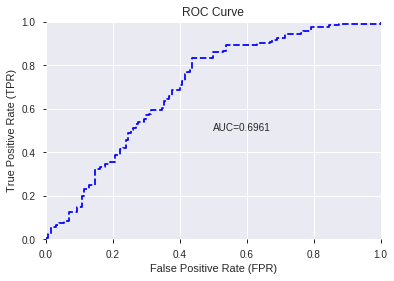

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


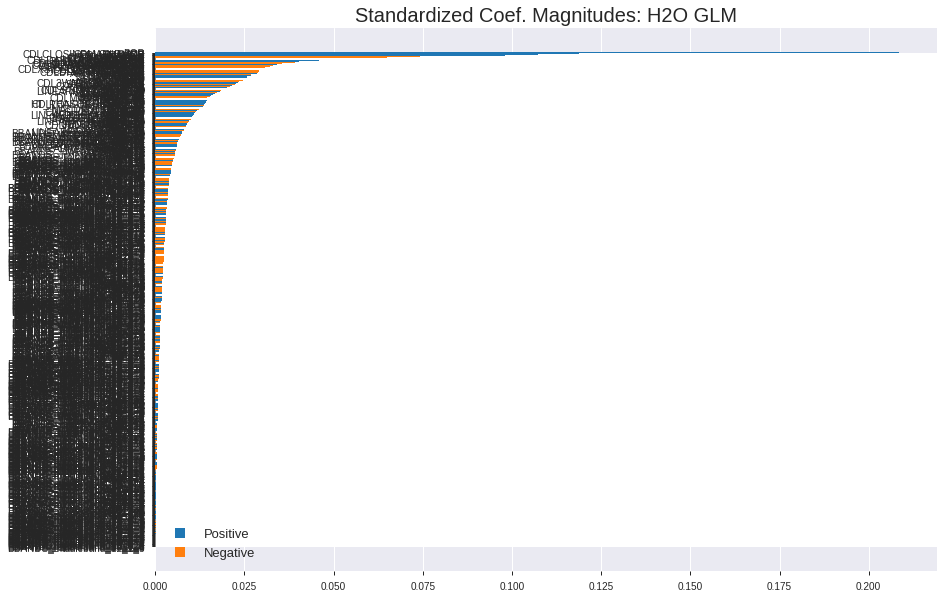

'log_likelihood'
--2019-08-25 15:25:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_152415_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_152415_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

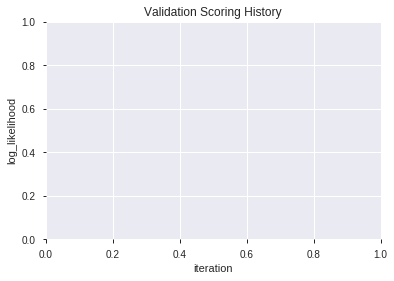

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_152521_model_5  0.727972  0.623407              0.279371  0.461214  0.212718
1  XGBoost_grid_1_AutoML_20190825_152521_model_1  0.724984  0.613393              0.298029  0.459937  0.211542
2  XGBoost_grid_1_AutoML_20190825_152521_model_7  0.718500  0.619202              0.294469  0.462347  0.213764
3  XGBoost_grid_1_AutoML_20190825_152521_model_4  0.718182  0.614099              0.348729  0.461053  0.212570
4  XGBoost_grid_1_AutoML_20190825_152521_model_3  0.717546  0.616810              0.308709  0.461828  0.213285
5  XGBoost_grid_1_AutoML_20190825_152521_model_2  0.717038  0.614807              0.320534  0.460977  0.212500
6  XGBoost_grid_1_AutoML_20190825_152521_model_6  0.716211  0.618495              0.337476  0.462449  0.213860
7               XGBoost_3_AutoML_20190825_152521  0.712079  0.619724              0.313128  0.463293  0.214640
8               XGBoost_2_AutoML_20190825_152521  0.704005  0.624856              0.314844  0.466628  0.217742
9               XGBoost_1_AutoML_20190825_152521  0.701653  0.630958              0.349301  0.468137  0.219152

variable  relative_importance  scaled_importance  percentage
0                        BOP          1294.598389           1.000000    0.049712
1                     Volume           536.678284           0.414552    0.020608
2               STOCHF_fastk           483.223297           0.373261    0.018555
3                       Open           403.654541           0.311799    0.015500
4                        SUB           386.676178           0.298684    0.014848
..                       ...                  ...                ...         ...
629                   SMA_14             0.657179           0.000508    0.000025
630              MIDPRICE_14             0.601199           0.000464    0.000023
631  BBANDS_middleband_8_6_4             0.500074           0.000386    0.000019
632  BBANDS_upperband_12_3_2             0.476294           0.000368    0.000018
633                 MAVP_8_1             0.380740           0.000294    0.000015

[634 rows x 4 columns]

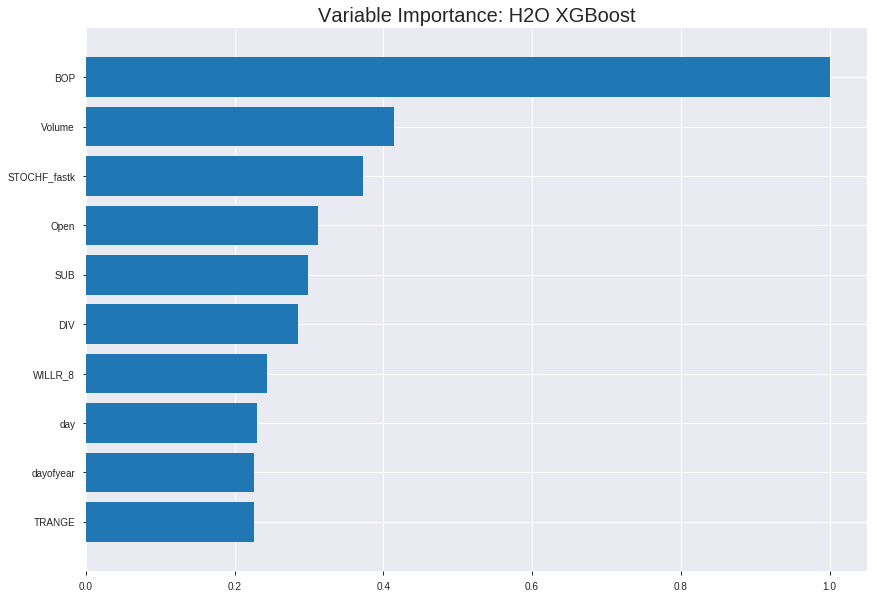

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_152521_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.021856034841016385
RMSE: 0.14783786673588192
LogLoss: 0.14418784085273817
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.997752808988764
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5542054176330566: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      863  0    0        (0.0/863.0)
1      0    890  0        (0.0/890.0)
Total  863  890  0        (0.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.554205     1        196
max f2                       0.554205     1        196
max f0point5                 0.554205     1        196
max accuracy                 0.554205     1        196
max precision                0.969735     1        0
max recall                   0.554205     1        196
max specificity              0.969735     1        0
max absolute_mcc             0.554205     1        196
max min_per_class_accuracy   0.554205     1        196
max mean_per_class_accuracy  0.554205     1        196

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.953645           1.96966   1.96966            1                0.959032   1                           0.959032            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.945676           1.96966   1.96966            1                0.949431   1                           0.954231            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.940922           1.96966   1.96966            1                0.943538   1                           0.950801            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.937242           1.96966   1.96966            1                0.938651   1                           0.947721            0.0202247       0.0797753                  96.9663   96.9663
    5        0.0501997                   0.933711           1.96966   1.96966            1                0.935084   1                           0.94528             0.0191011       0.0988764                  96.9663   96.9663
    6        0.100399                    0.921714           1.96966   1.96966            1                0.927587   1                           0.936433            0.0988764       0.197753                   96.9663   96.9663
    7        0.150029                    0.910938           1.96966   1.96966            1                0.916595   1                           0.929871            0.0977528       0.295506                   96.9663   96.9663
    8        0.200228                    0.899896           1.96966   1.96966            1                0.9055     1                           0.923761            0.0988764       0.394382                   96.9663   96.9663
    9        0.300057                    0.872656           1.96966   1.96966            1                0.886843   1                           0.911478            0.196629        0.591011                   96.9663   96.9663
    10       0.399886                    0.830224           1.96966   1.96966            1                0.854262   1                           0.897195            0.196629        0.78764                    96.9663   96.9663
    11       0.500285                    0.681306           1.96966   1.96966            1                0.782191   1                           0.874115            0.197753        0.985393                   96.9663   96.9663
    12       0.600114                    0.194951           0.146318  1.66635            0.0742857        0.281344   0.846008                    0.775508            0.0146067       1                          -85.3682  66.635
    13       0.699943                    0.138837           0         1.42869            0                0.164909   0.725346                    0.688422            0               1                          -100      42.8688
    14       0.799772                    0.101645           0         1.25036            0                0.11963    0.634807                    0.617424            0               1                          -100      25.0357
    15       0.899601                    0.0715549          0         1.1116             0                0.0862426  0.564363                    0.558479            0               1                          -100      11.1604
    16       1                           0.0310546          0         1                  0                0.0544282  0.507701                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.215449373826818
RMSE: 0.4641652440961279
LogLoss: 0.620272788620091
Mean Per-Class Error: 0.3293170434112509
AUC: 0.7119348831235551
pr_auc: 0.7276995666077887
Gini: 0.42386976624711026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2888054847717285: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      58   171  0.7467   (171.0/229.0)
1      15   257  0.0551   (15.0/272.0)
Total  73   428  0.3713   (186.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288805     0.734286  333
max f2                       0.168577     0.862846  364
max f0point5                 0.551808     0.698424  212
max accuracy                 0.551808     0.674651  212
max precision                0.952715     1         0
max recall                   0.0594709    1         397
max specificity              0.952715     1         0
max absolute_mcc             0.551808     0.342656  212
max min_per_class_accuracy   0.587336     0.663755  194
max mean_per_class_accuracy  0.551808     0.670683  212

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 55.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.919188           1.53493   1.53493            0.833333         0.932906  0.833333                    0.932906            0.0183824       0.0183824                  53.4926   53.4926
    2        0.0219561                   0.896134           1.84191   1.67447            1                0.904627  0.909091                    0.920052            0.0183824       0.0367647                  84.1912   67.4465
    3        0.0319361                   0.882659           1.84191   1.72679            1                0.889075  0.9375                      0.910371            0.0183824       0.0551471                  84.1912   72.6792
    4        0.0419162                   0.871422           1.84191   1.7542             1                0.876041  0.952381                    0.902197            0.0183824       0.0735294                  84.1912   75.4202
    5        0.0518962                   0.862094           1.10515   1.62938            0.6              0.865498  0.884615                    0.89514             0.0110294       0.0845588                  10.5147   62.9383
    6        0.101796                    0.815302           1.32618   1.48075            0.72             0.835809  0.803922                    0.866056            0.0661765       0.150735                   32.6176   48.0753
    7        0.151697                    0.770752           1.54721   1.50261            0.84             0.792454  0.815789                    0.841845            0.0772059       0.227941                   54.7206   50.2612
    8        0.201597                    0.74259            1.17882   1.42247            0.64             0.757743  0.772277                    0.821028            0.0588235       0.286765                   17.8824   42.2467
    9        0.301397                    0.706392           1.21566   1.35399            0.66             0.725582  0.735099                    0.789423            0.121324        0.408088                   21.5662   35.3988
    10       0.401198                    0.65671            1.28934   1.33791            0.7              0.681486  0.726368                    0.762573            0.128676        0.536765                   28.9338   33.7906
    11       0.500998                    0.596625           1.10515   1.29154            0.6              0.626576  0.701195                    0.735482            0.110294        0.647059                   10.5147   29.154
    12       0.600798                    0.524337           0.957794  1.2361             0.52             0.559271  0.671096                    0.706211            0.0955882       0.742647                   -4.22059  23.61
    13       0.700599                    0.448057           0.736765  1.16497            0.4              0.48526   0.632479                    0.674737            0.0735294       0.816176                   -26.3235  16.497
    14       0.800399                    0.339299           0.810441  1.12076            0.44             0.397057  0.608479                    0.640113            0.0808824       0.897059                   -18.9559  12.0764
    15       0.9002                      0.213179           0.663088  1.07002            0.36             0.285529  0.580931                    0.600802            0.0661765       0.963235                   -33.6912  7.00241
    16       1                           0.0486055          0.368382  1                  0.2              0.131817  0.542914                    0.553997            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:25:50  15.283 sec  0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.457086
    2019-08-25 15:25:52  16.554 sec  5                  0.442779         0.584288            0.972708        0.96509            1.96966          0.0838562                        0.488879           0.670991              0.644803          0.653594             1.53493            0.381238
    2019-08-25 15:25:52  17.241 sec  10                 0.392391         0.496192            0.994411        0.991104           1.96966          0.0347975                        0.481628           0.6565                0.663194          0.654463             1.22794            0.401198
    2019-08-25 15:25:53  17.957 sec  15                 0.347455         0.422842            0.999022        0.996793           1.96966          0.0154022                        0.474745           0.642464              0.686938          0.684165             1.22794            0.349301
    2019-08-25 15:25:54  18.713 sec  20                 0.309822         0.364262            0.999579        0.998469           1.96966          0.0108386                        0.470968           0.634472              0.692942          0.701487             1.53493            0.379242
    2019-08-25 15:25:55  19.429 sec  25                 0.277535         0.316399            0.999806        0.998686           1.96966          0.00456361                       0.470535           0.63325               0.687564          0.695019             1.53493            0.361277
    2019-08-25 15:25:55  20.157 sec  30                 0.25154          0.278896            0.999877        0.997632           1.96966          0.0034227                        0.46847            0.629006              0.692084          0.698118             1.53493            0.349301
    2019-08-25 15:25:56  20.885 sec  35                 0.22881          0.247413            0.999965        0.998842           1.96966          0.0022818                        0.466721           0.625192              0.696948          0.707127             1.53493            0.357285
    2019-08-25 15:25:57  21.678 sec  40                 0.208424         0.220011            0.999988        0.998865           1.96966          0.00171135                       0.464764           0.621039              0.704405          0.716373             1.53493            0.359281
    2019-08-25 15:25:58  22.413 sec  45                 0.190758         0.196819            0.999992        0.998869           1.96966          0.0011409                        0.463783           0.618887              0.709358          0.722967             1.53493            0.359281
    2019-08-25 15:25:58  23.171 sec  50                 0.175037         0.177092            0.999994        0.998871           1.96966          0.0011409                        0.46228            0.615759              0.713773          0.726868             1.84191            0.357285
    2019-08-25 15:25:59  23.963 sec  55                 0.163171         0.162785            0.999999        0.998875           1.96966          0.000570451                      0.463342           0.618115              0.710931          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1294.598388671875      1.0                     0.04971166554956243
Volume                   536.6782836914062      0.414551947837648       0.020608067783824808
STOCHF_fastk             483.2232971191406      0.37326116064062004     0.018555433980408
Open                     403.654541015625       0.31179904482171733     0.01550004983485024
SUB                      386.6761779785156      0.29868427256054725     0.014848092662444273
---                      ---                    ---                     ---
SMA_14                   0.6571786403656006     0.0005076312825012848   2.523519653819931e-05
MIDPRICE_14              0.6011993288993835     0.00046439060496294326  2.3085630438276802e-05
BBANDS_middleband_8_6_4  0.5000737905502319     0.00038627716126176883  1.9202481050079447e-05
BBANDS_upperband_12_3_2  0.47629398107528687    0.00036790867750416064  1.8289353128868656e-05
MAVP_8_1                 0.38073980808258057    0.0002940987810692245   1.4620140243047272e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7250996015936255)

('F1', 0.7360594795539034)

('auc', 0.727972027972028)

('logloss', 0.6234070094408738)

('mean_per_class_error', 0.27453909726636994)

('rmse', 0.46121356771286226)

('mse', 0.212717955042427)

xgboost prediction progress: |████████████████████████████████████████████| 100%


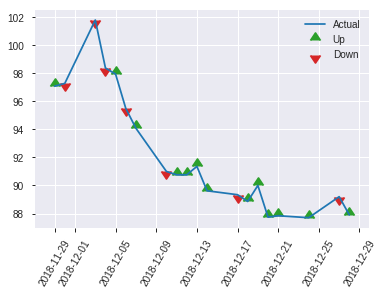


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.212717955042427
RMSE: 0.46121356771286226
LogLoss: 0.6234070094408738
Mean Per-Class Error: 0.27453909726636994
AUC: 0.727972027972028
pr_auc: 0.6330666850268483
Gini: 0.45594405594405596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4441411793231964: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   49   0.3769   (49.0/130.0)
1      22   99   0.1818   (22.0/121.0)
Total  103  148  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444141     0.736059  147
max f2                       0.0818058    0.834483  240
max f0point5                 0.509541     0.712     125
max accuracy                 0.509541     0.7251    125
max precision                0.92494      1         0
max recall                   0.0818058    1         240
max specificity              0.92494      1         0
max absolute_mcc             0.509541     0.450635  125
max min_per_class_accuracy   0.51698      0.719008  122
max mean_per_class_accuracy  0.509541     0.725461  125

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.919036           1.38292   1.38292            0.666667         0.921443  0.666667                    0.921443            0.0165289       0.0165289                  38.292    38.292
    2        0.0239044                   0.909615           1.38292   1.38292            0.666667         0.913105  0.666667                    0.917274            0.0165289       0.0330579                  38.292    38.292
    3        0.0318725                   0.874718           1.03719   1.29649            0.5              0.881415  0.625                       0.908309            0.00826446      0.0413223                  3.71901   29.6488
    4        0.0438247                   0.858772           1.38292   1.32006            0.666667         0.864421  0.636364                    0.89634             0.0165289       0.0578512                  38.292    32.006
    5        0.0517928                   0.849086           1.03719   1.27654            0.5              0.853342  0.615385                    0.889725            0.00826446      0.0661157                  3.71901   27.6542
    6        0.103586                    0.814074           0.797839  1.03719            0.384615         0.830438  0.5                         0.860081            0.0413223       0.107438                   -20.2161  3.71901
    7        0.151394                    0.740214           1.72865   1.25555            0.833333         0.769107  0.605263                    0.831353            0.0826446       0.190083                   72.865    25.5546
    8        0.203187                    0.712123           1.59568   1.34225            0.769231         0.728102  0.647059                    0.805034            0.0826446       0.272727                   59.5677   34.2246
    9        0.302789                    0.657651           1.3276    1.33743            0.64             0.686171  0.644737                    0.765934            0.132231        0.404959                   32.7603   33.7429
    10       0.40239                     0.580438           1.74248   1.43769            0.84             0.613423  0.693069                    0.728184            0.173554        0.578512                   74.2479   43.7689
    11       0.501992                    0.509541           1.57653   1.46524            0.76             0.537173  0.706349                    0.690285            0.157025        0.735537                   57.6529   46.5237
    12       0.601594                    0.427127           0.829752  1.36002            0.4              0.47622   0.655629                    0.654844            0.0826446       0.818182                   -17.0248  36.0024
    13       0.701195                    0.332158           0.497851  1.23756            0.24             0.36761   0.596591                    0.614043            0.0495868       0.867769                   -50.2149  23.7556
    14       0.800797                    0.225548           0.580826  1.15587            0.28             0.282318  0.557214                    0.572784            0.0578512       0.92562                    -41.9174  15.5874
    15       0.900398                    0.137847           0.497851  1.08308            0.24             0.174344  0.522124                    0.528709            0.0495868       0.975207                   -50.2149  8.30834
    16       1                           0.0329069          0.248926  1                  0.12             0.089434  0.482072                    0.484956            

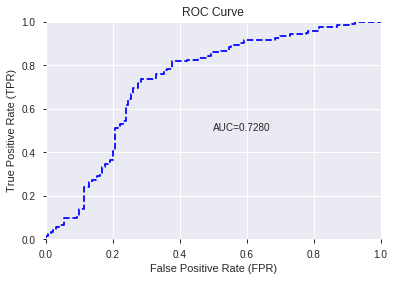

This function is available for GLM models only


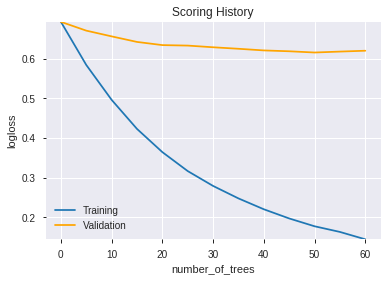

--2019-08-25 15:26:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_152521_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_152521_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_152616_model_5  0.711888  0.622854              0.326796  0.466026  0.217180
1  DeepLearning_grid_1_AutoML_20190825_152616_model_2  0.708837  0.686796              0.382200  0.483513  0.233784
2  DeepLearning_grid_1_AutoML_20190825_152616_model_9  0.707692  0.635463              0.301017  0.471674  0.222476
3  DeepLearning_grid_1_AutoML_20190825_152616_model_8  0.706612  0.619527              0.311125  0.462719  0.214108
4  DeepLearning_grid_1_AutoML_20190825_152616_model_7  0.706230  0.794205              0.323808  0.490976  0.241058
5  DeepLearning_grid_1_AutoML_20190825_152616_model_6  0.702034  0.657307              0.341322  0.479254  0.229684
6  DeepLearning_grid_1_AutoML_20190825_152616_model_3  0.701335  0.699814              0.324666  0.482741  0.233039
7               DeepLearning_1_AutoML_20190825_152616  0.684552  0.674112              0.339193  0.484547  0.234786
8  DeepLearning_grid_1_AutoML_20190825_152616_model_4  0.675334  0.826158              0.362270  0.512183  0.262332
9  DeepLearning_grid_1_AutoML_20190825_152616_model_1  0.672537  0.915761              0.397870  0.519535  0.269917

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.023770
1                   SUB             0.924691           0.924691    0.021980
2             CDL2CROWS             0.906075           0.906075    0.021538
3       CDLADVANCEBLOCK             0.903918           0.903918    0.021487
4    CDLEVENINGDOJISTAR             0.894214           0.894214    0.021256
5             CDLHAMMER             0.888605           0.888605    0.021123
6                  COSH             0.885688           0.885688    0.021053
7             CORREL_24             0.884028           0.884028    0.021014
8     CDL3WHITESOLDIERS             0.883935           0.883935    0.021012
9         CDLHIKKAKEMOD             0.883719           0.883719    0.021006
10    CDLSTALLEDPATTERN             0.880739           0.880739    0.020936
11       CDL3LINESTRIKE             0.878799           0.878799    0.020889
12            CDLONNECK             0.875918           0.875918    0.020821
13         weekday_name             0.866201           0.866201    0.020590
14                  day             0.860304           0.860304    0.020450
15              weekday             0.855988           0.855988    0.020347
16                 SINH             0.851238           0.851238    0.020234
17           aroonup_20             0.846034           0.846034    0.020111
18         CDLSHORTLINE             0.844047           0.844047    0.020063
19         aroondown_24             0.842459           0.842459    0.020026
20         aroondown_14             0.842302           0.842302    0.020022
21                  COS             0.841842           0.841842    0.020011
22                  EXP             0.839795           0.839795    0.019962
23               TRANGE             0.838962           0.838962    0.019943
24                  SIN             0.835408           0.835408    0.019858
25               SAREXT             0.834857           0.834857    0.019845
26          CDLLONGLINE             0.833489           0.833489    0.019812
27         HT_TRENDMODE             0.829497           0.829497    0.019718
28         aroondown_20             0.825575           0.825575    0.019624
29       STOCHRSI_fastk             0.824504           0.824504    0.019599
30       STOCHRSI_fastd             0.824346           0.824346    0.019595
31            CORREL_30             0.822724           0.822724    0.019557
32    CDLDARKCLOUDCOVER             0.821307           0.821307    0.019523
33           AROONOSC_8             0.819378           0.819378    0.019477
34       CDLEVENINGSTAR             0.817598           0.817598    0.019435
35  CDLGAPSIDESIDEWHITE             0.817031           0.817031    0.019421
36        days_in_month             0.816062           0.816062    0.019398
37                  DIV             0.813916           0.813916    0.019347
38               ULTOSC             0.811241           0.811241    0.019284
39            dayofweek             0.808931           0.808931    0.019229
40         CDLENGULFING             0.803424           0.803424    0.019098
41         STOCHF_fastk             0.801254           0.801254    0.019046
42         aroondown_12             0.799701           0.799701    0.019009
43          AROONOSC_14             0.796142           0.796142    0.018925
44              WILLR_8             0.794643           0.794643    0.018889
45           aroonup_12             0.792197           0.792197    0.018831
46            aroonup_8             0.785397           0.785397    0.018669
47             CORREL_8             0.776703           0.776703    0.018463
48             WILLR_12             0.776335           0.776335    0.018454
49   CDLCLOSINGMARUBOZU             0.767861           0.767861    0.018252

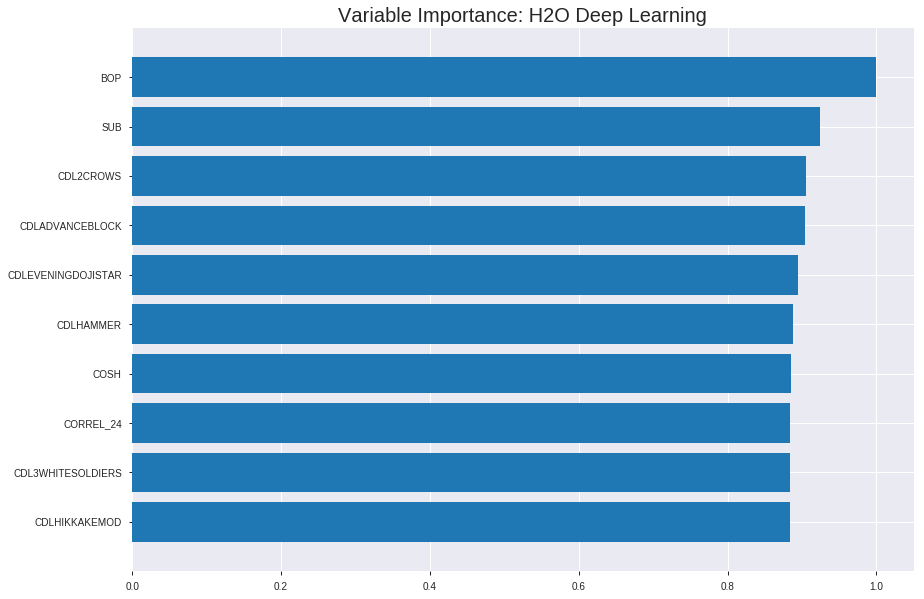

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_152616_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19775513312860907
RMSE: 0.4446966754188849
LogLoss: 0.5758104534465107
Mean Per-Class Error: 0.30664132175452763
AUC: 0.7616961995651439
pr_auc: 0.751171908519248
Gini: 0.5233923991302878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2493090502673816: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      290  573   0.664    (573.0/863.0)
1      40   850   0.0449   (40.0/890.0)
Total  330  1423  0.3497   (613.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249309     0.734976  311
max f2                       0.212308     0.855302  325
max f0point5                 0.526149     0.700326  192
max accuracy                 0.526149     0.693098  192
max precision                0.969649     1         0
max recall                   0.0742739    1         382
max specificity              0.969649     1         0
max absolute_mcc             0.526149     0.386823  192
max min_per_class_accuracy   0.511533     0.692932  198
max mean_per_class_accuracy  0.526149     0.693359  192

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.927048           1.86024   1.86024            0.944444         0.946636   0.944444                    0.946636            0.0191011       0.0191011                  86.0237   86.0237
    2        0.0205362                   0.912971           1.96966   1.91495            1                0.919539   0.972222                    0.933088            0.0202247       0.0393258                  96.9663   91.495
    3        0.0302339                   0.901171           1.62208   1.82101            0.823529         0.90693    0.924528                    0.924697            0.0157303       0.0550562                  62.2075   82.1009
    4        0.040502                    0.891349           1.75081   1.80321            0.888889         0.895593   0.915493                    0.917319            0.0179775       0.0730337                  75.0811   80.3213
    5        0.0501997                   0.869009           1.62208   1.76822            0.823529         0.881135   0.897727                    0.910329            0.0157303       0.088764                   62.2075   76.822
    6        0.100399                    0.820622           1.52201   1.64512            0.772727         0.842668   0.835227                    0.876498            0.0764045       0.165169                   52.2012   64.5116
    7        0.150029                    0.784273           1.60743   1.63265            0.816092         0.801293   0.828897                    0.85162             0.0797753       0.244944                   60.7426   63.2648
    8        0.200228                    0.747951           1.56678   1.61613            0.795455         0.763599   0.820513                    0.829552            0.0786517       0.323596                   56.6777   61.6134
    9        0.300057                    0.666442           1.24933   1.4941             0.634286         0.70967    0.758555                    0.789668            0.124719        0.448315                   24.9329   49.4098
    10       0.399886                    0.590617           1.20431   1.42175            0.611429         0.626512   0.721826                    0.748937            0.120225        0.568539                   20.4308   42.1754
    11       0.500285                    0.514296           1.19747   1.37674            0.607955         0.551629   0.698974                    0.70934             0.120225        0.688764                   19.7466   37.6743
    12       0.600114                    0.435016           0.911673  1.29938            0.462857         0.472803   0.659696                    0.669992            0.0910112       0.779775                   -8.83274  29.9378
    13       0.699943                    0.360136           0.866652  1.23766            0.44             0.395409   0.628362                    0.63083             0.0865169       0.866292                   -13.3348  23.7661
    14       0.799772                    0.261516           0.787865  1.18152            0.4              0.312623   0.599857                    0.591111            0.0786517       0.944944                   -21.2135  18.1517
    15       0.899601                    0.150898           0.393933  1.09412            0.2              0.205017   0.555485                    0.548266            0.0393258       0.98427                    -60.6067  9.41184
    16       1                           0.00945642         0.156678  1                  0.0795455        0.0940407  0.507701                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22191449020678305
RMSE: 0.47107800862148413
LogLoss: 0.6385710225177132
Mean Per-Class Error: 0.34448850500899053
AUC: 0.6979996146930388
pr_auc: 0.7056138823849384
Gini: 0.3959992293860777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24637615702115048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   173  0.7555   (173.0/229.0)
1      9    263  0.0331   (9.0/272.0)
Total  65   436  0.3633   (182.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.246376     0.742938  341
max f2                       0.219171     0.86645   350
max f0point5                 0.508385     0.684605  232
max accuracy                 0.508385     0.662675  232
max precision                0.969345     1         0
max recall                   0.044137     1         397
max specificity              0.969345     1         0
max absolute_mcc             0.508385     0.315852  232
max min_per_class_accuracy   0.571462     0.637555  200
max mean_per_class_accuracy  0.508385     0.655511  232

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 54.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.95154            1.84191   1.84191            1                0.95956   1                           0.95956             0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.926615           1.10515   1.50702            0.6              0.936301  0.818182                    0.948988            0.0110294       0.0330882                  10.5147   50.7019
    3        0.0319361                   0.909926           1.10515   1.38143            0.6              0.918887  0.75                        0.939581            0.0110294       0.0441176                  10.5147   38.1434
    4        0.0419162                   0.892794           1.47353   1.40336            0.8              0.902123  0.761905                    0.930663            0.0147059       0.0588235                  47.3529   40.3361
    5        0.0518962                   0.886138           1.47353   1.41686            0.8              0.889765  0.769231                    0.922798            0.0147059       0.0735294                  47.3529   41.6855
    6        0.101796                    0.843682           1.47353   1.44464            0.8              0.861586  0.784314                    0.892792            0.0735294       0.147059                   47.3529   44.4637
    7        0.151697                    0.810229           1.54721   1.47838            0.84             0.829219  0.802632                    0.87188             0.0772059       0.224265                   54.7206   47.8377
    8        0.201597                    0.780581           1.2525    1.42247            0.68             0.794785  0.772277                    0.852797            0.0625          0.286765                   25.25     42.2467
    9        0.301397                    0.708529           1.10515   1.31739            0.6              0.736357  0.715232                    0.814241            0.110294        0.397059                   10.5147   31.7394
    10       0.401198                    0.642701           1.14199   1.27376            0.62             0.675513  0.691542                    0.779731            0.113971        0.511029                   14.1985   27.376
    11       0.500998                    0.578953           1.14199   1.24751            0.62             0.610038  0.677291                    0.745928            0.113971        0.625                      14.1985   24.751
    12       0.600798                    0.505065           1.17882   1.2361             0.64             0.541316  0.671096                    0.711939            0.117647        0.742647                   17.8824   23.61
    13       0.700599                    0.397451           0.663088  1.15447            0.36             0.455131  0.626781                    0.675357            0.0661765       0.808824                   -33.6912  15.4475
    14       0.800399                    0.305618           0.920956  1.12536            0.5              0.348181  0.610973                    0.634562            0.0919118       0.900735                   -7.90441  12.5358
    15       0.9002                      0.20333            0.773603  1.08636            0.42             0.258322  0.5898                      0.59285             0.0772059       0.977941                   -22.6397  8.63604
    16       1                           0.0267268          0.221029  1                  0.12             0.123153  0.542914                    0.545974            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:29:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:29:42  1 min 45.227 sec  1141 obs/sec      1.28066   1             2245       0.444697         0.57581             0.208792       0.761696        0.751172           1.86024          0.349686                         0.471078           0.638571              0.105755         0.698             0.705614             1.84191            0.363273
    2019-08-25 15:29:49  1 min 52.454 sec  1876 obs/sec      9.06218   7             15886      0.442977         0.567705            0.214899       0.795963        0.792396           1.96966          0.307473                         0.485968           0.693556              0.0483297        0.692967          0.702129             1.22794            0.359281
    2019-08-25 15:29:57  1 min 59.918 sec  2100 obs/sec      18.2059   14            31915      0.413026         0.502306            0.317476       0.825992        0.823602           1.96966          0.276669                         0.480025           0.693065              0.071464         0.684666          0.681841             1.53493            0.355289
    2019-08-25 15:30:05  2 min  7.837 sec  2237 obs/sec      28.5722   22            50087      0.393949         0.459725            0.37907        0.854114        0.855245           1.96966          0.27838                          0.486686           0.740219              0.0455157        0.680187          0.685473             1.53493            0.361277
    2019-08-25 15:30:12  2 min 15.517 sec  2329 obs/sec      38.9829   30            68337      0.378429         0.424651            0.427031       0.877601        0.870346           1.96966          0.22761                          0.491471           0.805639              0.0266543        0.673597          0.662171             1.22794            0.347305
    2019-08-25 15:30:20  2 min 23.113 sec  2388 obs/sec      49.3309   38            86477      0.368922         0.410446            0.455458       0.895           0.862875           1.96966          0.216201                         0.503183           0.914945              -0.020287        0.66557           0.655282             1.53493            0.37525
    2019-08-25 15:30:21  2 min 23.845 sec  2386 obs/sec      49.3309   38            86477      0.444697         0.57581             0.208792       0.761696        0.751172           1.86024          0.349686                         0.471078           0.638571              0.105755         0.698             0.705614             1.84191            0.363273

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.023770460326429436
SUB                 0.9246906638145447     0.9246906638145447   0.021980322738423333
CDL2CROWS           0.9060748815536499     0.9060748815536499   0.021537817024745283
CDLADVANCEBLOCK     0.9039180874824524     0.9039180874824524   0.021486549036843605
CDLEVENINGDOJISTAR  0.8942140936851501     0.8942140936851501   0.021255880637276917
---                 ---                    ---                  ---
aroonup_12          0.7921965718269348     0.7921965718269348   0.01883087718134556
aroonup_8           0.7853969931602478     0.7853969931602478   0.018669248066412642
CORREL_8            0.7767026424407959     0.7767026424407959   0.018462579347571846
WILLR_12            0.7763350009918213     0.7763350009918213   0.018453840341094645
CDLCLOSINGMARUBOZU  0.7678613662719727     0.7678613662719727   0.018252418143165826


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6693227091633466)

('F1', 0.72)

('auc', 0.7118881118881119)

('logloss', 0.6228535848175091)

('mean_per_class_error', 0.3238080101716465)

('rmse', 0.4660261101776808)

('mse', 0.21718033536733988)

deeplearning prediction progress: |███████████████████████████████████████| 100%


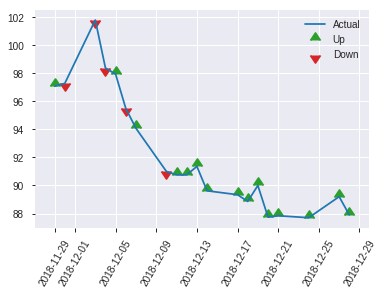


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21718033536733988
RMSE: 0.4660261101776808
LogLoss: 0.6228535848175091
Mean Per-Class Error: 0.3238080101716465
AUC: 0.7118881118881119
pr_auc: 0.6516815866652966
Gini: 0.4237762237762237
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3251270514438541: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   71   0.5462   (71.0/130.0)
1      13   108  0.1074   (13.0/121.0)
Total  72   179  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325127     0.72      178
max f2                       0.171949     0.841584  222
max f0point5                 0.348313     0.648949  171
max accuracy                 0.348313     0.669323  171
max precision                0.934037     1         0
max recall                   0.069751     1         243
max specificity              0.934037     1         0
max absolute_mcc             0.325127     0.382701  178
max min_per_class_accuracy   0.499122     0.644628  123
max mean_per_class_accuracy  0.348313     0.676192  171

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.911055           2.07438   2.07438            1                0.924071   1                           0.924071            0.0247934       0.0247934                  107.438   107.438
    2        0.0239044                   0.889069           0.69146   1.38292            0.333333         0.896062   0.666667                    0.910066            0.00826446      0.0330579                  -30.854   38.292
    3        0.0318725                   0.863182           2.07438   1.55579            1                0.868503   0.75                        0.899676            0.0165289       0.0495868                  107.438   55.5785
    4        0.0438247                   0.84988            2.07438   1.69722            1                0.854735   0.818182                    0.887419            0.0247934       0.0743802                  107.438   69.722
    5        0.0517928                   0.842973           1.03719   1.59568            0.5              0.846048   0.769231                    0.881054            0.00826446      0.0826446                  3.71901   59.5677
    6        0.103586                    0.791521           1.43611   1.51589            0.692308         0.811971   0.730769                    0.846513            0.0743802       0.157025                   43.6109   51.5893
    7        0.151394                    0.753838           1.72865   1.58308            0.833333         0.770371   0.763158                    0.822468            0.0826446       0.239669                   72.865    58.308
    8        0.203187                    0.695777           0.957406  1.42359            0.461538         0.726414   0.686275                    0.797984            0.0495868       0.289256                   -4.25938  42.3594
    9        0.302789                    0.637942           1.16165   1.33743            0.56             0.663501   0.644737                    0.753746            0.115702        0.404959                   16.1653   33.7429
    10       0.40239                     0.58427            1.24463   1.31446            0.6              0.612394   0.633663                    0.718758            0.123967        0.528926                   24.4628   31.4459
    11       0.501992                    0.493067           1.16165   1.28414            0.56             0.534127   0.619048                    0.682125            0.115702        0.644628                   16.1653   28.414
    12       0.601594                    0.404416           1.24463   1.2776             0.6              0.453462   0.615894                    0.644267            0.123967        0.768595                   24.4628   27.7598
    13       0.701195                    0.330069           1.07868   1.24934            0.52             0.366525   0.602273                    0.604815            0.107438        0.876033                   7.86777   24.9343
    14       0.800797                    0.25599            0.663802  1.17651            0.32             0.296857   0.567164                    0.566511            0.0661157       0.942149                   -33.6198  17.6514
    15       0.900398                    0.146367           0.414876  1.09226            0.2              0.203838   0.526549                    0.526393            0.0413223       0.983471                   -58.5124  9.22621
    16       1                           0.0253681          0.16595   1                  0.08             0.0870772  0.482072                    0.4

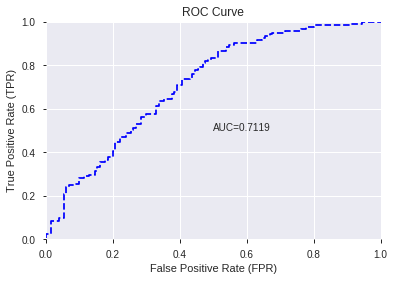

This function is available for GLM models only


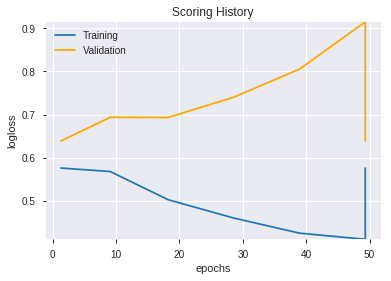

--2019-08-25 15:35:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_152616_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_152616_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'CDL2CROWS',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLHAMMER',
 'COSH',
 'CORREL_24',
 'CDL3WHITESOLDIERS',
 'CDLHIKKAKEMOD',
 'CDLSTALLEDPATTERN',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'weekday_name',
 'day',
 'weekday',
 'SINH',
 'aroonup_20',
 'CDLSHORTLINE',
 'aroondown_24',
 'aroondown_14',
 'COS',
 'EXP',
 'TRANGE',
 'SIN',
 'SAREXT',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'aroondown_20',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CORREL_30',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_8',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'DIV',
 'ULTOSC',
 'dayofweek',
 'CDLENGULFING',
 'STOCHF_fastk',
 'aroondown_12',
 'AROONOSC_14',
 'WILLR_8',
 'aroonup_12',
 'aroonup_8',
 'CORREL_8',
 'WILLR_12',
 'CDLCLOSINGMARUBOZU']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_153536_model_1  0.708201  0.61308              0.300159  0.462051  0.213491

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.319893           1.000000    0.107763
1                   SUB             0.171800           0.537056    0.057875
2             CDLHAMMER             0.159312           0.498017    0.053668
3           CDLLONGLINE             0.154729           0.483690    0.052124
4                TRANGE             0.152496           0.476711    0.051372
5    CDLCLOSINGMARUBOZU             0.146365           0.457545    0.049306
6          STOCHF_fastk             0.120387           0.376335    0.040555
7               WILLR_8             0.088422           0.276412    0.029787
8        STOCHRSI_fastd             0.082895           0.259132    0.027925
9              WILLR_12             0.079575           0.248755    0.026807
10         HT_TRENDMODE             0.074139           0.231762    0.024975
11           aroonup_20             0.072229           0.225791    0.024332
12         CDLSHORTLINE             0.067929           0.212348    0.022883
13    CDLDARKCLOUDCOVER             0.065062           0.203386    0.021918
14               ULTOSC             0.058898           0.184119    0.019841
15         CDLENGULFING             0.058470           0.182781    0.019697
16            aroonup_8             0.058086           0.181580    0.019568
17            CDLONNECK             0.055096           0.172232    0.018560
18         aroondown_24             0.054816           0.171358    0.018466
19         aroondown_14             0.053537           0.167359    0.018035
20      CDLADVANCEBLOCK             0.053102           0.166000    0.017889
21               SAREXT             0.051920           0.162304    0.017490
22         aroondown_20             0.051373           0.160593    0.017306
23       CDLEVENINGSTAR             0.050675           0.158413    0.017071
24          AROONOSC_14             0.048771           0.152460    0.016430
25            CORREL_30             0.047771           0.149335    0.016093
26           AROONOSC_8             0.044722           0.139803    0.015066
27                  EXP             0.037810           0.118196    0.012737
28                 SINH             0.037784           0.118115    0.012728
29                 COSH             0.037782           0.118109    0.012728
30            dayofweek             0.034211           0.106946    0.011525
31              weekday             0.034149           0.106751    0.011504
32    CDL3WHITESOLDIERS             0.033217           0.103837    0.011190
33         aroondown_12             0.031294           0.097826    0.010542
34       STOCHRSI_fastk             0.029895           0.093453    0.010071
35                  SIN             0.029558           0.092399    0.009957
36           aroonup_12             0.027603           0.086290    0.009299
37                  day             0.027113           0.084756    0.009134
38            CDL2CROWS             0.026004           0.081291    0.008760
39         weekday_name             0.022346           0.069855    0.007528
40        CDLHIKKAKEMOD             0.017775           0.055566    0.005988
41        days_in_month             0.016778           0.052448    0.005652
42                  COS             0.016579           0.051826    0.005585
43   CDLEVENINGDOJISTAR             0.015400           0.048141    0.005188
44            CORREL_24             0.013320           0.041639    0.004487
45                  DIV             0.010797           0.033752    0.003637
46       CDL3LINESTRIKE             0.010428           0.032598    0.003513
47  CDLGAPSIDESIDEWHITE             0.009669           0.030225    0.003257
48    CDLSTALLEDPATTERN             0.004944           0.015455    0.001665
49             CORREL_8             0.001556           0.004865    0.000524

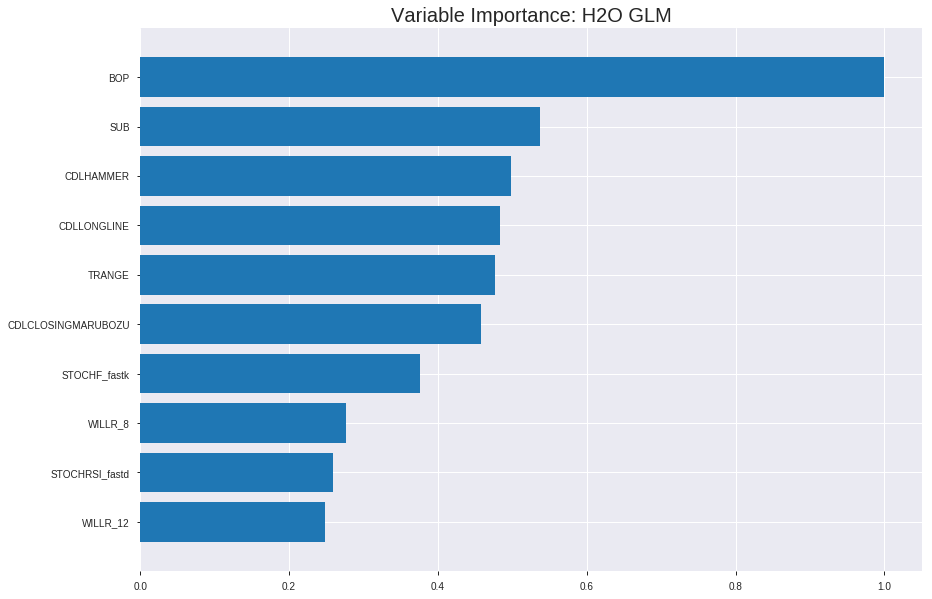

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_153536_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19976808535658946
RMSE: 0.44695423183653765
LogLoss: 0.583680247497053
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2429.7581400712443
Residual deviance: 2046.3829477246682
AIC: 2148.382947724668
AUC: 0.75974455453279
pr_auc: 0.7498133376312123
Gini: 0.51948910906558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35941988385028567: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      326  537   0.6222   (537.0/863.0)
1      65   825   0.073    (65.0/890.0)
Total  391  1362  0.3434   (602.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35942      0.732682  282
max f2                       0.29753      0.850387  309
max f0point5                 0.528259     0.698409  184
max accuracy                 0.474401     0.694809  219
max precision                0.919846     1         0
max recall                   0.115808     1         383
max specificity              0.919846     1         0
max absolute_mcc             0.474401     0.393104  219
max min_per_class_accuracy   0.51803      0.688764  190
max mean_per_class_accuracy  0.474401     0.693497  219

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.862119           1.86024   1.86024            0.944444         0.883954  0.944444                    0.883954            0.0191011       0.0191011                  86.0237    86.0237
    2        0.0205362                   0.84449            1.75081   1.80552            0.888889         0.853274  0.916667                    0.868614            0.0179775       0.0370787                  75.0811    80.5524
    3        0.0302339                   0.829793           1.8538    1.82101            0.941176         0.836585  0.924528                    0.85834             0.0179775       0.0550562                  85.38      82.1009
    4        0.040502                    0.812859           1.86024   1.83095            0.944444         0.820864  0.929577                    0.848839            0.0191011       0.0741573                  86.0237    83.0954
    5        0.0501997                   0.800475           1.50621   1.76822            0.764706         0.806177  0.897727                    0.840598            0.0146067       0.088764                   50.6213    76.822
    6        0.100399                    0.75125            1.63392   1.70107            0.829545         0.775397  0.863636                    0.807997            0.0820225       0.170787                   63.3925    70.1073
    7        0.150029                    0.717355           1.40367   1.60269            0.712644         0.732664  0.813688                    0.783077            0.0696629       0.240449                   40.3668    60.2692
    8        0.200228                    0.683981           1.45486   1.56563            0.738636         0.701379  0.794872                    0.762594            0.0730337       0.313483                   45.4865    56.563
    9        0.300057                    0.624496           1.42941   1.52031            0.725714         0.652743  0.771863                    0.726047            0.142697        0.45618                    42.9413    52.031
    10       0.399886                    0.570102           1.1818    1.4358             0.6              0.594855  0.728959                    0.693296            0.117978        0.574157                   18.1798    43.5803
    11       0.500285                    0.517603           1.11913   1.37225            0.568182         0.54425   0.696693                    0.663384            0.11236         0.686517                   11.9127    37.2251
    12       0.600114                    0.467644           0.990459  1.30874            0.502857         0.492693  0.664449                    0.63499             0.0988764       0.785393                   -0.954093  30.874
    13       0.699943                    0.410154           0.77661   1.23285            0.394286         0.440354  0.625917                    0.60723             0.0775281       0.862921                   -22.339    23.2845
    14       0.799772                    0.334259           0.77661   1.1759             0.394286         0.375568  0.597004                    0.578314            0.0775281       0.940449                   -22.339    17.5897
    15       0.899601                    0.229687           0.382677  1.08787            0.194286         0.283964  0.552315                    0.54565             0.0382022       0.978652                   -61.7323   8.78734
    16       1                           0.0335823          0.212634  1                  0.107955         0.167675  0.507701                    0.50



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2161507150268174
RMSE: 0.4649201168231134
LogLoss: 0.6202307259527403
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.327648451823
Residual deviance: 621.4711874046458
AIC: 723.4711874046458
AUC: 0.7000545851528385
pr_auc: 0.7146000740857523
Gini: 0.40010917030567694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33293777120888485: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   166  0.7249   (166.0/229.0)
1      12   260  0.0441   (12.0/272.0)
Total  75   426  0.3553   (178.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.332938     0.744986  329
max f2                       0.205371     0.863724  376
max f0point5                 0.512321     0.692568  237
max accuracy                 0.512321     0.672655  237
max precision                0.930387     1         0
max recall                   0.174882     1         386
max specificity              0.930387     1         0
max absolute_mcc             0.512321     0.336056  237
max min_per_class_accuracy   0.557458     0.633188  203
max mean_per_class_accuracy  0.512321     0.665048  237

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.870418           1.84191   1.84191            1                0.901322  1                           0.901322            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.851455           1.47353   1.67447            0.8              0.862965  0.909091                    0.883887            0.0147059       0.0367647                  47.3529   67.4465
    3        0.0319361                   0.837723           1.84191   1.72679            1                0.842195  0.9375                      0.870858            0.0183824       0.0551471                  84.1912   72.6792
    4        0.0419162                   0.83071            1.10515   1.57878            0.6              0.834124  0.857143                    0.862112            0.0110294       0.0661765                  10.5147   57.8782
    5        0.0518962                   0.823268           1.84191   1.62938            1                0.824655  0.884615                    0.854909            0.0183824       0.0845588                  84.1912   62.9383
    6        0.101796                    0.784011           1.32618   1.48075            0.72             0.802987  0.803922                    0.829457            0.0661765       0.150735                   32.6176   48.0753
    7        0.151697                    0.74939            1.32618   1.42991            0.72             0.764634  0.776316                    0.808134            0.0661765       0.216912                   32.6176   42.9905
    8        0.201597                    0.723342           1.10515   1.34952            0.6              0.733426  0.732673                    0.789642            0.0551471       0.272059                   10.5147   34.952
    9        0.301397                    0.660834           1.28934   1.32959            0.7              0.689224  0.721854                    0.756391            0.128676        0.400735                   28.9338   32.9592
    10       0.401198                    0.609566           1.03147   1.25543            0.56             0.632097  0.681592                    0.725472            0.102941        0.503676                   3.14706   25.5432
    11       0.500998                    0.562083           1.14199   1.23283            0.62             0.581899  0.669323                    0.696872            0.113971        0.617647                   14.1985   23.2833
    12       0.600798                    0.514394           1.32618   1.24834            0.72             0.535656  0.677741                    0.670092            0.132353        0.75                       32.6176   24.8339
    13       0.700599                    0.450206           0.663088  1.16497            0.36             0.485118  0.632479                    0.643742            0.0661765       0.816176                   -33.6912  16.497
    14       0.800399                    0.373356           0.920956  1.13454            0.5              0.414239  0.61596                     0.615126            0.0919118       0.908088                   -7.90441  13.4544
    15       0.9002                      0.286669           0.62625   1.07819            0.34             0.329623  0.585366                    0.583474            0.0625          0.970588                   -37.375   7.81923
    16       1                           0.0743756          0.294706  1                  0.16             0.199753  0.542914                    0.545178           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:35:37  0.000 sec   2            19        51            1.37006           1.37018
    2019-08-25 15:35:37  0.011 sec   4            12        51            1.36148           1.36294
    2019-08-25 15:35:37  0.022 sec   6            7.2       51            1.34916           1.35265
    2019-08-25 15:35:37  0.033 sec   8            4.4       51            1.3324            1.33894
    2019-08-25 15:35:37  0.043 sec   10           2.8       51            1.31108           1.322
    2019-08-25 15:35:37  0.056 sec   12           1.7       51            1.28613           1.30297
    2019-08-25 15:35:37  0.066 sec   14           1.1       51            1.25955           1.28393
    2019-08-25 15:35:37  0.077 sec   16           0.66      51            1.23382           1.26709
    2019-08-25 15:35:37  0.100 sec   18           0.41      51            1.21109           1.25417
    2019-08-25 15:35:37  0.110 sec   20           0.26      51            1.19248           1.24577
    2019-08-25 15:35:37  0.121 sec   22           0.16      51            1.17811           1.24152
    2019-08-25 15:35:37  0.131 sec   24           0.098     51            1.16736           1.24046
    2019-08-25 15:35:37  0.142 sec   26           0.061     51            1.15943           1.24158
    2019-08-25 15:35:37  0.152 sec   28           0.038     51            1.15363           1.2441
    2019-08-25 15:35:37  0.165 sec   30           0.024     51            1.14948           1.24744
    2019-08-25 15:35:37  0.179 sec   32           0.015     51            1.14664           1.25122
    2019-08-25 15:35:37  0.190 sec   34           0.0091    51            1.14481           1.25519

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7353951890034365)

('auc', 0.7082008900190718)

('logloss', 0.6130800403574722)

('mean_per_class_error', 0.30015893197711385)

('rmse', 0.4620509381046867)

('mse', 0.21349106940342102)

glm prediction progress: |████████████████████████████████████████████████| 100%


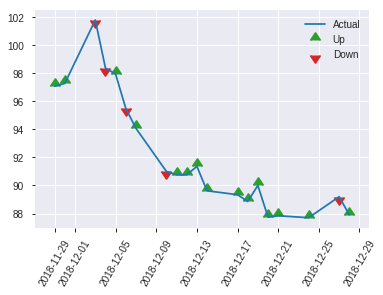


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21349106940342102
RMSE: 0.4620509381046867
LogLoss: 0.6130800403574722
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.2966965690315
Residual deviance: 307.76618025945106
AIC: 409.76618025945106
AUC: 0.7082008900190718
pr_auc: 0.6353270974442841
Gini: 0.41640178003814365
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930357586085634: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   63   0.4846   (63.0/130.0)
1      14   107  0.1157   (14.0/121.0)
Total  81   170  0.3068   (77.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393036     0.735395  169
max f2                       0.263548     0.847578  217
max f0point5                 0.393036     0.667915  169
max accuracy                 0.393036     0.693227  169
max precision                0.859612     1         0
max recall                   0.203392     1         230
max specificity              0.859612     1         0
max absolute_mcc             0.393036     0.427181  169
max min_per_class_accuracy   0.518025     0.646154  124
max mean_per_class_accuracy  0.393036     0.699841  169

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.840505           2.07438    2.07438            1                0.852495  1                           0.852495            0.0247934       0.0247934                  107.438   107.438
    2        0.0239044                   0.836345           1.38292    1.72865            0.666667         0.836951  0.833333                    0.844723            0.0165289       0.0413223                  38.292    72.865
    3        0.0318725                   0.80304            1.03719    1.55579            0.5              0.816397  0.75                        0.837641            0.00826446      0.0495868                  3.71901   55.5785
    4        0.0438247                   0.77714            0.69146    1.32006            0.333333         0.79105   0.636364                    0.824935            0.00826446      0.0578512                  -30.854   32.006
    5        0.0517928                   0.773218           2.07438    1.43611            1                0.77465   0.692308                    0.817199            0.0165289       0.0743802                  107.438   43.6109
    6        0.103586                    0.71362            1.11697    1.27654            0.538462         0.736305  0.615385                    0.776752            0.0578512       0.132231                   11.6974   27.6542
    7        0.151394                    0.684813           1.38292    1.31013            0.666667         0.699816  0.631579                    0.752456            0.0661157       0.198347                   38.292    31.0135
    8        0.203187                    0.645945           1.75524    1.42359            0.846154         0.664021  0.686275                    0.729914            0.0909091       0.289256                   75.5245   42.3594
    9        0.302789                    0.612077           0.912727   1.25555            0.44             0.62751   0.605263                    0.696228            0.0909091       0.380165                   -8.72727  25.5546
    10       0.40239                     0.565755           1.41058    1.29392            0.68             0.59104   0.623762                    0.670192            0.140496        0.520661                   41.0579   29.392
    11       0.501992                    0.51548            1.41058    1.31707            0.68             0.538628  0.634921                    0.644088            0.140496        0.661157                   41.0579   31.7067
    12       0.601594                    0.458543           1.16165    1.29134            0.56             0.481441  0.622517                    0.617159            0.115702        0.77686                    16.1653   29.1336
    13       0.701195                    0.375992           1.16165    1.27292            0.56             0.419524  0.613636                    0.589086            0.115702        0.892562                   16.1653   27.2915
    14       0.800797                    0.319532           0.414876   1.16619            0.2              0.347021  0.562189                    0.558979            0.0413223       0.933884                   -58.5124  16.6194
    15       0.900398                    0.223497           0.580826   1.10144            0.28             0.274515  0.530973                    0.527511            0.0578512       0.991736                   -41.9174  10.1441
    16       1                           0.0419221          0.0829752  1                  0.04             0.154239  0.482072                    0.

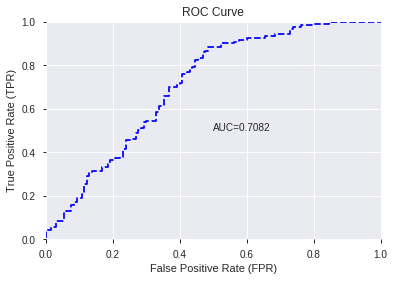

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


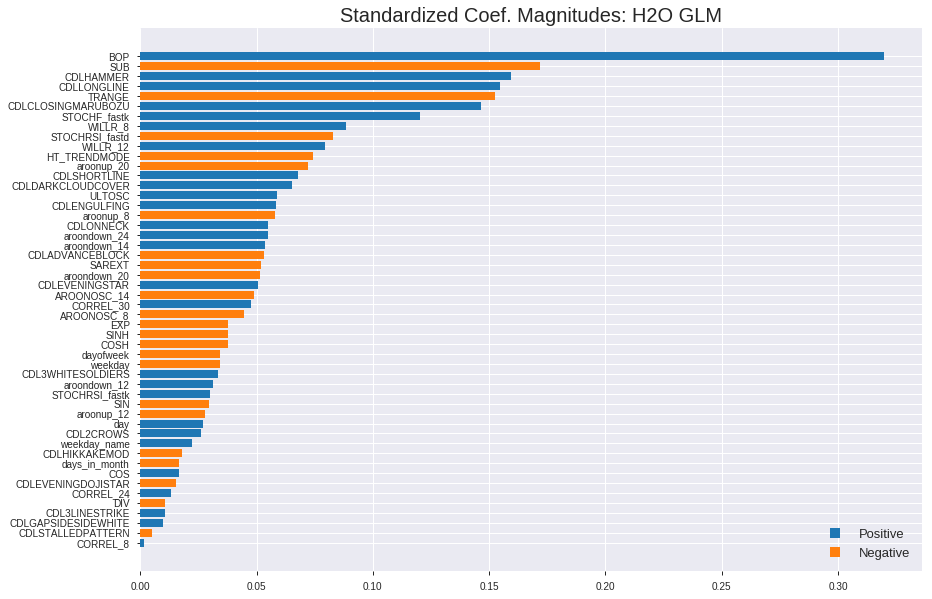

'log_likelihood'
--2019-08-25 15:35:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_153536_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_153536_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CDLHAMMER',
 'CDLLONGLINE',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCHRSI_fastd',
 'WILLR_12',
 'HT_TRENDMODE',
 'aroonup_20',
 'CDLSHORTLINE',
 'CDLDARKCLOUDCOVER',
 'ULTOSC',
 'CDLENGULFING',
 'aroonup_8',
 'CDLONNECK',
 'aroondown_24',
 'aroondown_14',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'aroondown_20',
 'CDLEVENINGSTAR',
 'AROONOSC_14',
 'CORREL_30',
 'AROONOSC_8',
 'EXP',
 'SINH',
 'COSH',
 'dayofweek',
 'weekday',
 'CDL3WHITESOLDIERS',
 'aroondown_12',
 'STOCHRSI_fastk',
 'SIN',
 'aroonup_12',
 'day',
 'CDL2CROWS',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'days_in_month',
 'COS',
 'CDLEVENINGDOJISTAR',
 'CORREL_24',
 'DIV',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CORREL_8']

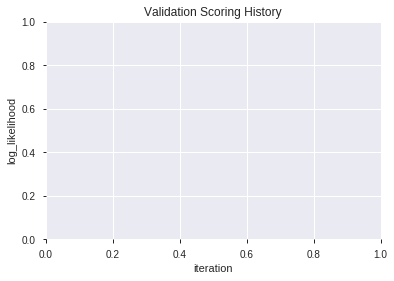

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_153547_model_4  0.709091  0.617304              0.306008  0.462818  0.214201
1  XGBoost_grid_1_AutoML_20190825_153547_model_1  0.702861  0.635581              0.322537  0.469276  0.220220
2  XGBoost_grid_1_AutoML_20190825_153547_model_2  0.701335  0.625907              0.314844  0.466325  0.217459
3  XGBoost_grid_1_AutoML_20190825_153547_model_6  0.699619  0.634613              0.325238  0.470014  0.220913
4               XGBoost_3_AutoML_20190825_153547  0.697266  0.629380              0.338620  0.468640  0.219624
5  XGBoost_grid_1_AutoML_20190825_153547_model_3  0.696885  0.633167              0.317260  0.469884  0.220791
6  XGBoost_grid_1_AutoML_20190825_153547_model_5  0.696758  0.644231              0.330356  0.473844  0.224528
7               XGBoost_2_AutoML_20190825_153547  0.692117  0.637492              0.333217  0.471829  0.222623
8               XGBoost_1_AutoML_20190825_153547  0.685251  0.643305              0.354291  0.474342  0.225000
9  XGBoost_grid_1_AutoML_20190825_153547_model_7  0.680992  0.653590              0.368818  0.478325  0.228795

variable  relative_importance  scaled_importance  percentage
0                  BOP          2046.901001           1.000000    0.460520
1                  SUB           368.735229           0.180143    0.082960
2                  DIV           230.747910           0.112730    0.051915
3          AROONOSC_14           145.697891           0.071180    0.032780
4              WILLR_8           127.327454           0.062205    0.028647
5               TRANGE           126.044945           0.061578    0.028358
6               ULTOSC           120.730049           0.058982    0.027162
7             CORREL_8            97.475998           0.047621    0.021931
8         aroondown_24            94.262611           0.046051    0.021208
9            CORREL_30            91.806145           0.044851    0.020655
10                 COS            91.042931           0.044478    0.020483
11                COSH            85.442116           0.041742    0.019223
12          aroonup_20            81.103065           0.039622    0.018247
13          aroonup_12            69.499352           0.033953    0.015636
14              SAREXT            64.630844           0.031575    0.014541
15        STOCHF_fastk            62.779545           0.030671    0.014124
16           dayofweek            61.457825           0.030025    0.013827
17            WILLR_12            51.973522           0.025391    0.011693
18      STOCHRSI_fastd            51.363293           0.025093    0.011556
19          AROONOSC_8            46.964851           0.022944    0.010566
20           aroonup_8            45.701157           0.022327    0.010282
21                 SIN            44.859627           0.021916    0.010093
22        weekday_name            39.572632           0.019333    0.008903
23         CDLLONGLINE            33.998875           0.016610    0.007649
24        aroondown_12            33.681541           0.016455    0.007578
25  CDLCLOSINGMARUBOZU            31.599388           0.015438    0.007109
26        aroondown_14            20.521070           0.010025    0.004617
27           CORREL_24            19.976948           0.009760    0.004494
28        HT_TRENDMODE            17.938961           0.008764    0.004036
29      STOCHRSI_fastk            16.440805           0.008032    0.003699
30                 day            11.562262           0.005649    0.002601
31        aroondown_20             6.552151           0.003201    0.001474
32       days_in_month             6.367228           0.003111    0.001433

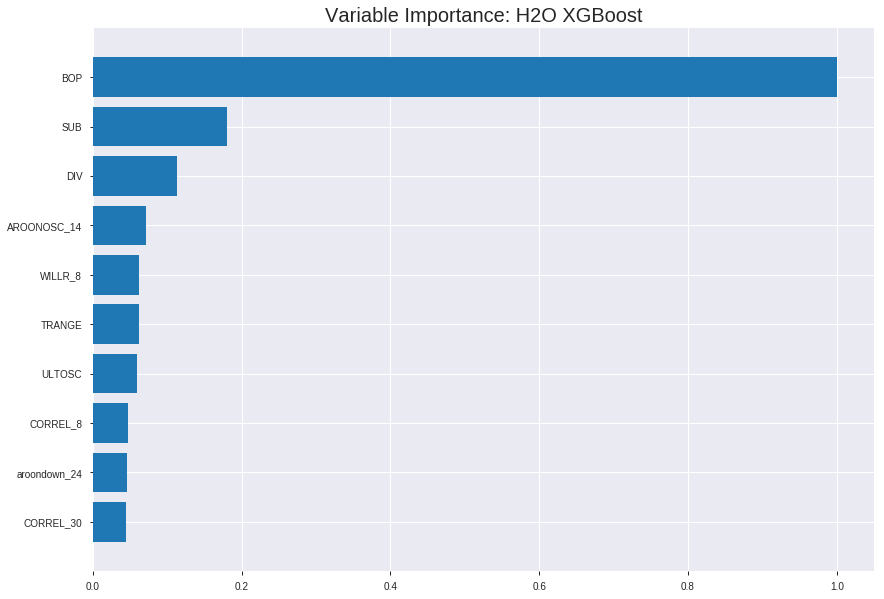

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_153547_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.196436826288196
RMSE: 0.44321194285375026
LogLoss: 0.5788664440428537
Mean Per-Class Error: 0.26420768940330963
AUC: 0.7972704310805006
pr_auc: 0.7905286310413671
Gini: 0.5945408621610011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48978374153375626: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      546  317   0.3673   (317.0/863.0)
1      160  730   0.1798   (160.0/890.0)
Total  706  1047  0.2721   (477.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489784     0.753743  207
max f2                       0.305115     0.853682  326
max f0point5                 0.537426     0.743243  167
max accuracy                 0.521594     0.735881  181
max precision                0.831033     1         0
max recall                   0.148698     1         384
max specificity              0.831033     1         0
max absolute_mcc             0.521594     0.471612  181
max min_per_class_accuracy   0.523956     0.733708  179
max mean_per_class_accuracy  0.521594     0.735792  181

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.792038           1.96966   1.96966            1                0.810891  1                           0.810891            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.771038           1.96966   1.96966            1                0.779512  1                           0.795201            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.753842           1.96966   1.96966            1                0.760583  1                           0.784098            0.0191011       0.0595506                  96.9663   96.9663
    4        0.040502                    0.743553           1.75081   1.91418            0.888889         0.748785  0.971831                    0.775145            0.0179775       0.0775281                  75.0811   91.4179
    5        0.0501997                   0.729902           1.62208   1.85775            0.823529         0.737351  0.943182                    0.767844            0.0157303       0.0932584                  62.2075   85.775
    6        0.100399                    0.687012           1.70107   1.77941            0.863636         0.707083  0.903409                    0.737464            0.0853933       0.178652                   70.1073   77.9411
    7        0.150029                    0.654326           1.42631   1.66261            0.724138         0.669875  0.844106                    0.715105            0.0707865       0.249438                   42.6308   66.2605
    8        0.200228                    0.62816            1.58916   1.64419            0.806818         0.640025  0.834758                    0.696282            0.0797753       0.329213                   58.916    64.4192
    9        0.300057                    0.588935           1.45192   1.58022            0.737143         0.607373  0.802281                    0.666702            0.144944        0.474157                   45.1923   58.0224
    10       0.399886                    0.554908           1.32812   1.51729            0.674286         0.572677  0.770328                    0.643229            0.132584        0.606742                   32.8116   51.7287
    11       0.500285                    0.524187           1.23104   1.45984            0.625            0.538419  0.741163                    0.622195            0.123596        0.730337                   23.1039   45.9841
    12       0.600114                    0.488397           0.900417  1.36678            0.457143         0.507463  0.693916                    0.60311             0.0898876       0.820225                   -9.95827  36.6781
    13       0.699943                    0.437138           0.664058  1.26656            0.337143         0.466596  0.643032                    0.58364             0.0662921       0.886517                   -33.5942  26.6556
    14       0.799772                    0.372913           0.562761  1.17871            0.285714         0.40399   0.598431                    0.561215            0.0561798       0.942697                   -43.7239  17.8707
    15       0.899601                    0.293392           0.393933  1.09162            0.2              0.33657   0.554217                    0.536286            0.0393258       0.982022                   -60.6067  9.16204
    16       1                           0.113794           0.17906   1                  0.0909091        0.200062  0.507701                    0.50253           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22224244507183175
RMSE: 0.4714259698742017
LogLoss: 0.6342478822721238
Mean Per-Class Error: 0.35367968147957873
AUC: 0.6821940020549705
pr_auc: 0.6931960946750368
Gini: 0.364388004109941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.398764967918396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      66   163  0.7118   (163.0/229.0)
1      17   255  0.0625   (17.0/272.0)
Total  83   418  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398765     0.73913   324
max f2                       0.2042       0.862944  387
max f0point5                 0.526346     0.676796  225
max accuracy                 0.505488     0.656687  253
max precision                0.840656     1         0
max recall                   0.2042       1         387
max specificity              0.840656     1         0
max absolute_mcc             0.416595     0.303916  314
max min_per_class_accuracy   0.541017     0.617647  197
max mean_per_class_accuracy  0.526346     0.64632   225

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 53.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.801552           1.53493   1.53493            0.833333         0.817516  0.833333                    0.817516            0.0183824       0.0183824                  53.4926   53.4926
    2        0.0219561                   0.795509           1.47353   1.50702            0.8              0.797229  0.818182                    0.808294            0.0147059       0.0330882                  47.3529   50.7019
    3        0.0319361                   0.780794           1.84191   1.61167            1                0.788389  0.875                       0.802074            0.0183824       0.0514706                  84.1912   61.1673
    4        0.0419162                   0.775643           1.84191   1.66649            1                0.777577  0.904762                    0.796241            0.0183824       0.0698529                  84.1912   66.6492
    5        0.0518962                   0.768978           1.84191   1.70023            1                0.771699  0.923077                    0.791522            0.0183824       0.0882353                  84.1912   70.0226
    6        0.101796                    0.741278           1.2525    1.48075            0.68             0.754641  0.803922                    0.773443            0.0625          0.150735                   25.25     48.0753
    7        0.151697                    0.703271           1.2525    1.40567            0.68             0.72263   0.763158                    0.756728            0.0625          0.213235                   25.25     40.567
    8        0.201597                    0.661559           0.884118  1.27657            0.48             0.681895  0.693069                    0.738205            0.0441176       0.257353                   -11.5882  27.6573
    9        0.301397                    0.593466           1.14199   1.23201            0.62             0.626326  0.668874                    0.701159            0.113971        0.371324                   14.1985   23.2007
    10       0.401198                    0.563456           1.43669   1.28292            0.78             0.578182  0.696517                    0.670568            0.143382        0.514706                   43.6691   28.2924
    11       0.500998                    0.541023           1.03147   1.23283            0.56             0.55117   0.669323                    0.646783            0.102941        0.617647                   3.14706   23.2833
    12       0.600798                    0.521737           1.17882   1.22386            0.64             0.531905  0.664452                    0.6277              0.117647        0.735294                   17.8824   22.3862
    13       0.700599                    0.490618           0.810441  1.16497            0.44             0.509934  0.632479                    0.610925            0.0808824       0.816176                   -18.9559  16.497
    14       0.800399                    0.428888           0.884118  1.12995            0.48             0.464236  0.613466                    0.592634            0.0882353       0.904412                   -11.5882  12.9951
    15       0.9002                      0.345803           0.552574  1.06594            0.3              0.382593  0.578714                    0.569348            0.0551471       0.959559                   -44.7426  6.59401
    16       1                           0.132438           0.405221  1                  0.22             0.255962  0.542914                    0.538072           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:35:53  2.119 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.457086
    2019-08-25 15:35:53  2.181 sec   5                  0.479909         0.65354             0.771686        0.747625           1.88013          0.336566                         0.484512           0.662499              0.723558          0.728553             1.26631            0.339321
    2019-08-25 15:35:53  2.220 sec   10                 0.465967         0.626251            0.779449        0.773099           1.86024          0.306332                         0.474283           0.642275              0.718084          0.714543             1.38143            0.333333
    2019-08-25 15:35:53  2.261 sec   15                 0.456261         0.606953            0.786518        0.785065           1.96966          0.308043                         0.467888           0.629295              0.719513          0.722978             1.84191            0.327345
    2019-08-25 15:35:53  2.310 sec   20                 0.449451         0.593053            0.789646        0.789993           1.86024          0.31603                          0.464278           0.621646              0.717787          0.722586             1.53493            0.327345
    2019-08-25 15:35:53  2.364 sec   25                 0.444445         0.582697            0.794141        0.794219           1.96966          0.309755                         0.463301           0.6192                0.714512          0.717834             1.84191            0.333333
    2019-08-25 15:35:53  2.414 sec   30                 0.439939         0.573196            0.798268        0.79946            1.96966          0.312037                         0.462347           0.616766              0.713139          0.716704             1.53493            0.329341
    2019-08-25 15:35:53  2.479 sec   35                 0.446785         0.586425            0.787902        0.779155           1.96966          0.306902                         0.470659           0.634274              0.704775          0.699895             1.22794            0.345309
    2019-08-25 15:35:53  2.535 sec   40                 0.447774         0.588261            0.791773        0.785617           1.96966          0.272675                         0.462688           0.616403              0.705625          0.708969             1.53493            0.351297
    2019-08-25 15:35:53  2.589 sec   45                 0.447787         0.588234            0.787065        0.774141           1.96966          0.280662                         0.463196           0.61707               0.70394           0.708858             1.84191            0.349301
    2019-08-25 15:35:53  2.643 sec   50                 0.443212         0.578866            0.79727         0.790529           1.96966          0.272105                         0.471426           0.634248              0.682194          0.693196             1.53493            0.359281

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2046.9010009765625     1.0                    0.4605201090510796
SUB             368.7352294921875      0.18014316731305835    0.0829595510558165
DIV             230.74790954589844     0.11273037114926916    0.05191460281503011
AROONOSC_14     145.69789123535156     0.07117974497342085    0.0327797039173878
WILLR_8         127.32745361328125     0.06220498868901534    0.028646648174586516
---             ---                    ---                    ---
HT_TRENDMODE    17.938961029052734     0.00876396123725289    0.004035980384699135
STOCHRSI_fastk  16.440805435180664     0.008032047191015525   0.0036989192483098867
day             11.562261581420898     0.005648666728827932   0.002601324617953044
aroondown_20    6.552150726318359      0.0032010100748362394  0.0014741295087371893
days_in_month   6.367228031158447      0.0031106673103001494  0.0014325248489610533


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7194244604316546)

('auc', 0.7090909090909091)

('logloss', 0.6173038681629116)

('mean_per_class_error', 0.3060076287349014)

('rmse', 0.46281843150263885)

('mse', 0.21420090053856283)

xgboost prediction progress: |████████████████████████████████████████████| 100%


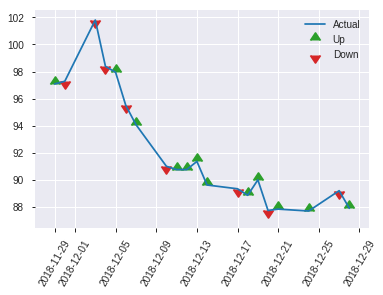


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21420090053856283
RMSE: 0.46281843150263885
LogLoss: 0.6173038681629116
Mean Per-Class Error: 0.3060076287349014
AUC: 0.7090909090909091
pr_auc: 0.6352784830054212
Gini: 0.4181818181818182
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44904160499572754: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   57   0.4385   (57.0/130.0)
1      21   100  0.1736   (21.0/121.0)
Total  94   157  0.3108   (78.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449042     0.719424  156
max f2                       0.192793     0.840395  223
max f0point5                 0.449042     0.667557  156
max accuracy                 0.449042     0.689243  156
max precision                0.798179     1         0
max recall                   0.146024     1         242
max specificity              0.798179     1         0
max absolute_mcc             0.449042     0.400558  156
max min_per_class_accuracy   0.543887     0.653846  124
max mean_per_class_accuracy  0.449042     0.693992  156

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.78293            2.07438   2.07438            1                0.79269   1                           0.79269             0.0247934       0.0247934                  107.438   107.438
    2        0.0239044                   0.772979           0.69146   1.38292            0.333333         0.777932  0.666667                    0.785311            0.00826446      0.0330579                  -30.854   38.292
    3        0.0318725                   0.769041           1.03719   1.29649            0.5              0.770814  0.625                       0.781687            0.00826446      0.0413223                  3.71901   29.6488
    4        0.0438247                   0.762986           0.69146   1.13148            0.333333         0.765978  0.545455                    0.777403            0.00826446      0.0495868                  -30.854   13.148
    5        0.0517928                   0.761396           2.07438   1.27654            1                0.762338  0.615385                    0.775085            0.0165289       0.0661157                  107.438   27.6542
    6        0.103586                    0.739059           1.59568   1.43611            0.769231         0.749612  0.692308                    0.762349            0.0826446       0.14876                    59.5677   43.6109
    7        0.151394                    0.71266            1.38292   1.41931            0.666667         0.72143   0.684211                    0.749427            0.0661157       0.214876                   38.292    41.9313
    8        0.203187                    0.690441           0.797839  1.2609             0.384615         0.700805  0.607843                    0.737033            0.0413223       0.256198                   -20.2161  26.0898
    9        0.302789                    0.64958            1.6595    1.39202            0.8              0.669989  0.671053                    0.714979            0.165289        0.421488                   65.9504   39.2018
    10       0.40239                     0.591025           1.16165   1.335              0.56             0.619768  0.643564                    0.691412            0.115702        0.53719                    16.1653   33.4997
    11       0.501992                    0.542282           1.3276    1.33353            0.64             0.565275  0.642857                    0.666385            0.132231        0.669421                   32.7603   33.353
    12       0.601594                    0.459562           1.24463   1.31881            0.6              0.491344  0.635762                    0.637405            0.123967        0.793388                   24.4628   31.8811
    13       0.701195                    0.352768           0.580826  1.21398            0.28             0.403656  0.585227                    0.604202            0.0578512       0.85124                    -41.9174  21.3984
    14       0.800797                    0.263278           0.663802  1.14555            0.32             0.30022   0.552239                    0.566393            0.0661157       0.917355                   -33.6198  14.5553
    15       0.900398                    0.186965           0.663802  1.09226            0.32             0.22888   0.526549                    0.529058            0.0661157       0.983471                   -33.6198  9.22621
    16       1                           0.117455           0.16595   1                  0.08             0.1541    0.482072                    0.491711            

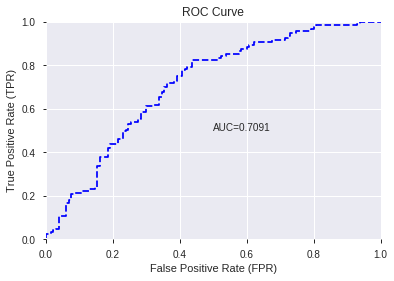

This function is available for GLM models only


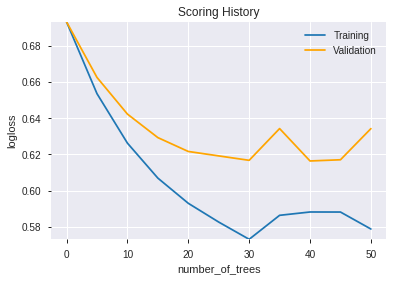

--2019-08-25 15:36:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_153547_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_153547_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'AROONOSC_14',
 'WILLR_8',
 'TRANGE',
 'ULTOSC',
 'CORREL_8',
 'aroondown_24',
 'CORREL_30',
 'COS',
 'COSH',
 'aroonup_20',
 'aroonup_12',
 'SAREXT',
 'STOCHF_fastk',
 'dayofweek',
 'WILLR_12',
 'STOCHRSI_fastd',
 'AROONOSC_8',
 'aroonup_8',
 'SIN',
 'weekday_name',
 'CDLLONGLINE',
 'aroondown_12',
 'CDLCLOSINGMARUBOZU',
 'aroondown_14',
 'CORREL_24',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'day',
 'aroondown_20',
 'days_in_month']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


25

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ATR_8',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_153610_model_9  0.707565  0.620205              0.312556  0.464577  0.215832
1  DeepLearning_grid_1_AutoML_20190825_153610_model_8  0.707502  0.626621              0.323236  0.467967  0.218993
2  DeepLearning_grid_1_AutoML_20190825_153610_model_5  0.702924  0.624530              0.311697  0.466851  0.217950
3  DeepLearning_grid_1_AutoML_20190825_153610_model_6  0.697330  0.650035              0.311411  0.473962  0.224640
4  DeepLearning_grid_1_AutoML_20190825_153610_model_7  0.696313  0.733903              0.323808  0.483661  0.233928
5  DeepLearning_grid_1_AutoML_20190825_153610_model_3  0.691926  0.687073              0.330928  0.480028  0.230427
6               DeepLearning_1_AutoML_20190825_153610  0.687730  0.669083              0.342467  0.485609  0.235816
7  DeepLearning_grid_1_AutoML_20190825_153610_model_4  0.683471  0.728831              0.335346  0.499299  0.249299
8  DeepLearning_grid_1_AutoML_20190825_153610_model_2  0.680928  0.665370              0.382772  0.480649  0.231024
9  DeepLearning_grid_1_AutoML_20190825_153610_model_1  0.680483  0.829434              0.353147  0.503025  0.253034

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.083710
1          CDLLONGLINE             0.983929           0.983929    0.082365
2                  BOP             0.883220           0.883220    0.073934
3                  SUB             0.680730           0.680730    0.056984
4            CDLHAMMER             0.642944           0.642944    0.053821
5         CDLSHORTLINE             0.573725           0.573725    0.048027
6               TRANGE             0.571703           0.571703    0.047857
7         CDLENGULFING             0.537344           0.537344    0.044981
8          CDLBELTHOLD             0.535507           0.535507    0.044827
9         STOCHF_fastk             0.525319           0.525319    0.043974
10         CDLMARUBOZU             0.473503           0.473503    0.039637
11               CCI_8             0.382320           0.382320    0.032004
12                 DIV             0.370553           0.370553    0.031019
13            WILLR_24             0.368415           0.368415    0.030840
14             WILLR_8             0.365919           0.365919    0.030631
15               ATR_8             0.362164           0.362164    0.030317
16              ULTOSC             0.338708           0.338708    0.028353
17      STOCHRSI_fastk             0.336183           0.336183    0.028142
18            WILLR_20             0.301238           0.301238    0.025217
19            WILLR_12             0.298022           0.298022    0.024947
20            WILLR_14             0.290243           0.290243    0.024296
21              CMO_12             0.288241           0.288241    0.024129
22               CMO_8             0.280354           0.280354    0.023468
23              RSI_12             0.279203           0.279203    0.023372
24               RSI_8             0.276511           0.276511    0.023147

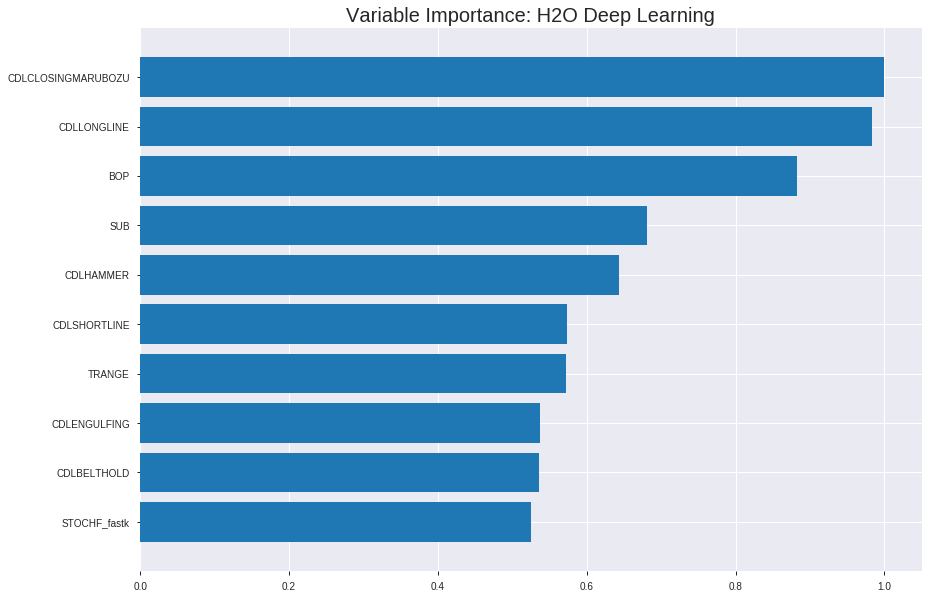

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_153610_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.201069440798824
RMSE: 0.44840767254678415
LogLoss: 0.5879808508631011
Mean Per-Class Error: 0.3074498418112932
AUC: 0.7584875076490424
pr_auc: 0.744036678815919
Gini: 0.5169750152980848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3715834035798215: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      350  513   0.5944   (513.0/863.0)
1      80   810   0.0899   (80.0/890.0)
Total  430  1323  0.3383   (593.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371583     0.732038  273
max f2                       0.25112      0.846336  326
max f0point5                 0.561        0.706052  161
max accuracy                 0.513198     0.693098  199
max precision                0.906505     1         0
max recall                   0.104511     1         393
max specificity              0.906505     1         0
max absolute_mcc             0.513198     0.386202  199
max min_per_class_accuracy   0.518422     0.680185  194
max mean_per_class_accuracy  0.513198     0.69255   199

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.884704           1.75081   1.75081            0.888889         0.893984  0.888889                    0.893984            0.0179775       0.0179775                  75.0811   75.0811
    2        0.0205362                   0.867157           1.75081   1.75081            0.888889         0.878197  0.888889                    0.88609             0.0179775       0.0359551                  75.0811   75.0811
    3        0.0302339                   0.840635           1.50621   1.67236            0.764706         0.853626  0.849057                    0.875677            0.0146067       0.0505618                  50.6213   67.2355
    4        0.040502                    0.826151           1.75081   1.69225            0.888889         0.832191  0.859155                    0.864653            0.0179775       0.0685393                  75.0811   69.2246
    5        0.0501997                   0.815683           1.50621   1.65631            0.764706         0.820309  0.840909                    0.856086            0.0146067       0.0831461                  50.6213   65.6307
    6        0.100399                    0.75176            1.67869   1.6675             0.852273         0.779508  0.846591                    0.817797            0.0842697       0.167416                   67.869    66.7499
    7        0.150029                    0.727169           1.63007   1.65512            0.827586         0.738557  0.840304                    0.791585            0.0808989       0.248315                   63.0066   65.5116
    8        0.200228                    0.693125           1.45486   1.60491            0.738636         0.712147  0.814815                    0.771669            0.0730337       0.321348                   45.4865   60.4911
    9        0.300057                    0.614967           1.41816   1.54278            0.72             0.651224  0.78327                     0.731597            0.141573        0.462921                   41.8157   54.2778
    10       0.399886                    0.548125           1.19305   1.45547            0.605714         0.576534  0.738944                    0.692886            0.119101        0.582022                   19.3053   45.5471
    11       0.500285                    0.518425           1.01841   1.36776            0.517045         0.530231  0.694413                    0.660244            0.102247        0.68427                    1.84053   36.7759
    12       0.600114                    0.500669           0.911673  1.29189            0.462857         0.510112  0.655894                    0.63527             0.0910112       0.775281                   -8.83274  29.1889
    13       0.699943                    0.436852           0.832886  1.22642            0.422857         0.477715  0.622657                    0.612798            0.0831461       0.858427                   -16.7114  22.6424
    14       0.799772                    0.312959           0.7541    1.16747            0.382857         0.376019  0.592725                    0.583243            0.0752809       0.933708                   -24.59    16.7468
    15       0.899601                    0.210515           0.393933  1.08163            0.2              0.255087  0.549144                    0.546828            0.0393258       0.973034                   -60.6067  8.16285
    16       1                           0.070024           0.26859   1                  0.136364         0.161723  0.507701                    0.508163         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2109625514595863
RMSE: 0.45930659853695366
LogLoss: 0.6103660026695581
Mean Per-Class Error: 0.3395116234266633
AUC: 0.7236867454405342
pr_auc: 0.7393319219042452
Gini: 0.4473734908810685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4612098543837541: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   132  0.5764   (132.0/229.0)
1      33   239  0.1213   (33.0/272.0)
Total  130  371  0.3293   (165.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46121      0.74339   284
max f2                       0.145245     0.862397  387
max f0point5                 0.658267     0.696429  118
max accuracy                 0.461931     0.670659  283
max precision                0.909097     1         0
max recall                   0.145245     1         387
max specificity              0.909097     1         0
max absolute_mcc             0.658267     0.354801  118
max min_per_class_accuracy   0.544302     0.650655  206
max mean_per_class_accuracy  0.658267     0.660488  118

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 54.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.887881           1.84191   1.84191            1                0.892322  1                           0.892322            0.0220588       0.0220588                  84.1912    84.1912
    2        0.0219561                   0.882826           1.10515   1.50702            0.6              0.884194  0.818182                    0.888627            0.0110294       0.0330882                  10.5147    50.7019
    3        0.0319361                   0.867492           1.10515   1.38143            0.6              0.875481  0.75                        0.884519            0.0110294       0.0441176                  10.5147    38.1434
    4        0.0419162                   0.843215           1.84191   1.49107            1                0.855167  0.809524                    0.877531            0.0183824       0.0625                     84.1912    49.1071
    5        0.0518962                   0.830355           1.47353   1.4877             0.8              0.835525  0.807692                    0.869453            0.0147059       0.0772059                  47.3529    48.7698
    6        0.101796                    0.76611            1.62088   1.55298            0.88             0.804059  0.843137                    0.837397            0.0808824       0.158088                   62.0882    55.2984
    7        0.151697                    0.740103           1.32618   1.47838            0.72             0.751782  0.802632                    0.809234            0.0661765       0.224265                   32.6176    47.8377
    8        0.201597                    0.705895           1.62088   1.51365            0.88             0.725019  0.821782                    0.788389            0.0808824       0.305147                   62.0882    51.365
    9        0.301397                    0.64895            1.36301   1.46377            0.74             0.676327  0.794702                    0.751282            0.136029        0.441176                   36.3015    46.3771
    10       0.401198                    0.588656           0.994632  1.34707            0.54             0.619579  0.731343                    0.71852             0.0992647       0.540441                   -0.536765  34.707
    11       0.500998                    0.546864           0.957794  1.26952            0.52             0.56412   0.689243                    0.687763            0.0955882       0.636029                   -4.22059   26.9525
    12       0.600798                    0.517152           1.10515   1.24222            0.6              0.530935  0.674419                    0.661712            0.110294        0.746324                   10.5147    24.222
    13       0.700599                    0.490881           0.884118  1.19121            0.48             0.503106  0.646724                    0.639119            0.0882353       0.834559                   -11.5882   19.1208
    14       0.800399                    0.388046           0.699926  1.12995            0.38             0.445451  0.613466                    0.61497             0.0698529       0.904412                   -30.0074   12.9951
    15       0.9002                      0.240699           0.589412  1.07002            0.32             0.301598  0.580931                    0.580228            0.0588235       0.963235                   -41.0588   7.00241
    16       1                           0.0847401          0.368382  1                  0.2              0.178687  0.542914                    0.5


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:44:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:44:32  3 min 12.147 sec  504 obs/sec       0.646321  1             1133       0.47893          0.695882            0.0822874      0.730211        0.723827           1.75081          0.362807                         0.50117            0.75264               -0.0121407       0.68453           0.706968             1.84191            0.393214
    2019-08-25 15:44:46  3 min 25.537 sec  901 obs/sec       7.39475   11            12963      0.456791         0.604127            0.165171       0.751974        0.744348           1.86024          0.339989                         0.466539           0.626235              0.122903         0.7135            0.738062             1.84191            0.371257
    2019-08-25 15:44:59  3 min 38.804 sec  1070 obs/sec      16.1141   24            28248      0.457756         0.608335            0.161638       0.75488         0.741621           1.86024          0.358813                         0.465173           0.622695              0.128032         0.717474          0.736682             1.84191            0.367265
    2019-08-25 15:45:12  3 min 52.345 sec  1182 obs/sec      26.0776   39            45714      0.451929         0.595544            0.182847       0.755151        0.740724           1.75081          0.334284                         0.460398           0.612294              0.145844         0.720773          0.733514             1.53493            0.361277
    2019-08-25 15:45:25  4 min  5.243 sec  1259 obs/sec      36.0753   54            63240      0.449175         0.58982             0.192776       0.755833        0.741186           1.75081          0.348545                         0.460871           0.6132                0.144087         0.71944           0.731512             1.53493            0.361277
    2019-08-25 15:45:39  4 min 18.702 sec  1329 obs/sec      47.348    71            83001      0.448408         0.587981            0.195531       0.758488        0.744037           1.75081          0.338277                         0.459307           0.610366              0.149887         0.723687          0.739332             1.84191            0.329341
    2019-08-25 15:45:51  4 min 31.286 sec  1377 obs/sec      57.9196   87            101533     0.448972         0.589717            0.193506       0.75893         0.742483           1.64139          0.339418                         0.461238           0.615295              0.142724         0.722266          0.733901             1.53493            0.325349
    2019-08-25 15:45:53  4 min 32.585 sec  1377 obs/sec      57.9196   87            101533     0.448408         0.587981            0.195531       0.758488        0.744037           1.75081          0.338277                         0.459307           0.610366              0.149887         0.723687          0.739332             1.84191            0.329341

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.08371003967004978
CDLLONGLINE         0.9839290380477905     0.9839290380477905   0.08236473880749447
BOP                 0.883220374584198      0.883220374584198    0.07393441259383944
SUB                 0.680729866027832      0.680729866027832    0.05698392408977749
CDLHAMMER           0.6429439783096313     0.6429439783096313   0.05382086592991887
---                 ---                    ---                  ---
WILLR_14            0.2902429401874542     0.2902429401874542   0.024296248037043677
CMO_12              0.28824055194854736    0.28824055194854736  0.024128628038129943
CMO_8               0.28035393357276917    0.28035393357276917  0.023468438901031008
RSI_12              0.27920329570770264    0.27920329570770264  0.023372118959700428
RSI_8               0.2765112817287445     0.2765112817287445   0.023146770362729514


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6812749003984063)

('F1', 0.7222222222222222)

('auc', 0.7075651621106166)

('logloss', 0.6202048859999719)

('mean_per_class_error', 0.31255562619198984)

('rmse', 0.46457669865535967)

('mse', 0.21583150893351288)

deeplearning prediction progress: |███████████████████████████████████████| 100%


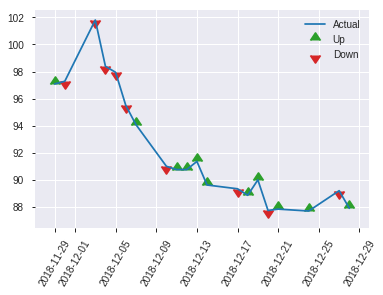


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21583150893351288
RMSE: 0.46457669865535967
LogLoss: 0.6202048859999719
Mean Per-Class Error: 0.31255562619198984
AUC: 0.7075651621106166
pr_auc: 0.615336389037703
Gini: 0.4151303242212332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4289936469745671: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   63   0.4846   (63.0/130.0)
1      17   104  0.1405   (17.0/121.0)
Total  84   167  0.3187   (80.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428994     0.722222  166
max f2                       0.195454     0.84507   225
max f0point5                 0.428994     0.659062  166
max accuracy                 0.428994     0.681275  166
max precision                0.897921     1         0
max recall                   0.158016     1         234
max specificity              0.897921     1         0
max absolute_mcc             0.428994     0.39698   166
max min_per_class_accuracy   0.519823     0.652893  122
max mean_per_class_accuracy  0.428994     0.687444  166

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.885886           1.38292    1.38292            0.666667         0.892694  0.666667                    0.892694            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.857406           1.38292    1.38292            0.666667         0.87066   0.666667                    0.881677            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.822967           1.03719    1.29649            0.5              0.830481  0.625                       0.868878            0.00826446      0.0413223                  3.71901    29.6488
    4        0.0438247                   0.792844           0.69146    1.13148            0.333333         0.806745  0.545455                    0.851933            0.00826446      0.0495868                  -30.854    13.148
    5        0.0517928                   0.76631            1.03719    1.11697            0.5              0.767936  0.538462                    0.83901             0.00826446      0.0578512                  3.71901    11.6974
    6        0.103586                    0.732114           1.27654    1.19676            0.615385         0.746354  0.576923                    0.792682            0.0661157       0.123967                   27.6542    19.6758
    7        0.151394                    0.713574           1.38292    1.25555            0.666667         0.722195  0.605263                    0.770423            0.0661157       0.190083                   38.292     25.5546
    8        0.203187                    0.654194           1.27654    1.2609             0.615385         0.671867  0.607843                    0.745301            0.0661157       0.256198                   27.6542    26.0898
    9        0.302789                    0.601121           1.41058    1.31013            0.68             0.620817  0.631579                    0.704352            0.140496        0.396694                   41.0579    31.0135
    10       0.40239                     0.552922           1.49355    1.35554            0.72             0.574527  0.653465                    0.672217            0.14876         0.545455                   49.3554    35.5536
    11       0.501992                    0.518429           1.07868    1.3006             0.52             0.533203  0.626984                    0.644635            0.107438        0.652893                   7.86777    30.0603
    12       0.601594                    0.48604            1.24463    1.29134            0.6              0.504085  0.622517                    0.621365            0.123967        0.77686                    24.4628    29.1336
    13       0.701195                    0.380376           0.995702   1.24934            0.48             0.434606  0.602273                    0.594837            0.0991736       0.876033                   -0.429752  24.9343
    14       0.800797                    0.259788           0.663802   1.17651            0.32             0.318243  0.567164                    0.560435            0.0661157       0.942149                   -33.6198   17.6514
    15       0.900398                    0.195454           0.497851   1.10144            0.24             0.2291    0.530973                    0.523782            0.0495868       0.991736                   -50.2149   10.1441
    16       1                           0.0548817          0.0829752  1                  0.04             0.139642  0.482072     

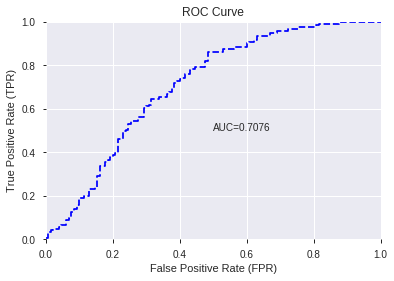

This function is available for GLM models only


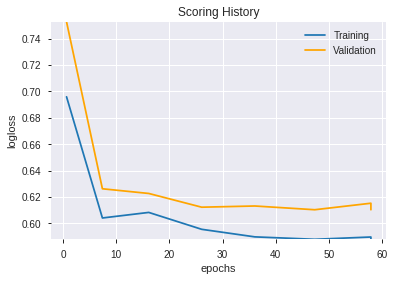

--2019-08-25 15:45:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_153610_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_153610_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'BOP',
 'SUB',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'CCI_8',
 'DIV',
 'WILLR_24',
 'WILLR_8',
 'ATR_8',
 'ULTOSC',
 'STOCHRSI_fastk',
 'WILLR_20',
 'WILLR_12',
 'WILLR_14',
 'CMO_12',
 'CMO_8',
 'RSI_12',
 'RSI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_154605_model_1  0.721933  0.613427              0.314399  0.461679  0.213148

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.760050           1.000000    0.135796
1                  SUB             0.740125           0.973785    0.132236
2         STOCHF_fastk             0.431347           0.567525    0.077068
3             WILLR_14             0.408345           0.537260    0.072958
4             WILLR_12             0.372781           0.490468    0.066604
5                  DIV             0.357986           0.471004    0.063960
6                CCI_8             0.308182           0.405476    0.055062
7       STOCHRSI_fastk             0.233038           0.306609    0.041636
8            CDLHAMMER             0.225720           0.296981    0.040329
9               CMO_12             0.211664           0.278487    0.037817
10             WILLR_8             0.187763           0.247040    0.033547
11         CDLLONGLINE             0.175674           0.231134    0.031387
12              RSI_12             0.173654           0.228478    0.031026
13  CDLCLOSINGMARUBOZU             0.171287           0.225363    0.030603
14               ATR_8             0.135887           0.178788    0.024279
15              TRANGE             0.134406           0.176839    0.024014
16         CDLMARUBOZU             0.129524           0.170415    0.023142
17               CMO_8             0.126054           0.165849    0.022522
18         CDLBELTHOLD             0.109776           0.144433    0.019613
19               RSI_8             0.080686           0.106159    0.014416
20            WILLR_20             0.046324           0.060948    0.008276
21              ULTOSC             0.032886           0.043269    0.005876
22        CDLENGULFING             0.024704           0.032503    0.004414
23            WILLR_24             0.018267           0.024034    0.003264
24        CDLSHORTLINE             0.000873           0.001148    0.000156

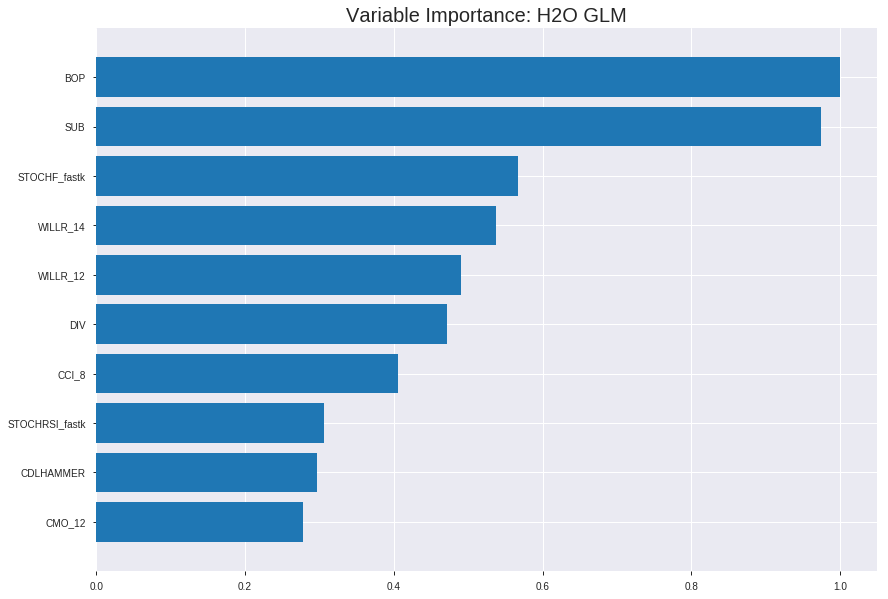

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_154605_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1974710129626639
RMSE: 0.4443771067040514
LogLoss: 0.5776660060430338
Null degrees of freedom: 1752
Residual degrees of freedom: 1727
Null deviance: 2429.7581400712443
Residual deviance: 2025.297017186876
AIC: 2077.297017186876
AUC: 0.7630958115796738
pr_auc: 0.750431356668738
Gini: 0.5261916231593475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30333584969697636: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      327  536   0.6211   (536.0/863.0)
1      67   823   0.0753   (67.0/890.0)
Total  394  1359  0.344    (603.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303336     0.731881  294
max f2                       0.194235     0.850752  340
max f0point5                 0.501054     0.701735  199
max accuracy                 0.501054     0.699943  199
max precision                0.947083     1         0
max recall                   0.0282907    1         396
max specificity              0.947083     1         0
max absolute_mcc             0.501054     0.399738  199
max min_per_class_accuracy   0.522572     0.692932  190
max mean_per_class_accuracy  0.501054     0.69952   199

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.90744            1.75081   1.75081            0.888889         0.925035  0.888889                    0.925035            0.0179775       0.0179775                  75.0811   75.0811
    2        0.0205362                   0.885141           1.86024   1.80552            0.944444         0.895135  0.916667                    0.910085            0.0191011       0.0370787                  86.0237   80.5524
    3        0.0302339                   0.876697           1.50621   1.70952            0.764706         0.881521  0.867925                    0.900923            0.0146067       0.0516854                  50.6213   70.9519
    4        0.040502                    0.866002           1.86024   1.74773            0.944444         0.870976  0.887324                    0.893331            0.0191011       0.0707865                  86.0237   74.7729
    5        0.0501997                   0.851472           1.73794   1.74584            0.882353         0.858462  0.886364                    0.886595            0.0168539       0.0876404                  73.7938   74.5838
    6        0.100399                    0.800499           1.67869   1.71226            0.852273         0.826388  0.869318                    0.856491            0.0842697       0.17191                    67.869    71.2264
    7        0.150029                    0.768476           1.53951   1.65512            0.781609         0.783605  0.840304                    0.832381            0.0764045       0.248315                   53.9507   65.5116
    8        0.200228                    0.731171           1.36533   1.58246            0.693182         0.748724  0.803419                    0.811407            0.0685393       0.316854                   36.5335   58.2464
    9        0.300057                    0.657107           1.35063   1.50533            0.685714         0.693741  0.764259                    0.77226             0.134831        0.451685                   35.0626   50.5332
    10       0.399886                    0.59358            1.24933   1.44142            0.634286         0.626177  0.731812                    0.735791            0.124719        0.576404                   24.9329   44.1422
    11       0.500285                    0.524071           1.14151   1.38123            0.579545         0.560008  0.701254                    0.700514            0.114607        0.691011                   14.1509   38.1235
    12       0.600114                    0.451402           0.967949  1.31248            0.491429         0.487162  0.66635                     0.665023            0.0966292       0.78764                    -3.20514  31.2485
    13       0.699943                    0.366691           0.731589  1.22963            0.371429         0.411929  0.624287                    0.628926            0.0730337       0.860674                   -26.8411  22.9635
    14       0.799772                    0.282491           0.810376  1.1773             0.411429         0.325909  0.597718                    0.591103            0.0808989       0.941573                   -18.9624  17.7302
    15       0.899601                    0.176042           0.405188  1.09162            0.205714         0.234675  0.554217                    0.55155             0.0404494       0.982022                   -59.4812  9.16204
    16       1                           0.0101755          0.17906   1                  0.0909091        0.11481   0.507701                    0.507701         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2080450363809585
RMSE: 0.45611954176614544
LogLoss: 0.6004106816121602
Null degrees of freedom: 500
Residual degrees of freedom: 475
Null deviance: 693.327648451823
Residual deviance: 601.6115029753845
AIC: 653.6115029753845
AUC: 0.7302610454662214
pr_auc: 0.7470202959251561
Gini: 0.4605220909324428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3871918752711194: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      105  124  0.5415   (124.0/229.0)
1      39   233  0.1434   (39.0/272.0)
Total  144  357  0.3253   (163.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387192     0.740859  278
max f2                       0.166155     0.872914  371
max f0point5                 0.526596     0.701039  212
max accuracy                 0.421739     0.676647  268
max precision                0.929819     1         0
max recall                   0.166155     1         371
max specificity              0.929819     1         0
max absolute_mcc             0.421739     0.347566  268
max min_per_class_accuracy   0.538738     0.668122  204
max mean_per_class_accuracy  0.526596     0.672754  212

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.900463           1.84191   1.84191            1                0.913255  1                           0.913255            0.0220588       0.0220588                  84.1912    84.1912
    2        0.0219561                   0.89192            1.47353   1.67447            0.8              0.895109  0.909091                    0.905007            0.0147059       0.0367647                  47.3529    67.4465
    3        0.0319361                   0.873721           1.47353   1.61167            0.8              0.877744  0.875                       0.896487            0.0147059       0.0514706                  47.3529    61.1673
    4        0.0419162                   0.862614           1.47353   1.57878            0.8              0.868063  0.857143                    0.889719            0.0147059       0.0661765                  47.3529    57.8782
    5        0.0518962                   0.849315           1.84191   1.62938            1                0.855956  0.884615                    0.883226            0.0183824       0.0845588                  84.1912    62.9383
    6        0.101796                    0.814218           1.47353   1.55298            0.8              0.826914  0.843137                    0.855622            0.0735294       0.158088                   47.3529    55.2984
    7        0.151697                    0.761936           1.47353   1.52685            0.8              0.791536  0.828947                    0.834541            0.0735294       0.231618                   47.3529    52.6848
    8        0.201597                    0.730322           1.54721   1.53189            0.84             0.741031  0.831683                    0.811395            0.0772059       0.308824                   54.7206    53.1887
    9        0.301397                    0.676722           1.21566   1.42718            0.66             0.703502  0.774834                    0.775669            0.121324        0.430147                   21.5662    42.7177
    10       0.401198                    0.6168             1.14199   1.35623            0.62             0.649946  0.736318                    0.744395            0.113971        0.544118                   14.1985    35.6234
    11       0.500998                    0.547719           0.994632  1.2842             0.54             0.579817  0.697211                    0.71161             0.0992647       0.643382                   -0.536765  28.4201
    12       0.600798                    0.487969           0.884118  1.21774            0.48             0.516631  0.66113                     0.679222            0.0882353       0.731618                   -11.5882   21.7742
    13       0.700599                    0.398188           1.06831   1.19646            0.58             0.448341  0.649573                    0.646333            0.106618        0.838235                   6.83088    19.6456
    14       0.800399                    0.328592           0.736765  1.13914            0.4              0.361702  0.618454                    0.610843            0.0735294       0.911765                   -26.3235   13.9137
    15       0.9002                      0.221813           0.589412  1.07819            0.32             0.27485   0.585366                    0.573593            0.0588235       0.970588                   -41.0588   7.81923
    16       1                           0.0358218          0.294706  1                  0.16             0.140382  0.542914                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 15:46:06  0.000 sec   2            .19E2     26            1.368184639940345   1.3670809355332363
     2019-08-25 15:46:06  0.004 sec   4            .12E2     26            1.3594003150284395  1.358944435159933
     2019-08-25 15:46:06  0.009 sec   6            .72E1     26            1.3475363245473975  1.348117595068626
     2019-08-25 15:46:06  0.014 sec   8            .44E1     26            1.3324716368818839  1.3346851605986039
     2019-08-25 15:46:06  0.019 sec   10           .28E1     26            1.314374269328924   1.3190715879383161
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 15:46:06  0.106 sec   43           .52E-3    26            1.155225715058654   1.2008984296814404
     2019-08-25 15:46:06  0.109 sec   44           .32E-3    26            1.1551732716599126  1.200999798409348
     2019-08-25 15:46:06  0.112 sec   45           .2E-3     26            1.1551486309479666  1.2010957264917606
     2019-08-25 15:46:06  0.115 sec   46           .12E-3    26            1.155137515376412   1.2011644316904606
     2019-08-25 15:46:06  0.118 sec   47           .78E-4    26            1.1551323900253658  1.2012139460056106


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7326732673267327)

('auc', 0.7219326128417037)

('logloss', 0.613426657751404)

('mean_per_class_error', 0.3015893197711379)

('rmse', 0.46167909152150194)

('mse', 0.21314758354811938)

glm prediction progress: |████████████████████████████████████████████████| 100%


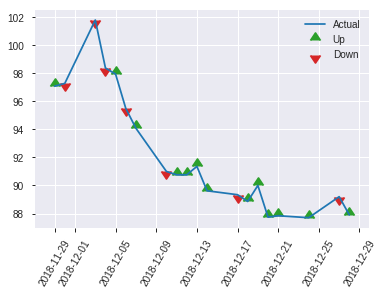


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21314758354811938
RMSE: 0.46167909152150194
LogLoss: 0.613426657751404
Null degrees of freedom: 250
Residual degrees of freedom: 225
Null deviance: 348.2966965690315
Residual deviance: 307.9401821912048
AIC: 359.9401821912048
AUC: 0.7219326128417037
pr_auc: 0.6270957130965936
Gini: 0.44386522568340747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29434811293768554: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   71   0.5462   (71.0/130.0)
1      10   111  0.0826   (10.0/121.0)
Total  69   182  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294348     0.732673  181
max f2                       0.181887     0.858369  214
max f0point5                 0.389414     0.670651  157
max accuracy                 0.389414     0.693227  157
max precision                0.753104     0.703704  26
max recall                   0.0989536    1         239
max specificity              0.915508     0.992308  0
max absolute_mcc             0.294348     0.415445  181
max min_per_class_accuracy   0.488245     0.653846  124
max mean_per_class_accuracy  0.385097     0.698411  159

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 46.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.864793           0.69146    0.69146            0.333333         0.890586   0.333333                    0.890586            0.00826446      0.00826446                 -30.854    -30.854
    2        0.0239044                   0.841802           1.38292    1.03719            0.666667         0.849522   0.5                         0.870054            0.0165289       0.0247934                  38.292     3.71901
    3        0.0318725                   0.812103           0          0.777893           0                0.812461   0.375                       0.855656            0               0.0247934                  -100       -22.2107
    4        0.0438247                   0.806043           1.38292    0.9429             0.666667         0.808414   0.454545                    0.842772            0.0165289       0.0413223                  38.292     -5.70999
    5        0.0517928                   0.795328           2.07438    1.11697            1                0.80017    0.538462                    0.836218            0.0165289       0.0578512                  107.438    11.6974
    6        0.103586                    0.754531           1.75524    1.43611            0.846154         0.776035   0.692308                    0.806126            0.0909091       0.14876                    75.5245    43.6109
    7        0.151394                    0.720963           1.21006    1.36472            0.583333         0.738588   0.657895                    0.784798            0.0578512       0.206612                   21.0055    36.4724
    8        0.203187                    0.693468           1.27654    1.34225            0.615385         0.704645   0.647059                    0.764367            0.0661157       0.272727                   27.6542    34.2246
    9        0.302789                    0.617491           1.49355    1.39202            0.72             0.660894   0.671053                    0.73033             0.14876         0.421488                   49.3554    39.2018
    10       0.40239                     0.55324            1.24463    1.35554            0.6              0.586491   0.653465                    0.694726            0.123967        0.545455                   24.4628    35.5536
    11       0.501992                    0.479841           1.16165    1.31707            0.56             0.516905   0.634921                    0.659444            0.115702        0.661157                   16.1653    31.7067
    12       0.601594                    0.402294           1.3276     1.31881            0.64             0.437571   0.635762                    0.62271             0.132231        0.793388                   32.7603    31.8811
    13       0.701195                    0.323442           0.995702   1.27292            0.48             0.365689   0.613636                    0.586202            0.0991736       0.892562                   -0.429752  27.2915
    14       0.800797                    0.226109           0.497851   1.17651            0.24             0.263952   0.567164                    0.546121            0.0495868       0.942149                   -50.2149   17.6514
    15       0.900398                    0.153939           0.497851   1.10144            0.24             0.185163   0.530973                    0.506192            0.0495868       0.991736                   -50.2149   10.1441
    16       1                           0.0158717          0.0829752  1                  0.04             0

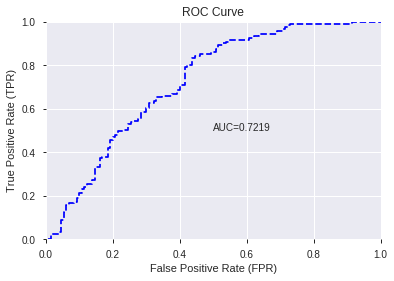

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


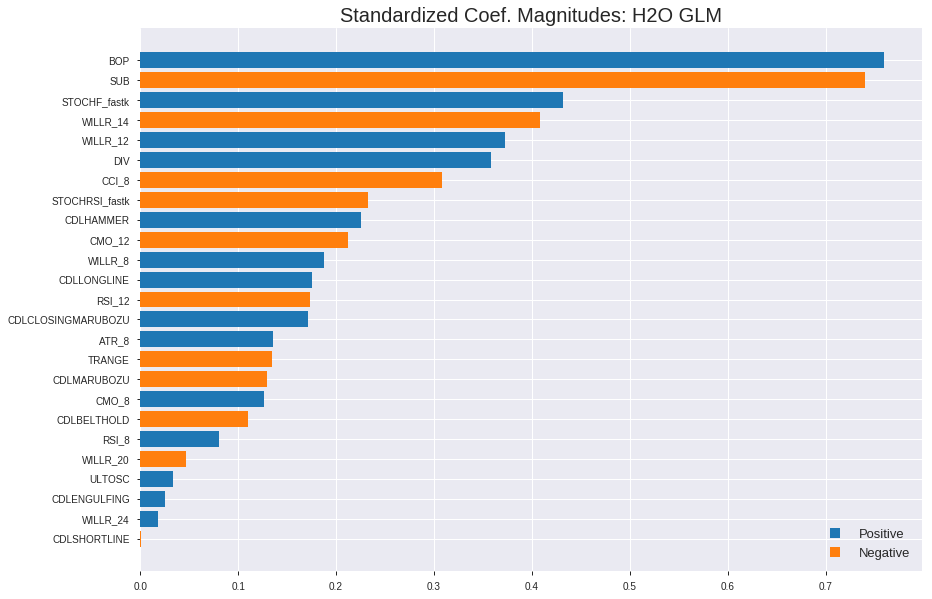

'log_likelihood'
--2019-08-25 15:46:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_154605_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_154605_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'WILLR_14',
 'WILLR_12',
 'DIV',
 'CCI_8',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'CMO_12',
 'WILLR_8',
 'CDLLONGLINE',
 'RSI_12',
 'CDLCLOSINGMARUBOZU',
 'ATR_8',
 'TRANGE',
 'CDLMARUBOZU',
 'CMO_8',
 'CDLBELTHOLD',
 'RSI_8',
 'WILLR_20',
 'ULTOSC',
 'CDLENGULFING',
 'WILLR_24',
 'CDLSHORTLINE']

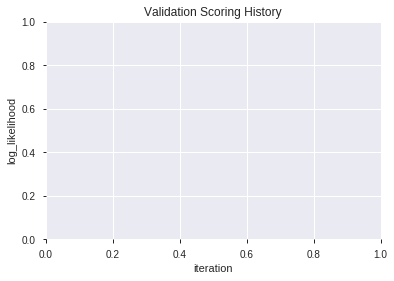

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_154617_model_4  0.721297  0.613865              0.321392  0.460867  0.212399
1               XGBoost_2_AutoML_20190825_154617  0.713541  0.620539              0.309854  0.464017  0.215312
2  XGBoost_grid_1_AutoML_20190825_154617_model_2  0.711634  0.619991              0.320248  0.463334  0.214679
3  XGBoost_grid_1_AutoML_20190825_154617_model_6  0.711634  0.626753              0.320820  0.466080  0.217231
4  XGBoost_grid_1_AutoML_20190825_154617_model_1  0.708773  0.625899              0.334774  0.465701  0.216877
5  XGBoost_grid_1_AutoML_20190825_154617_model_7  0.706739  0.634407              0.351430  0.469366  0.220304
6  XGBoost_grid_1_AutoML_20190825_154617_model_3  0.706357  0.627558              0.327940  0.466676  0.217787
7               XGBoost_3_AutoML_20190825_154617  0.704959  0.626177              0.334774  0.466656  0.217768
8               XGBoost_1_AutoML_20190825_154617  0.698919  0.636763              0.363541  0.470599  0.221463
9  XGBoost_grid_1_AutoML_20190825_154617_model_5  0.697266  0.644498              0.340750  0.473771  0.224459

variable  relative_importance  scaled_importance  percentage
0                  BOP          2176.238037           1.000000    0.481311
1                  SUB           459.598083           0.211189    0.101648
2                  DIV           266.229980           0.122335    0.058881
3               TRANGE           217.322174           0.099861    0.048064
4              WILLR_8           189.845825           0.087236    0.041988
5                ATR_8           165.292389           0.075953    0.036557
6         STOCHF_fastk           143.221695           0.065812    0.031676
7                CCI_8           143.140167           0.065774    0.031658
8               CMO_12           137.794037           0.063318    0.030475
9               ULTOSC           109.729294           0.050422    0.024268
10            WILLR_20            97.326332           0.044722    0.021525
11      STOCHRSI_fastk            92.551880           0.042528    0.020469
12               CMO_8            82.953491           0.038118    0.018347
13            WILLR_24            75.863701           0.034860    0.016779
14         CDLLONGLINE            45.203785           0.020772    0.009998
15            WILLR_14            42.920750           0.019722    0.009493
16            WILLR_12            36.311474           0.016685    0.008031
17  CDLCLOSINGMARUBOZU            31.652622           0.014545    0.007001
18         CDLBELTHOLD             8.281853           0.003806    0.001832

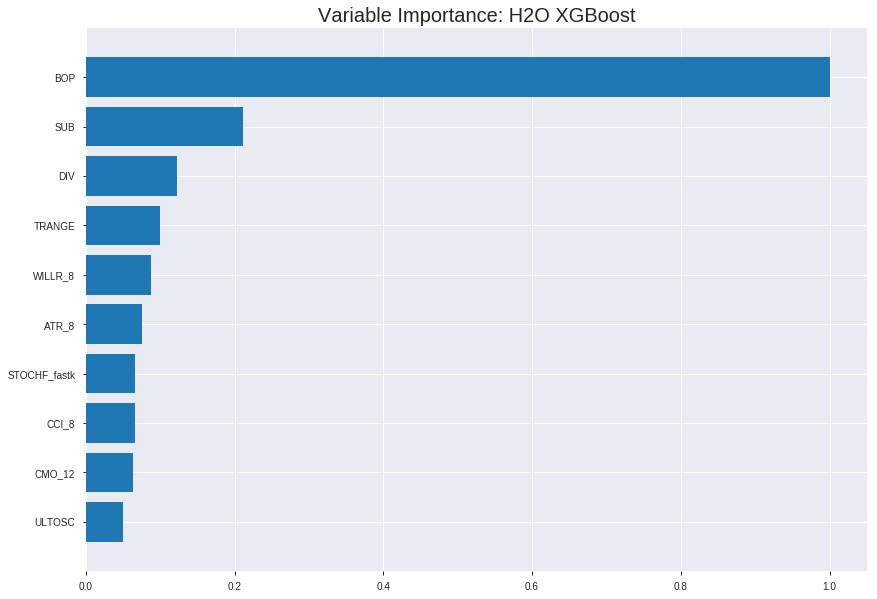

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_154617_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1839016218681894
RMSE: 0.42883752385745044
LogLoss: 0.5481025983391565
Mean Per-Class Error: 0.27200255185074274
AUC: 0.8056479227153774
pr_auc: 0.8037279892982894
Gini: 0.6112958454307549
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4580087761084239: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      500  363   0.4206   (363.0/863.0)
1      135  755   0.1517   (135.0/890.0)
Total  635  1118  0.2841   (498.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458009     0.751992  228
max f2                       0.240231     0.857824  330
max f0point5                 0.588772     0.745614  149
max accuracy                 0.541159     0.727895  178
max precision                0.873934     1         0
max recall                   0.120793     1         387
max specificity              0.873934     1         0
max absolute_mcc             0.541159     0.45595   178
max min_per_class_accuracy   0.538439     0.726966  180
max mean_per_class_accuracy  0.541159     0.727997  178

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.837903           1.96966   1.96966            1                0.849484  1                           0.849484            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.821097           1.86024   1.91495            0.944444         0.831141  0.972222                    0.840312            0.0191011       0.0393258                  86.0237   91.495
    3        0.0302339                   0.811995           1.8538    1.89534            0.941176         0.816761  0.962264                    0.832758            0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.803319           1.86024   1.88644            0.944444         0.807653  0.957746                    0.826393            0.0191011       0.0764045                  86.0237   88.6438
    5        0.0501997                   0.794993           1.8538    1.88013            0.941176         0.798479  0.954545                    0.821001            0.0179775       0.094382                   85.38     88.0133
    6        0.100399                    0.761178           1.65631   1.76822            0.840909         0.777136  0.897727                    0.799068            0.0831461       0.177528                   65.6307   76.822
    7        0.150029                    0.735531           1.65271   1.73001            0.83908          0.747972  0.878327                    0.782166            0.0820225       0.259551                   65.2706   73.0008
    8        0.200228                    0.709604           1.72346   1.72837            0.875            0.723282  0.877493                    0.767403            0.0865169       0.346067                   72.3455   72.8365
    9        0.300057                    0.653059           1.44067   1.63265            0.731429         0.682244  0.828897                    0.739071            0.14382         0.489888                   44.0668   63.2648
    10       0.399886                    0.594086           1.26058   1.53977            0.64             0.622288  0.78174                     0.709917            0.125843        0.61573                    26.0584   53.9765
    11       0.500285                    0.539133           1.07436   1.44637            0.545455         0.566573  0.734322                    0.68115             0.107865        0.723596                   7.43616   44.6366
    12       0.600114                    0.47608            0.900417  1.35555            0.457143         0.507593  0.688213                    0.652279            0.0898876       0.813483                   -9.95827  35.5547
    13       0.699943                    0.406809           0.77661   1.27298            0.394286         0.445353  0.646292                    0.622766            0.0775281       0.891011                   -22.339   27.2977
    14       0.799772                    0.278788           0.551506  1.18292            0.28             0.344617  0.600571                    0.588047            0.0550562       0.946067                   -44.8494  18.2922
    15       0.899601                    0.190406           0.393933  1.09537            0.2              0.232654  0.556119                    0.548609            0.0393258       0.985393                   -60.6067  9.53674
    16       1                           0.097753           0.145486  1                  0.0738636        0.140556  0.507701                    0.507641           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20994826603211955
RMSE: 0.4582011196321104
LogLoss: 0.6068269559388657
Mean Per-Class Error: 0.32114532494220405
AUC: 0.7234860647315695
pr_auc: 0.7392189843935076
Gini: 0.446972129463139
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37642645835876465: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      76   153  0.6681   (153.0/229.0)
1      21   251  0.0772   (21.0/272.0)
Total  97   404  0.3473   (174.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376426     0.742604  312
max f2                       0.165976     0.868167  369
max f0point5                 0.619747     0.711207  164
max accuracy                 0.551478     0.674651  206
max precision                0.866025     1         0
max recall                   0.106207     1         399
max specificity              0.866025     1         0
max absolute_mcc             0.619747     0.358719  164
max min_per_class_accuracy   0.571336     0.659389  191
max mean_per_class_accuracy  0.619747     0.678855  164

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 55.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.845168           1.84191   1.84191            1                0.850706  1                           0.850706            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.831924           1.84191   1.84191            1                0.835916  1                           0.843984            0.0183824       0.0404412                  84.1912   84.1912
    3        0.0319361                   0.82021            1.84191   1.84191            1                0.824678  1                           0.837951            0.0183824       0.0588235                  84.1912   84.1912
    4        0.0419162                   0.814879           1.47353   1.7542             0.8              0.81643   0.952381                    0.832827            0.0147059       0.0735294                  47.3529   75.4202
    5        0.0518962                   0.808722           0.736765  1.55854            0.4              0.810501  0.846154                    0.828533            0.00735294      0.0808824                  -26.3235  55.8541
    6        0.101796                    0.783519           1.32618   1.44464            0.72             0.794875  0.784314                    0.812034            0.0661765       0.147059                   32.6176   44.4637
    7        0.151697                    0.760563           1.47353   1.45414            0.8              0.770054  0.789474                    0.798225            0.0735294       0.220588                   47.3529   45.4141
    8        0.201597                    0.736599           1.32618   1.42247            0.72             0.746249  0.772277                    0.78536             0.0661765       0.286765                   32.6176   42.2467
    9        0.301397                    0.688852           1.39985   1.41498            0.76             0.71522   0.768212                    0.762135            0.139706        0.426471                   39.9853   41.4979
    10       0.401198                    0.643458           1.2525    1.37456            0.68             0.665097  0.746269                    0.737996            0.125           0.551471                   25.25     37.4561
    11       0.500998                    0.580534           0.920956  1.2842             0.5              0.610647  0.697211                    0.712628            0.0919118       0.643382                   -7.90441  28.4201
    12       0.600798                    0.533677           0.957794  1.22998            0.52             0.554982  0.667774                    0.686441            0.0955882       0.738971                   -4.22059  22.9981
    13       0.700599                    0.464691           0.884118  1.18071            0.48             0.499834  0.641026                    0.659858            0.0882353       0.827206                   -11.5882  18.0713
    14       0.800399                    0.39679            0.884118  1.14373            0.48             0.430876  0.620948                    0.631307            0.0882353       0.915441                   -11.5882  14.3731
    15       0.9002                      0.236397           0.589412  1.08228            0.32             0.300795  0.587583                    0.594665            0.0588235       0.974265                   -41.0588  8.22763
    16       1                           0.106207           0.257868  1                  0.14             0.160084  0.542914                    0.551293         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:46:23  2.074 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.457086
    2019-08-25 15:46:23  2.112 sec   5                  0.479933         0.65358             0.768823        0.739953           1.96966          0.340559                         0.483317           0.660156              0.721784          0.717095             1.84191            0.355289
    2019-08-25 15:46:23  2.144 sec   10                 0.466264         0.626774            0.773841        0.764879           1.96966          0.319452                         0.473267           0.640258              0.723093          0.728453             1.84191            0.349301
    2019-08-25 15:46:23  2.178 sec   15                 0.457127         0.60852             0.781084        0.779026           1.96966          0.30405                          0.46716            0.627812              0.726376          0.736163             1.84191            0.345309
    2019-08-25 15:46:23  2.215 sec   20                 0.450244         0.594424            0.783591        0.780843           1.96966          0.31603                          0.463119           0.619256              0.724786          0.733061             1.61167            0.349301
    2019-08-25 15:46:23  2.254 sec   25                 0.445779         0.585075            0.787292        0.783971           1.96966          0.299487                         0.460087           0.612769              0.729177          0.737567             1.84191            0.337325
    2019-08-25 15:46:23  2.307 sec   30                 0.441897         0.576866            0.791421        0.790149           1.86024          0.294353                         0.458354           0.608758              0.730719          0.742199             1.84191            0.347305
    2019-08-25 15:46:23  2.375 sec   35                 0.43888          0.5701              0.792901        0.792022           1.96966          0.308614                         0.457318           0.606175              0.731762          0.745959             1.84191            0.347305
    2019-08-25 15:46:23  2.434 sec   40                 0.436273         0.564369            0.795291        0.793488           1.96966          0.302339                         0.457101           0.605346              0.729739          0.74372              1.84191            0.343313
    2019-08-25 15:46:23  2.504 sec   45                 0.434421         0.560203            0.796847        0.794382           1.96966          0.297775                         0.457122           0.605129              0.728583          0.741982             1.84191            0.343313
    2019-08-25 15:46:23  2.572 sec   50                 0.432423         0.556017            0.800861        0.799326           1.96966          0.301198                         0.457299           0.605234              0.727572          0.743039             1.84191            0.341317
    2019-08-25 15:46:23  2.640 sec   55                 0.430661         0.551996            0.802525        0.800858           1.96966          0.300057                         0.457862           0.606249              0.724971          0

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 2176.24                1                    0.481311
SUB                 459.598                0.211189             0.101648
DIV                 266.23                 0.122335             0.0588812
TRANGE              217.322                0.0998614            0.0480644
WILLR_8             189.846                0.0872358            0.0419876
ATR_8               165.292                0.0759533            0.0365572
STOCHF_fastk        143.222                0.0658116            0.0316759
CCI_8               143.14                 0.0657741            0.0316578
CMO_12              137.794                0.0633175            0.0304754
ULTOSC              109.729                0.0504215            0.0242685
WILLR_20            97.3263                0.0447223            0.0215253
STOCHRSI_fastk      92.5519                0.0425284            0.0204694
CMO_8               82.9535                0.0381178            0.0183465
WILLR_24            75.8637                0.03486              0.0167785
CDLLONGLINE         45.2038                0.0207715            0.00999757
WILLR_14            42.9207                0.0197225            0.00949264
WILLR_12            36.3115                0.0166854            0.00803089
CDLCLOSINGMARUBOZU  31.6526                0.0145447            0.0070005
CDLBELTHOLD         8.28185                0.00380558           0.00183167

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7092198581560283)

('auc', 0.7212968849332486)

('logloss', 0.6138652486167023)

('mean_per_class_error', 0.30915448188175465)

('rmse', 0.460867384800709)

('mse', 0.21239874637304476)

xgboost prediction progress: |████████████████████████████████████████████| 100%


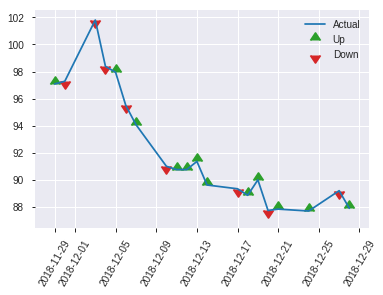


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21239874637304476
RMSE: 0.460867384800709
LogLoss: 0.6138652486167023
Mean Per-Class Error: 0.30915448188175465
AUC: 0.7212968849332486
pr_auc: 0.6362944498544068
Gini: 0.44259376986649723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40873757004737854: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   61   0.4692   (61.0/130.0)
1      21   100  0.1736   (21.0/121.0)
Total  90   161  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408738     0.70922   160
max f2                       0.145382     0.840336  229
max f0point5                 0.503422     0.673222  134
max accuracy                 0.503422     0.689243  134
max precision                0.778673     0.722222  17
max recall                   0.120953     1         239
max specificity              0.831738     0.992308  0
max absolute_mcc             0.503422     0.382543  134
max min_per_class_accuracy   0.538814     0.676923  123
max mean_per_class_accuracy  0.503422     0.690846  134

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.821077           0.69146   0.69146            0.333333         0.831137  0.333333                    0.831137            0.00826446      0.00826446                 -30.854   -30.854
    2        0.0239044                   0.809859           1.38292   1.03719            0.666667         0.810575  0.5                         0.820856            0.0165289       0.0247934                  38.292    3.71901
    3        0.0318725                   0.802904           1.03719   1.03719            0.5              0.805025  0.5                         0.816898            0.00826446      0.0330579                  3.71901   3.71901
    4        0.0438247                   0.795232           1.38292   1.13148            0.666667         0.798982  0.545455                    0.812012            0.0165289       0.0495868                  38.292    13.148
    5        0.0517928                   0.78904            2.07438   1.27654            1                0.79284   0.615385                    0.809063            0.0165289       0.0661157                  107.438   27.6542
    6        0.103586                    0.760522           1.27654   1.27654            0.615385         0.772584  0.615385                    0.790823            0.0661157       0.132231                   27.6542   27.6542
    7        0.151394                    0.738912           1.72865   1.41931            0.833333         0.748433  0.684211                    0.777437            0.0826446       0.214876                   72.865    41.9313
    8        0.203187                    0.721948           1.27654   1.38292            0.615385         0.728612  0.666667                    0.764991            0.0661157       0.280992                   27.6542   38.292
    9        0.302789                    0.675651           1.49355   1.41931            0.72             0.698799  0.684211                    0.743217            0.14876         0.429752                   49.3554   41.9313
    10       0.40239                     0.607195           1.41058   1.41715            0.68             0.636634  0.683168                    0.716835            0.140496        0.570248                   41.0579   41.7151
    11       0.501992                    0.529859           1.16165   1.36646            0.56             0.573668  0.65873                     0.688429            0.115702        0.68595                    16.1653   36.6457
    12       0.601594                    0.457821           0.912727  1.29134            0.44             0.494993  0.622517                    0.656403            0.0909091       0.77686                    -8.72727  29.1336
    13       0.701195                    0.358956           0.829752  1.22577            0.4              0.40453   0.590909                    0.620626            0.0826446       0.859504                   -17.0248  22.577
    14       0.800797                    0.260806           0.746777  1.16619            0.36             0.298047  0.562189                    0.580504            0.0743802       0.933884                   -25.3223  16.6194
    15       0.900398                    0.153892           0.497851  1.09226            0.24             0.217695  0.526549                    0.54037             0.0495868       0.983471                   -50.2149  9.22621
    16       1                           0.103124           0.16595   1                  0.08             0.12689   0.482072                    0.499187            

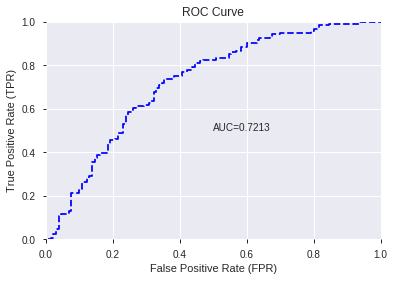

This function is available for GLM models only


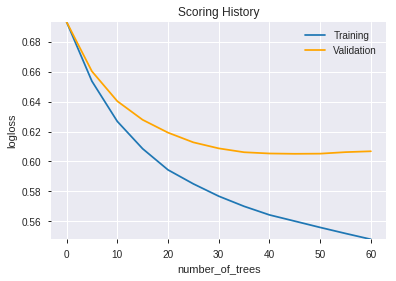

--2019-08-25 15:46:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_154617_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_154617_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'TRANGE',
 'WILLR_8',
 'ATR_8',
 'STOCHF_fastk',
 'CCI_8',
 'CMO_12',
 'ULTOSC',
 'WILLR_20',
 'STOCHRSI_fastk',
 'CMO_8',
 'WILLR_24',
 'CDLLONGLINE',
 'WILLR_14',
 'WILLR_12',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

91

['BBANDS_middleband_14_7_5',
 'BBANDS_lowerband_14_7_5',
 'SMA_20',
 'BBANDS_middleband_20_2_4',
 'BBANDS_upperband_20_3_5',
 'BBANDS_middleband_20_5_3',
 'BBANDS_upperband_20_7_5',
 'BBANDS_lowerband_30_5_2',
 'BBANDS_lowerband_30_5_3',
 'BBANDS_upperband_30_7_5',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'MFI_8',
 'PLUS_DI_8',
 'ROCR100_8',
 'WILLR_8',
 'ADX_12',
 'aroondown_12',
 'AROONOSC_12',
 'MINUS_DM_12',
 'ROC_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'MACDFIX_signal_14',
 'MOM_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'WILLR_14',
 'ADX_20',
 'aroondown_20',
 'aroonup_20',
 'MINUS_DI_20',
 'MOM_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROCP_20',
 'ROCR100_20',
 'WILLR_20',
 'CMO_24',
 'PLUS_DM_24',
 'ROCR_24',
 'WILLR_24',
 'aroondown_30',
 'aroonup_30',
 'MINUS_DI_30',
 'PLUS_DM_30',
 'MACD_hist',
 'MACDEXT',
 'MACDEXT_signal',
 'MACDEXT_hist',
 'PPO',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOS

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190825_154745  0.752003  0.598547              0.282072  0.450982  0.203385
1  DeepLearning_grid_1_AutoML_20190825_154745_model_6  0.730388  0.611858              0.304577  0.460070  0.211664
2  DeepLearning_grid_1_AutoML_20190825_154745_model_2  0.726192  0.698895              0.334488  0.481608  0.231946
3  DeepLearning_grid_1_AutoML_20190825_154745_model_9  0.726128  0.614897              0.316688  0.460653  0.212201
4  DeepLearning_grid_1_AutoML_20190825_154745_model_8  0.722441  0.629576              0.302448  0.463511  0.214842
5  DeepLearning_grid_1_AutoML_20190825_154745_model_3  0.718055  0.703801              0.344596  0.487638  0.237791
6  DeepLearning_grid_1_AutoML_20190825_154745_model_7  0.711316  0.696449              0.320248  0.479088  0.229525
7  DeepLearning_grid_1_AutoML_20190825_154745_model_5  0.709981  0.638885              0.335346  0.469297  0.220240
8  DeepLearning_grid_1_AutoML_20190825_154745_model_4  0.696694  0.810664              0.326796  0.504163  0.254180
9  DeepLearning_grid_1_AutoML_20190825_154745_model_1  0.682072  0.969335              0.398156  0.526279  0.276970

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_20_2_4             1.000000           1.000000    0.015741
1                  PLUS_DI_8             0.994527           0.994527    0.015655
2                        BOP             0.991011           0.991011    0.015600
3                     CMO_24             0.937706           0.937706    0.014761
4             STOCHRSI_fastd             0.900251           0.900251    0.014171
..                       ...                  ...                ...         ...
86              aroondown_20             0.470590           0.470590    0.007408
87         MACDFIX_signal_14             0.455883           0.455883    0.007176
88               HT_DCPERIOD             0.444561           0.444561    0.006998
89                ROCR100_14             0.423778           0.423778    0.006671
90              aroondown_12             0.390019           0.390019    0.006139

[91 rows x 4 columns]

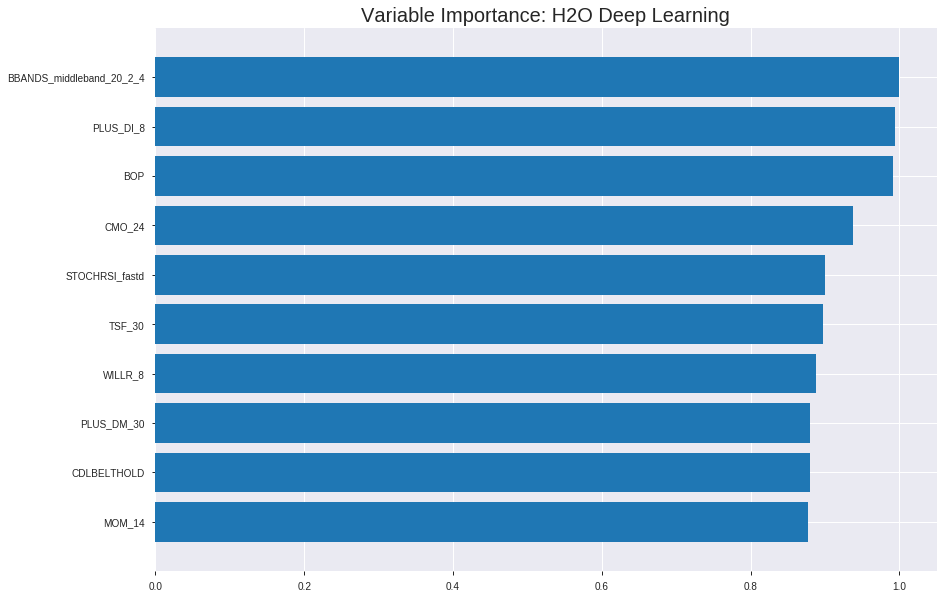

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190825_154745


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20406061597845937
RMSE: 0.4517306896575208
LogLoss: 0.5981704704166584
Mean Per-Class Error: 0.29001653495124136
AUC: 0.7687235538427487
pr_auc: 0.7751687593435052
Gini: 0.5374471076854974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2889845861941563: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      481  382   0.4426   (382.0/863.0)
1      154  736   0.173    (154.0/890.0)
Total  635  1118  0.3058   (536.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288985     0.733068  265
max f2                       0.0852544    0.844156  362
max f0point5                 0.380068     0.711347  226
max accuracy                 0.35926      0.710782  234
max precision                0.991688     1         0
max recall                   0.0105527    1         396
max specificity              0.991688     1         0
max absolute_mcc             0.35926      0.422485  234
max min_per_class_accuracy   0.402236     0.694382  216
max mean_per_class_accuracy  0.35926      0.709983  234

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 41.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.954941           1.86024   1.86024            0.944444         0.973152   0.944444                    0.973152            0.0191011       0.0191011                  86.0237   86.0237
    2        0.0205362                   0.933312           1.96966   1.91495            1                0.940349   0.972222                    0.956751            0.0202247       0.0393258                  96.9663   91.495
    3        0.0302339                   0.904548           1.8538    1.89534            0.941176         0.923046   0.962264                    0.94594             0.0179775       0.0573034                  85.38     89.5336
    4        0.040502                    0.889232           1.86024   1.88644            0.944444         0.894836   0.957746                    0.932984            0.0191011       0.0764045                  86.0237   88.6438
    5        0.0501997                   0.859763           1.73794   1.85775            0.882353         0.874707   0.943182                    0.921726            0.0168539       0.0932584                  73.7938   85.775
    6        0.100399                    0.767724           1.76822   1.81299            0.897727         0.811807   0.920455                    0.866767            0.088764        0.182022                   76.822    81.2985
    7        0.150029                    0.700481           1.69799   1.77494            0.862069         0.73525    0.901141                    0.823261            0.0842697       0.266292                   69.7985   77.4943
    8        0.200228                    0.650965           1.34295   1.66664            0.681818         0.672546   0.846154                    0.785475            0.0674157       0.333708                   34.2952   66.6638
    9        0.300057                    0.564506           1.31686   1.55027            0.668571         0.607241   0.787072                    0.726176            0.131461        0.465169                   31.686    55.0267
    10       0.399886                    0.488951           1.06925   1.43018            0.542857         0.526879   0.726106                    0.676423            0.106742        0.57191                    6.92456   43.0183
    11       0.500285                    0.402255           1.20866   1.38573            0.613636         0.446293   0.703535                    0.63024             0.121348        0.693258                   20.8657   38.5726
    12       0.600114                    0.318604           1.04674   1.32934            0.531429         0.362015   0.674905                    0.585621            0.104494        0.797753                   4.67352   32.9335
    13       0.699943                    0.232302           0.731589  1.24408            0.371429         0.276517   0.631622                    0.541535            0.0730337       0.870787                   -26.8411  24.4082
    14       0.799772                    0.157672           0.506485  1.15201            0.257143         0.195015   0.584879                    0.498282            0.0505618       0.921348                   -49.3515  15.2014
    15       0.899601                    0.0917906          0.506485  1.08038            0.257143         0.123758   0.54851                     0.456721            0.0505618       0.97191                    -49.3515  8.03795
    16       1                           0.00244877         0.279782  1                  0.142045         0.0529902  0.507701                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2355617513782345
RMSE: 0.48534704220612546
LogLoss: 0.6740547968551794
Mean Per-Class Error: 0.3634488183919856
AUC: 0.6869541484716157
pr_auc: 0.7124584220177435
Gini: 0.37390829694323147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2112584509819194: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   154  0.6725   (154.0/229.0)
1      26   246  0.0956   (26.0/272.0)
Total  101  400  0.3593   (180.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211258     0.732143  312
max f2                       0.0629679    0.859974  375
max f0point5                 0.37934      0.668683  232
max accuracy                 0.24848      0.650699  295
max precision                0.950107     1         0
max recall                   0.00898868   1         398
max specificity              0.950107     1         0
max absolute_mcc             0.24848      0.300934  295
max min_per_class_accuracy   0.441793     0.624454  200
max mean_per_class_accuracy  0.37934      0.636551  232

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 44.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.918892           1.84191   1.84191            1                0.935074   1                           0.935074            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.908604           1.84191   1.84191            1                0.914311   1                           0.925636            0.0183824       0.0404412                  84.1912   84.1912
    3        0.0319361                   0.868113           1.47353   1.72679            0.8              0.885819   0.9375                      0.913193            0.0147059       0.0551471                  47.3529   72.6792
    4        0.0419162                   0.84738            1.47353   1.66649            0.8              0.851021   0.904762                    0.89839             0.0147059       0.0698529                  47.3529   66.6492
    5        0.0518962                   0.826164           1.47353   1.62938            0.8              0.83877    0.884615                    0.886925            0.0147059       0.0845588                  47.3529   62.9383
    6        0.101796                    0.76164            1.39985   1.51687            0.76             0.789532   0.823529                    0.839183            0.0698529       0.154412                   39.9853   51.6869
    7        0.151697                    0.691413           1.17882   1.40567            0.64             0.716254   0.763158                    0.798746            0.0588235       0.213235                   17.8824   40.567
    8        0.201597                    0.650189           1.2525    1.36776            0.68             0.665672   0.742574                    0.765807            0.0625          0.275735                   25.25     36.7756
    9        0.301397                    0.589593           1.2525    1.32959            0.68             0.616249   0.721854                    0.716284            0.125           0.400735                   25.25     32.9592
    10       0.401198                    0.51676            1.14199   1.28292            0.62             0.555879   0.696517                    0.676383            0.113971        0.514706                   14.1985   28.2924
    11       0.500998                    0.44742            0.957794  1.21816            0.52             0.476691   0.661355                    0.636603            0.0955882       0.610294                   -4.22059  21.8157
    12       0.600798                    0.384877           1.10515   1.19938            0.6              0.414892   0.651163                    0.599774            0.110294        0.720588                   10.5147   19.9384
    13       0.700599                    0.299427           0.920956  1.15972            0.5              0.346563   0.62963                     0.563704            0.0919118       0.8125                     -7.90441  15.9722
    14       0.800399                    0.206746           0.920956  1.12995            0.5              0.252685   0.613466                    0.524924            0.0919118       0.904412                   -7.90441  12.9951
    15       0.9002                      0.115375           0.515735  1.06186            0.28             0.165273   0.576497                    0.485051            0.0514706       0.955882                   -48.4265  6.1856
    16       1                           0.00841916         0.442059  1                  0.24             0.0645326  0.542914                    0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:47:45  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:47:45  0.077 sec   51558 obs/sec     1         1             1753       0.514332         0.787352            -0.0584        0.662949        0.659298           1.75081          0.427268                         0.511683           0.751532              -0.0550502       0.637418          0.694104             1.84191            0.42515
    2019-08-25 15:47:46  0.339 sec   63514 obs/sec     10        10            17530      0.451731         0.59817             0.183564       0.768724        0.775169           1.86024          0.305762                         0.485347           0.674055              0.0507604        0.686954          0.712458             1.84191            0.359281

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BBANDS_middleband_20_2_4  1.0                    1.0                  0.015741332728495632
PLUS_DI_8                 0.9945269823074341     0.9945269823074341   0.01565518013596801
BOP                       0.9910112023353577     0.9910112023353577   0.015599837073627375
CMO_24                    0.9377059936523438     0.9377059936523438   0.014760742047586158
STOCHRSI_fastd            0.9002509713172913     0.9002509713172913   0.014171150078656861
---                       ---                    ---                  ---
aroondown_20              0.4705902934074402     0.4705902934074402   0.007407718387326901
MACDFIX_signal_14         0.45588260889053345    0.45588260889053345  0.0071761998316805286
HT_DCPERIOD               0.4445606470108032     0.4445606470108032   0.006997977062592351
ROCR100_14                0.4237782657146454     0.4237782657146454   0.006670834683719066
aroondown_12              0.39001941680908203    0.39001941680908203  0.006139425410565583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.7410071942446043)

('auc', 0.7520025429116338)

('logloss', 0.5985468466623555)

('mean_per_class_error', 0.27965670692943423)

('rmse', 0.45098184030287936)

('mse', 0.2033846202829718)

deeplearning prediction progress: |███████████████████████████████████████| 100%


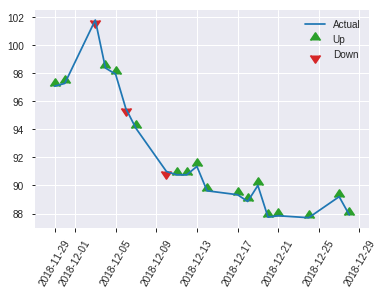


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2033846202829718
RMSE: 0.45098184030287936
LogLoss: 0.5985468466623555
Mean Per-Class Error: 0.27965670692943423
AUC: 0.7520025429116338
pr_auc: 0.6652802347490926
Gini: 0.5040050858232676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40648244566790687: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   54   0.4154   (54.0/130.0)
1      18   103  0.1488   (18.0/121.0)
Total  94   157  0.2869   (72.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406482     0.741007  156
max f2                       0.0646721    0.841446  234
max f0point5                 0.461913     0.695035  145
max accuracy                 0.461913     0.717131  145
max precision                0.961089     1         0
max recall                   0.0646721    1         234
max specificity              0.961089     1         0
max absolute_mcc             0.406482     0.449979  156
max min_per_class_accuracy   0.517441     0.676923  123
max mean_per_class_accuracy  0.461913     0.720343  145

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 47.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.928963           0.69146   0.69146            0.333333         0.950918   0.333333                    0.950918            0.00826446      0.00826446                 -30.854   -30.854
    2        0.0239044                   0.909515           2.07438   1.38292            1                0.914423   0.666667                    0.932671            0.0247934       0.0330579                  107.438   38.292
    3        0.0318725                   0.893871           1.03719   1.29649            0.5              0.904002   0.625                       0.925504            0.00826446      0.0413223                  3.71901   29.6488
    4        0.0438247                   0.877044           0.69146   1.13148            0.333333         0.881331   0.545455                    0.913457            0.00826446      0.0495868                  -30.854   13.148
    5        0.0517928                   0.861575           2.07438   1.27654            1                0.868302   0.615385                    0.90651             0.0165289       0.0661157                  107.438   27.6542
    6        0.103586                    0.748603           1.59568   1.43611            0.769231         0.796497   0.692308                    0.851503            0.0826446       0.14876                    59.5677   43.6109
    7        0.151394                    0.70691            1.55579   1.4739             0.75             0.728816   0.710526                    0.81276             0.0743802       0.22314                    55.5785   47.3902
    8        0.203187                    0.656395           1.59568   1.50494            0.769231         0.682523   0.72549                     0.779562            0.0826446       0.305785                   59.5677   50.4942
    9        0.302789                    0.601262           1.57653   1.52849            0.76             0.62586    0.736842                    0.729002            0.157025        0.46281                    57.6529   52.8491
    10       0.40239                     0.547472           1.07868   1.41715            0.52             0.570061   0.683168                    0.68966             0.107438        0.570248                   7.86777   41.7151
    11       0.501992                    0.513163           1.16165   1.36646            0.56             0.530482   0.65873                     0.658077            0.115702        0.68595                    16.1653   36.6457
    12       0.601594                    0.432314           1.41058   1.37376            0.68             0.477623   0.662252                    0.628201            0.140496        0.826446                   41.0579   37.3762
    13       0.701195                    0.3433             0.663802  1.27292            0.32             0.382461   0.613636                    0.593295            0.0661157       0.892562                   -33.6198  27.2915
    14       0.800797                    0.250892           0.580826  1.18683            0.28             0.30177    0.572139                    0.557035            0.0578512       0.950413                   -41.9174  18.6834
    15       0.900398                    0.147743           0.331901  1.09226            0.16             0.194884   0.526549                    0.516974            0.0330579       0.983471                   -66.8099  9.22621
    16       1                           0.00543234         0.16595   1                  0.08             0.0567596  0.482072                    0

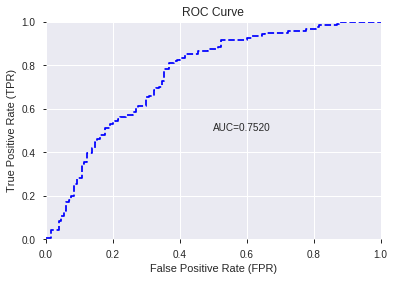

This function is available for GLM models only


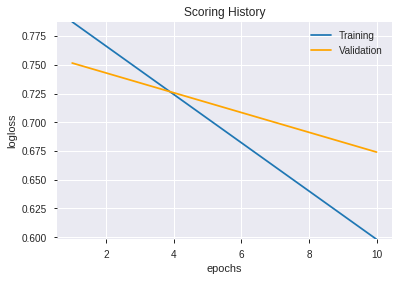

--2019-08-25 15:58:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190825_154745',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190825_154745',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_be19'

['BBANDS_middleband_20_2_4',
 'PLUS_DI_8',
 'BOP',
 'CMO_24',
 'STOCHRSI_fastd',
 'TSF_30',
 'WILLR_8',
 'PLUS_DM_30',
 'CDLBELTHOLD',
 'MOM_14',
 'MACDEXT_hist',
 'CDLCLOSINGMARUBOZU',
 'AROONOSC_12',
 'CORREL_30',
 'CDLSPINNINGTOP',
 'TRANGE',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'ROC_12',
 'aroonup_14',
 'MACDEXT_signal',
 'ATR_12',
 'ADX_20',
 'aroondown_30',
 'MINUS_DM_12',
 'CORREL_14',
 'LINEARREG_SLOPE_14',
 'ROCP_20',
 'STOCHF_fastk',
 'BETA_24',
 'ATR_8',
 'PLUS_DI_20',
 'TSF_24',
 'ROCR100_20',
 'CDLSHORTLINE',
 'aroonup_20',
 'BBANDS_upperband_20_3_5',
 'CORREL_20',
 'BBANDS_upperband_30_7_5',
 'MINUS_DI_30',
 'MACD_hist',
 'WILLR_20',
 'ROCR_14',
 'STOCHF_fastd',
 'aroondown_8',
 'aroondown_14',
 'STOCHRSI_fastk',
 'MINUS_DI_20',
 'LINEARREG_SLOPE_12',
 'HT_PHASOR_inphase',
 'LINEARREG_ANGLE_20',
 'AROONOSC_8',
 'MACDEXT',
 'BBANDS_lowerband_14_7_5',
 'ULTOSC',
 'LINEARREG_ANGLE_14',
 'ATR_30',
 'MOM_20',
 'WILLR_24',
 'aroonup_30',
 'BBANDS_middleband_20_5_3

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_155813_model_1  0.726764  0.603329              0.315257  0.457329  0.209149

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.493463           1.000000    0.116247
1               TRANGE             0.370752           0.751326    0.087339
2         STOCHF_fastk             0.197595           0.400425    0.046548
3   CDLCLOSINGMARUBOZU             0.183185           0.371224    0.043154
4               CCI_14             0.172509           0.349589    0.040639
..                 ...                  ...                ...         ...
86        LINEARREG_12             0.000918           0.001860    0.000216
87            WILLR_24             0.000789           0.001599    0.000186
88              TSF_24             0.000743           0.001506    0.000175
89        aroondown_30             0.000155           0.000314    0.000037
90         aroondown_8             0.000018           0.000036    0.000004

[91 rows x 4 columns]

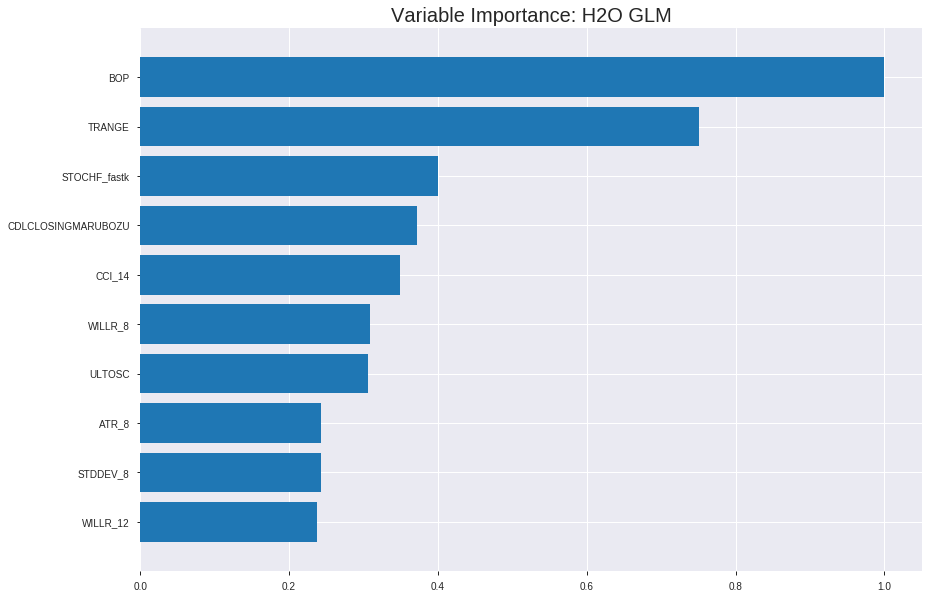

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_155813_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19995737818222578
RMSE: 0.44716594031995077
LogLoss: 0.5838219895752893
Null degrees of freedom: 1752
Residual degrees of freedom: 1661
Null deviance: 2429.7581400712443
Residual deviance: 2046.8798954509643
AIC: 2230.8798954509643
AUC: 0.7578391292460323
pr_auc: 0.7458595122106281
Gini: 0.5156782584920645
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.362739916708352: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      358  505   0.5852   (505.0/863.0)
1      86   804   0.0966   (86.0/890.0)
Total  444  1309  0.3371   (591.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36274      0.731241  276
max f2                       0.229561     0.850857  342
max f0point5                 0.545717     0.696542  176
max accuracy                 0.508352     0.692527  198
max precision                0.91535      1         0
max recall                   0.0929305    1         390
max specificity              0.91535      1         0
max absolute_mcc             0.508352     0.384814  198
max min_per_class_accuracy   0.521074     0.689888  191
max mean_per_class_accuracy  0.508352     0.692182  198

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.865908           1.75081   1.75081            0.888889         0.885975  0.888889                    0.885975            0.0179775       0.0179775                  75.0811   75.0811
    2        0.0205362                   0.845283           1.96966   1.86024            1                0.857945  0.944444                    0.87196             0.0202247       0.0382022                  96.9663   86.0237
    3        0.0302339                   0.832684           1.73794   1.82101            0.882353         0.839899  0.924528                    0.861676            0.0168539       0.0550562                  73.7938   82.1009
    4        0.040502                    0.817548           1.86024   1.83095            0.944444         0.824338  0.929577                    0.85221             0.0191011       0.0741573                  86.0237   83.0954
    5        0.0501997                   0.810461           1.50621   1.76822            0.764706         0.81441   0.897727                    0.844908            0.0146067       0.088764                   50.6213   76.822
    6        0.100399                    0.763646           1.70107   1.73465            0.863636         0.78412   0.880682                    0.814514            0.0853933       0.174157                   70.1073   73.4646
    7        0.150029                    0.727755           1.42631   1.63265            0.724138         0.744475  0.828897                    0.791345            0.0707865       0.244944                   42.6308   63.2648
    8        0.200228                    0.694928           1.36533   1.56563            0.693182         0.710898  0.794872                    0.771176            0.0685393       0.313483                   36.5335   56.563
    9        0.300057                    0.63393            1.36188   1.49784            0.691429         0.665182  0.760456                    0.735912            0.135955        0.449438                   36.1881   49.7843
    10       0.399886                    0.575574           1.21556   1.42737            0.617143         0.604445  0.724679                    0.703092            0.121348        0.570787                   21.5563   42.7373
    11       0.500285                    0.521182           1.16389   1.3745             0.590909         0.548112  0.697834                    0.67199             0.116854        0.68764                    16.3892   37.4497
    12       0.600114                    0.465821           0.945438  1.30312            0.48             0.492427  0.661597                    0.64212             0.094382        0.782022                   -5.45618  30.3123
    13       0.699943                    0.393161           0.821631  1.23445            0.417143         0.428704  0.626732                    0.611681            0.0820225       0.864045                   -17.8369  23.4451
    14       0.799772                    0.326507           0.7541    1.17449            0.382857         0.360627  0.596291                    0.580344            0.0752809       0.939326                   -24.59    17.4492
    15       0.899601                    0.228295           0.427698  1.09162            0.217143         0.278629  0.554217                    0.546863            0.0426966       0.982022                   -57.2302  9.16204
    16       1                           0.0306077          0.17906   1                  0.0909091        0.156802  0.507701                    0.507701           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2143193526084721
RMSE: 0.4629463820017088
LogLoss: 0.6150143543721548
Null degrees of freedom: 500
Residual degrees of freedom: 409
Null deviance: 693.327648451823
Residual deviance: 616.2443830808991
AIC: 800.2443830808991
AUC: 0.713138967377344
pr_auc: 0.7293896645520495
Gini: 0.4262779347546879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2559144058242163: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   172  0.7511   (172.0/229.0)
1      9    263  0.0331   (9.0/272.0)
Total  66   435  0.3613   (181.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255914     0.743989  340
max f2                       0.216538     0.872244  357
max f0point5                 0.514114     0.695312  193
max accuracy                 0.514114     0.664671  193
max precision                0.891008     1         0
max recall                   0.116497     1         389
max specificity              0.891008     1         0
max absolute_mcc             0.355795     0.334141  294
max min_per_class_accuracy   0.512129     0.659389  196
max mean_per_class_accuracy  0.514114     0.665634  193

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.839018           1.53493   1.53493            0.833333         0.853914  0.833333                    0.853914            0.0183824       0.0183824                  53.4926    53.4926
    2        0.0219561                   0.82825            1.84191   1.67447            1                0.832761  0.909091                    0.844299            0.0183824       0.0367647                  84.1912    67.4465
    3        0.0319361                   0.817397           1.84191   1.72679            1                0.82041   0.9375                      0.836834            0.0183824       0.0551471                  84.1912    72.6792
    4        0.0419162                   0.804629           1.47353   1.66649            0.8              0.807643  0.904762                    0.829883            0.0147059       0.0698529                  47.3529    66.6492
    5        0.0518962                   0.794634           1.47353   1.62938            0.8              0.79628   0.884615                    0.823421            0.0147059       0.0845588                  47.3529    62.9383
    6        0.101796                    0.749575           1.54721   1.5891             0.84             0.775187  0.862745                    0.799777            0.0772059       0.161765                   54.7206    58.91
    7        0.151697                    0.711435           1.2525    1.47838            0.68             0.728725  0.802632                    0.776405            0.0625          0.224265                   25.25      47.8377
    8        0.201597                    0.692509           1.17882   1.40423            0.64             0.701399  0.762376                    0.757839            0.0588235       0.283088                   17.8824    40.423
    9        0.301397                    0.633786           1.32618   1.37838            0.72             0.660965  0.748344                    0.725761            0.132353        0.415441                   32.6176    37.8384
    10       0.401198                    0.559343           1.06831   1.30125            0.58             0.593545  0.706468                    0.692872            0.106618        0.522059                   6.83088    30.1251
    11       0.500998                    0.514192           1.28934   1.29888            0.7              0.538248  0.705179                    0.66207             0.128676        0.650735                   28.9338    29.8878
    12       0.600798                    0.466102           0.810441  1.21774            0.44             0.490917  0.66113                     0.633639            0.0808824       0.731618                   -18.9559   21.7742
    13       0.700599                    0.399972           0.994632  1.18596            0.54             0.429751  0.643875                    0.604596            0.0992647       0.830882                   -0.536765  18.596
    14       0.800399                    0.321965           0.773603  1.13454            0.42             0.360971  0.61596                     0.574218            0.0772059       0.908088                   -22.6397   13.4544
    15       0.9002                      0.219009           0.773603  1.09453            0.42             0.270482  0.594235                    0.540545            0.0772059       0.985294                   -22.6397   9.45285
    16       1                           0.0551747          0.147353  1                  0.08             0.159944  0.542914                    0.50


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:58:14  0.000 sec   2            19        92            1.37087           1.37169
    2019-08-25 15:58:14  0.023 sec   4            12        92            1.36336           1.36577
    2019-08-25 15:58:14  0.046 sec   6            7.2       92            1.35297           1.35764
    2019-08-25 15:58:14  0.070 sec   8            4.4       92            1.33924           1.34693
    2019-08-25 15:58:14  0.093 sec   10           2.8       92            1.32208           1.33359
    2019-08-25 15:58:14  0.116 sec   12           1.7       92            1.30198           1.31803
    2019-08-25 15:58:14  0.140 sec   14           1.1       92            1.28005           1.30125
    2019-08-25 15:58:14  0.165 sec   16           0.66      92            1.25781           1.28454
    2019-08-25 15:58:14  0.188 sec   18           0.41      92            1.23667           1.26915
    2019-08-25 15:58:14  0.211 sec   20           0.26      92            1.21769           1.25597
    2019-08-25 15:58:14  0.235 sec   22           0.16      92            1.20136           1.24543
    2019-08-25 15:58:14  0.258 sec   24           0.098     92            1.18777           1.2376
    2019-08-25 15:58:14  0.289 sec   26           0.061     92            1.17666           1.23247
    2019-08-25 15:58:14  0.317 sec   28           0.038     92            1.16764           1.23003
    2019-08-25 15:58:14  0.342 sec   30           0.024     92            1.16029           1.23036
    2019-08-25 15:58:14  0.367 sec   32           0.015     92            1.15422           1.23372
    2019-08-25 15:58:14  0.391 sec   34           0.0091    92            1.14928           1.24012
    2019-08-25 15:58:14  0.414 sec   36           0.0056    92            1.14525           1.24754
    2019-08-25 15:58:14  0.439 sec   38           0.0035    92            1.14207           1.2562

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7272727272727273)

('auc', 0.7267641449459632)

('logloss', 0.603329093893464)

('mean_per_class_error', 0.29945963127781305)

('rmse', 0.45732857534234417)

('mse', 0.20914942582465815)

glm prediction progress: |████████████████████████████████████████████████| 100%


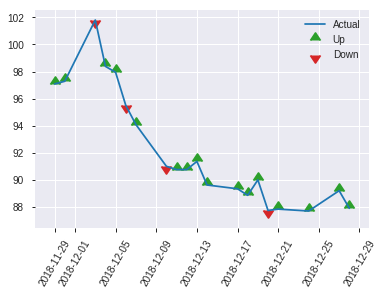


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20914942582465815
RMSE: 0.45732857534234417
LogLoss: 0.603329093893464
Null degrees of freedom: 250
Residual degrees of freedom: 159
Null deviance: 348.2966965690315
Residual deviance: 302.87120513451896
AIC: 486.87120513451896
AUC: 0.7267641449459632
pr_auc: 0.6350588674515312
Gini: 0.4535282898919264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3337148860501482: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   68   0.5231   (68.0/130.0)
1      13   108  0.1074   (13.0/121.0)
Total  75   176  0.3227   (81.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333715     0.727273  175
max f2                       0.231974     0.85592   216
max f0point5                 0.448743     0.67701   146
max accuracy                 0.448743     0.697211  146
max precision                0.805931     0.75      7
max recall                   0.184277     1         229
max specificity              0.853472     0.992308  0
max absolute_mcc             0.448743     0.406837  146
max min_per_class_accuracy   0.49214      0.676923  123
max mean_per_class_accuracy  0.448743     0.70054   146

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 47.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.831212           1.38292    1.38292            0.666667         0.840252  0.666667                    0.840252            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.818848           1.38292    1.38292            0.666667         0.825662  0.666667                    0.832957            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.805009           2.07438    1.55579            1                0.807034  0.75                        0.826477            0.0165289       0.0495868                  107.438    55.5785
    4        0.0438247                   0.795438           0.69146    1.32006            0.333333         0.799222  0.636364                    0.819043            0.00826446      0.0578512                  -30.854    32.006
    5        0.0517928                   0.756931           1.03719    1.27654            0.5              0.775432  0.615385                    0.812334            0.00826446      0.0661157                  3.71901    27.6542
    6        0.103586                    0.716649           1.11697    1.19676            0.538462         0.733219  0.576923                    0.772777            0.0578512       0.123967                   11.6974    19.6758
    7        0.151394                    0.683293           1.38292    1.25555            0.666667         0.700754  0.605263                    0.750033            0.0661157       0.190083                   38.292     25.5546
    8        0.203187                    0.65478            1.59568    1.34225            0.769231         0.669101  0.647059                    0.729403            0.0826446       0.272727                   59.5677    34.2246
    9        0.302789                    0.613419           1.49355    1.39202            0.72             0.631665  0.671053                    0.697252            0.14876         0.421488                   49.3554    39.2018
    10       0.40239                     0.557135           1.3276     1.37607            0.64             0.58609   0.663366                    0.669737            0.132231        0.553719                   32.7603    37.6074
    11       0.501992                    0.486143           1.3276     1.36646            0.64             0.519123  0.65873                     0.639853            0.132231        0.68595                    32.7603    36.6457
    12       0.601594                    0.43178            1.07868    1.31881            0.52             0.466299  0.635762                    0.611119            0.107438        0.793388                   7.86777    31.8811
    13       0.701195                    0.333715           0.995702   1.27292            0.48             0.380641  0.613636                    0.578381            0.0991736       0.892562                   -0.429752  27.2915
    14       0.800797                    0.275403           0.580826   1.18683            0.28             0.297418  0.572139                    0.543435            0.0578512       0.950413                   -41.9174   18.6834
    15       0.900398                    0.195909           0.414876   1.10144            0.2              0.2391    0.530973                    0.50977             0.0413223       0.991736                   -58.5124   10.1441
    16       1                           0.0383768          0.0829752  1                  0.04             0.13059   0.482072     

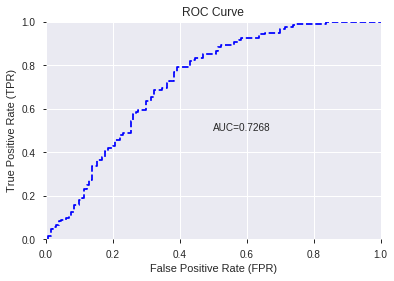

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


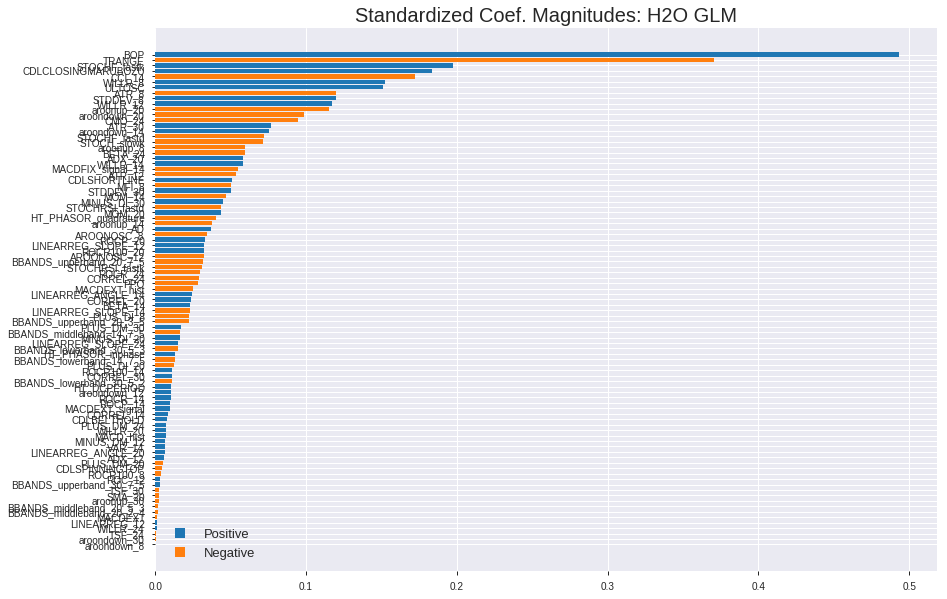

'log_likelihood'
--2019-08-25 15:58:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_155813_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_155813_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_14',
 'WILLR_8',
 'ULTOSC',
 'ATR_8',
 'STDDEV_8',
 'WILLR_12',
 'aroonup_20',
 'aroondown_20',
 'CMO_24',
 'ATR_30',
 'aroondown_14',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'BETA_24',
 'ADX_20',
 'WILLR_14',
 'MACDFIX_signal_14',
 'ATR_12',
 'CDLSHORTLINE',
 'MFI_8',
 'STDDEV_30',
 'MOM_14',
 'MINUS_DI_30',
 'STOCHRSI_fastd',
 'MOM_20',
 'HT_PHASOR_quadrature',
 'aroonup_14',
 'AD',
 'AROONOSC_8',
 'ROCP_20',
 'LINEARREG_SLOPE_12',
 'ROCR100_20',
 'AROONOSC_12',
 'BBANDS_upperband_20_7_5',
 'STOCHRSI_fastk',
 'ROCR_24',
 'CORREL_24',
 'PPO',
 'MACDEXT_hist',
 'LINEARREG_ANGLE_14',
 'CORREL_20',
 'BETA_14',
 'LINEARREG_SLOPE_14',
 'PLUS_DI_8',
 'BBANDS_upperband_20_3_5',
 'PLUS_DM_30',
 'BBANDS_middleband_14_7_5',
 'MINUS_DI_20',
 'LINEARREG_SLOPE_24',
 'BBANDS_lowerband_30_5_3',
 'HT_PHASOR_inphase',
 'BBANDS_lowerband_14_7_5',
 'PLUS_DI_20',
 'ROCR100_14',
 'CORREL_30',
 'BBANDS_lowerband_30_5_2',
 'HT_DCPERIOD

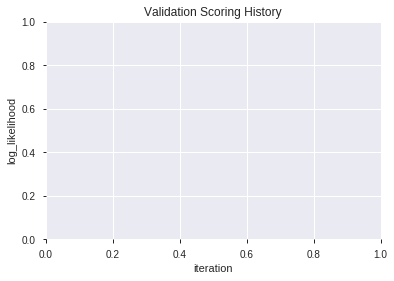

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_155825_model_4  0.731977  0.604622              0.320534  0.456463  0.208358
1               XGBoost_1_AutoML_20190825_155825  0.722695  0.613383              0.331214  0.460591  0.212144
2               XGBoost_3_AutoML_20190825_155825  0.720280  0.615937              0.286491  0.461338  0.212832
3  XGBoost_grid_1_AutoML_20190825_155825_model_2  0.718055  0.615859              0.302161  0.461194  0.212700
4               XGBoost_2_AutoML_20190825_155825  0.714749  0.620085              0.310426  0.463488  0.214821
5  XGBoost_grid_1_AutoML_20190825_155825_model_1  0.713414  0.625896              0.313414  0.464679  0.215927
6  XGBoost_grid_1_AutoML_20190825_155825_model_6  0.709282  0.621447              0.342181  0.464766  0.216007
7  XGBoost_grid_1_AutoML_20190825_155825_model_7  0.708074  0.624249              0.313414  0.465120  0.216336
8  XGBoost_grid_1_AutoML_20190825_155825_model_5  0.704514  0.644933              0.318118  0.471998  0.222782
9  XGBoost_grid_1_AutoML_20190825_155825_model_3  0.699619  0.633878              0.331786  0.469081  0.220037

variable  relative_importance  scaled_importance  percentage
0            BOP          2059.796875           1.000000    0.401827
1         TRANGE           606.046631           0.294226    0.118228
2        WILLR_8           178.597382           0.086706    0.034841
3   STOCHF_fastk           120.654266           0.058576    0.023537
4       STDDEV_8            76.482765           0.037131    0.014920
..           ...                  ...                ...         ...
68        VAR_14             6.701438           0.003253    0.001307
69        TSF_30             6.130985           0.002976    0.001196
70   aroondown_8             5.901999           0.002865    0.001151
71     MACD_hist             4.028691           0.001956    0.000786
72     CORREL_24             3.906551           0.001897    0.000762

[73 rows x 4 columns]

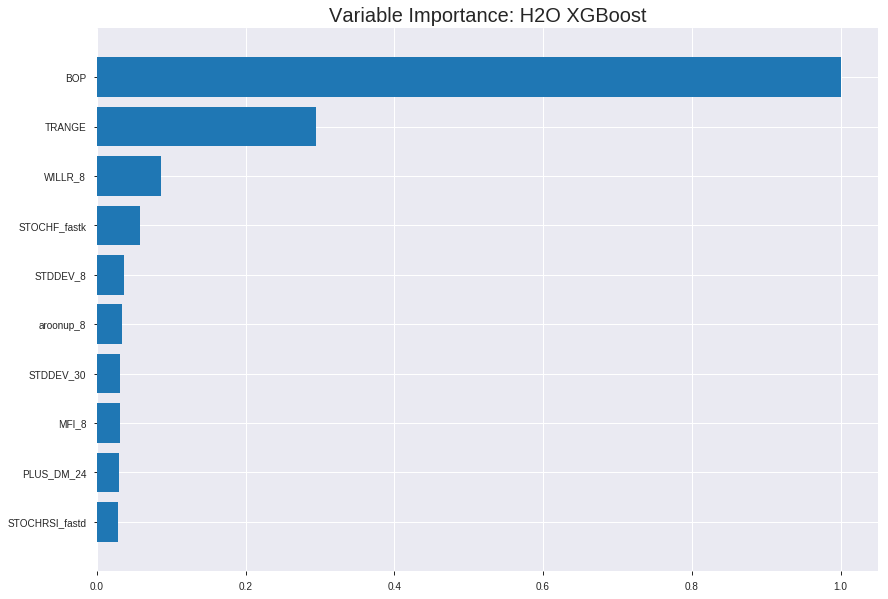

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_155825_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17863651339087275
RMSE: 0.4226541297454371
LogLoss: 0.5369928846859279
Mean Per-Class Error: 0.2478270209746507
AUC: 0.8250745374770528
pr_auc: 0.827130096491482
Gini: 0.6501490749541057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4315159976482391: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      482  381   0.4415   (381.0/863.0)
1      109  781   0.1225   (109.0/890.0)
Total  591  1162  0.2795   (490.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431516     0.761209  242
max f2                       0.207482     0.86217   347
max f0point5                 0.592365     0.77104   152
max accuracy                 0.553316     0.751854  175
max precision                0.869225     1         0
max recall                   0.121369     1         390
max specificity              0.869225     1         0
max absolute_mcc             0.568165     0.505766  166
max min_per_class_accuracy   0.539679     0.744944  181
max mean_per_class_accuracy  0.553316     0.752173  175

Gains/Lift Table: Avg response rate: 50.77 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.82958            1.96966    1.96966            1                0.846442  1                           0.846442            0.0202247       0.0202247                  96.9663   96.9663
    2        0.0205362                   0.819415           1.96966    1.96966            1                0.823953  1                           0.835198            0.0202247       0.0404494                  96.9663   96.9663
    3        0.0302339                   0.79861            1.8538     1.9325             0.941176         0.810777  0.981132                    0.827365            0.0179775       0.058427                   85.38     93.2499
    4        0.040502                    0.791632           1.96966    1.94192            1                0.795241  0.985915                    0.819221            0.0202247       0.0786517                  96.9663   94.1921
    5        0.0501997                   0.784791           1.8538     1.9249             0.941176         0.788803  0.977273                    0.813344            0.0179775       0.0966292                  85.38     92.4898
    6        0.100399                    0.742556           1.76822    1.84656            0.897727         0.760496  0.9375                      0.78692             0.088764        0.185393                   76.822    84.6559
    7        0.150029                    0.717797           1.69799    1.79741            0.862069         0.730922  0.912548                    0.768396            0.0842697       0.269663                   69.7985   79.7411
    8        0.200228                    0.694609           1.70107    1.77326            0.863636         0.706766  0.900285                    0.752945            0.0853933       0.355056                   70.1073   77.3258
    9        0.300057                    0.645165           1.45192    1.66635            0.737143         0.669821  0.846008                    0.725289            0.144944        0.5                        45.1923   66.635
    10       0.399886                    0.601026           1.31686    1.5791             0.668571         0.624071  0.801712                    0.700021            0.131461        0.631461                   31.686    57.9102
    11       0.500285                    0.541406           1.10794    1.48455            0.5625           0.571799  0.753706                    0.674289            0.111236        0.742697                   10.7935   48.4546
    12       0.600114                    0.479968           0.855396   1.37989            0.434286         0.51051   0.70057                     0.647044            0.0853933       0.82809                    -14.4604  37.9887
    13       0.699943                    0.402805           0.731589   1.28742            0.371429         0.441598  0.653627                    0.617743            0.0730337       0.901124                   -26.8411  28.7424
    14       0.799772                    0.299925           0.551506   1.19557            0.28             0.350455  0.60699                     0.584379            0.0550562       0.95618                    -44.8494  19.5566
    15       0.899601                    0.196548           0.348912   1.10161            0.177143         0.246416  0.55929                     0.546875            0.0348315       0.991011                   -65.1088  10.1612
    16       1                           0.0927561          0.0895301  1                  0.0454545        0.149232  0.507701                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20915495698515965
RMSE: 0.45733462255241475
LogLoss: 0.6047700700122108
Mean Per-Class Error: 0.32918860775751346
AUC: 0.7265364115078345
pr_auc: 0.751562313594882
Gini: 0.4530728230156691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3380621671676636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   155  0.6769   (155.0/229.0)
1      21   251  0.0772   (21.0/272.0)
Total  95   406  0.3513   (176.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338062     0.740413  312
max f2                       0.207153     0.868863  360
max f0point5                 0.594324     0.702586  160
max accuracy                 0.442144     0.668663  271
max precision                0.848975     1         0
max recall                   0.118649     1         398
max specificity              0.848975     1         0
max absolute_mcc             0.594324     0.342587  160
max min_per_class_accuracy   0.556342     0.661765  187
max mean_per_class_accuracy  0.594324     0.670811  160

Gains/Lift Table: Avg response rate: 54.29 %, avg score: 52.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.827026           1.84191   1.84191            1                0.839449  1                           0.839449            0.0220588       0.0220588                  84.1912   84.1912
    2        0.0219561                   0.802527           1.47353   1.67447            0.8              0.81034   0.909091                    0.826218            0.0147059       0.0367647                  47.3529   67.4465
    3        0.0319361                   0.790782           1.84191   1.72679            1                0.794277  0.9375                      0.816236            0.0183824       0.0551471                  84.1912   72.6792
    4        0.0419162                   0.785286           1.84191   1.7542             1                0.787355  0.952381                    0.80936             0.0183824       0.0735294                  84.1912   75.4202
    5        0.0518962                   0.781474           1.47353   1.70023            0.8              0.784035  0.923077                    0.80449             0.0147059       0.0882353                  47.3529   70.0226
    6        0.101796                    0.746575           1.54721   1.62522            0.84             0.763259  0.882353                    0.784278            0.0772059       0.165441                   54.7206   62.5216
    7        0.151697                    0.717027           1.32618   1.52685            0.72             0.730077  0.828947                    0.766449            0.0661765       0.231618                   32.6176   52.6848
    8        0.201597                    0.698573           1.32618   1.47718            0.72             0.707234  0.80198                     0.751792            0.0661765       0.297794                   32.6176   47.7177
    9        0.301397                    0.660503           1.32618   1.42718            0.72             0.67767   0.774834                    0.727248            0.132353        0.430147                   32.6176   42.7177
    10       0.401198                    0.619584           1.10515   1.34707            0.6              0.641109  0.731343                    0.70582             0.110294        0.540441                   10.5147   34.707
    11       0.500998                    0.560131           1.10515   1.29888            0.6              0.588584  0.705179                    0.682466            0.110294        0.650735                   10.5147   29.8878
    12       0.600798                    0.497551           0.847279  1.22386            0.46             0.527677  0.664452                    0.656754            0.0845588       0.735294                   -15.2721  22.3862
    13       0.700599                    0.45704            0.957794  1.18596            0.52             0.47834   0.643875                    0.631339            0.0955882       0.830882                   -4.22059  18.596
    14       0.800399                    0.3522             0.847279  1.14373            0.46             0.405758  0.620948                    0.603212            0.0845588       0.915441                   -15.2721  14.3731
    15       0.9002                      0.229082           0.589412  1.08228            0.32             0.282681  0.587583                    0.567676            0.0588235       0.974265                   -41.0588  8.22763
    16       1                           0.0951275          0.257868  1                  0.14             0.167974  0.542914                    0.527786           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:58:33  2.885 sec   0                  0.5              0.693147            0.5             0                  1                0.492299                         0.5                0.693147              0.5               0                    1                  0.457086
    2019-08-25 15:58:33  2.962 sec   5                  0.480437         0.654578            0.775311        0.772387           1.96966          0.325727                         0.485321           0.664082              0.720693          0.717632             0.920956           0.361277
    2019-08-25 15:58:33  3.017 sec   10                 0.466675         0.627638            0.781146        0.781587           1.96966          0.310896                         0.47533            0.644285              0.719151          0.737623             1.84191            0.329341
    2019-08-25 15:58:33  3.072 sec   15                 0.45693          0.60826             0.787269        0.790452           1.96966          0.302339                         0.468676           0.630836              0.724184          0.733493             1.53493            0.329341
    2019-08-25 15:58:33  3.128 sec   20                 0.450101         0.594407            0.79262         0.794578           1.86024          0.308043                         0.464804           0.622715              0.725212          0.74176              1.84191            0.327345
    2019-08-25 15:58:33  3.188 sec   25                 0.444618         0.583163            0.797417        0.801425           1.96966          0.308614                         0.462258           0.61729               0.727644          0.748845             1.84191            0.331337
    2019-08-25 15:58:33  3.255 sec   30                 0.439649         0.572832            0.802336        0.805413           1.96966          0.295493                         0.460655           0.613601              0.725902          0.745188             1.84191            0.339321
    2019-08-25 15:58:33  3.312 sec   35                 0.436218         0.565394            0.806149        0.811617           1.96966          0.295493                         0.459508           0.610832              0.727098          0.747267             1.84191            0.335329
    2019-08-25 15:58:33  3.376 sec   40                 0.432662         0.558046            0.812125        0.814555           1.96966          0.286937                         0.458708           0.608761              0.726496          0.747352             1.84191            0.329341
    2019-08-25 15:58:33  3.436 sec   45                 0.430104         0.552433            0.813775        0.815482           1.96966          0.282944                         0.457576           0.606012              0.726665          0.7466               1.84191            0.327345
    2019-08-25 15:58:33  3.503 sec   50                 0.427735         0.547505            0.817347        0.820204           1.96966          0.268112                         0.457217           0.604975              0.726866          0.749629             1.84191            0.325349
    2019-08-25 15:58:33  3.575 sec   55                 0.42531          0.54221             0.819225        0.821368           1.96966          0.269253                         0.457235           0.60462               0.726199          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2059.796875            1.0                    0.4018268524184993
TRANGE        606.046630859375       0.2942264056301061     0.11822807047275416
WILLR_8       178.59738159179688     0.08670630767502105    0.03484092269788368
STOCHF_fastk  120.65426635742188     0.058575808042927474   0.02353733257375976
STDDEV_8      76.4827651977539       0.03713121722148156    0.014920320142575511
---           ---                    ---                    ---
VAR_14        6.7014384269714355     0.003253446254000864   0.0013073220677579244
TSF_30        6.130985260009766      0.002976499932795444   0.0011960375992190679
aroondown_8   5.901998519897461      0.0028653303592848013  0.0011513666794105795
MACD_hist     4.028691291809082      0.001955868241527011   0.0007859203792381039
CORREL_24     3.9065513610839844     0.0018965711660689768  0.0007620932220491799


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6892430278884463)

('F1', 0.7152777777777777)

('auc', 0.7319771137952956)

('logloss', 0.604621968748616)

('mean_per_class_error', 0.3077240940877305)

('rmse', 0.4564625166895439)

('mse', 0.20835802914255216)

xgboost prediction progress: |████████████████████████████████████████████| 100%


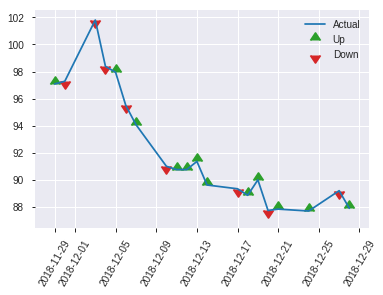


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20835802914255216
RMSE: 0.4564625166895439
LogLoss: 0.604621968748616
Mean Per-Class Error: 0.3077240940877305
AUC: 0.7319771137952956
pr_auc: 0.6666834024899425
Gini: 0.46395422759059124
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3859330713748932: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   64   0.4923   (64.0/130.0)
1      18   103  0.1488   (18.0/121.0)
Total  84   167  0.3267   (82.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385933     0.715278  166
max f2                       0.175854     0.838028  225
max f0point5                 0.544984     0.678392  118
max accuracy                 0.544984     0.689243  118
max precision                0.820289     1         0
max recall                   0.136977     1         238
max specificity              0.820289     1         0
max absolute_mcc             0.474196     0.389029  144
max min_per_class_accuracy   0.540756     0.677686  120
max mean_per_class_accuracy  0.474196     0.692276  144

Gains/Lift Table: Avg response rate: 48.21 %, avg score: 48.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.802713           1.38292   1.38292            0.666667         0.811535  0.666667                    0.811535            0.0165289       0.0165289                  38.292     38.292
    2        0.0239044                   0.787668           1.38292   1.38292            0.666667         0.793308  0.666667                    0.802421            0.0165289       0.0330579                  38.292     38.292
    3        0.0318725                   0.770108           2.07438   1.55579            1                0.770277  0.75                        0.794385            0.0165289       0.0495868                  107.438    55.5785
    4        0.0438247                   0.760207           1.38292   1.50864            0.666667         0.765488  0.727273                    0.786504            0.0165289       0.0661157                  38.292     50.864
    5        0.0517928                   0.75745            1.03719   1.43611            0.5              0.758394  0.692308                    0.782179            0.00826446      0.0743802                  3.71901    43.6109
    6        0.103586                    0.735539           1.59568   1.51589            0.769231         0.748469  0.730769                    0.765324            0.0826446       0.157025                   59.5677    51.5893
    7        0.151394                    0.711296           1.55579   1.52849            0.75             0.721011  0.736842                    0.751331            0.0743802       0.231405                   55.5785    52.8491
    8        0.203187                    0.68719            1.27654   1.46427            0.615385         0.700337  0.705882                    0.738332            0.0661157       0.297521                   27.6542    46.4268
    9        0.302789                    0.628909           1.41058   1.44661            0.68             0.660554  0.697368                    0.712747            0.140496        0.438017                   41.0579    44.6607
    10       0.40239                     0.578022           1.41058   1.43769            0.68             0.605303  0.693069                    0.686152            0.140496        0.578512                   41.0579    43.7689
    11       0.501992                    0.521466           0.995702  1.34999            0.48             0.553206  0.650794                    0.659774            0.0991736       0.677686                   -0.429752  34.9993
    12       0.601594                    0.461195           1.16165   1.31881            0.56             0.496963  0.635762                    0.632818            0.115702        0.793388                   16.1653    31.8811
    13       0.701195                    0.329472           0.746777  1.23756            0.36             0.39833   0.596591                    0.59951             0.0743802       0.867769                   -25.3223   23.7556
    14       0.800797                    0.250172           0.414876  1.13523            0.2              0.288381  0.547264                    0.560813            0.0413223       0.909091                   -58.5124   13.5233
    15       0.900398                    0.175854           0.746777  1.09226            0.36             0.213614  0.526549                    0.522406            0.0743802       0.983471                   -25.3223   9.22621
    16       1                           0.103057           0.16595   1                  0.08             0.142396  0.482072                    0.4

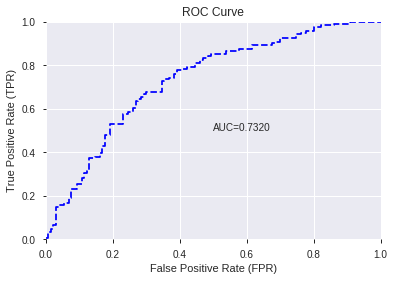

This function is available for GLM models only


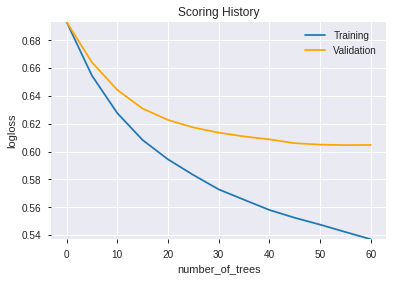

--2019-08-25 15:58:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_155825_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_155825_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_be19',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'WILLR_8',
 'STOCHF_fastk',
 'STDDEV_8',
 'aroonup_8',
 'STDDEV_30',
 'MFI_8',
 'PLUS_DM_24',
 'STOCHRSI_fastd',
 'PLUS_DI_8',
 'CORREL_20',
 'PLUS_DI_20',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'CMO_24',
 'HT_DCPERIOD',
 'aroondown_14',
 'ULTOSC',
 'ADX_20',
 'MINUS_DI_20',
 'CDLCLOSINGMARUBOZU',
 'ADX_12',
 'CORREL_14',
 'HT_PHASOR_quadrature',
 'CORREL_30',
 'LINEARREG_ANGLE_14',
 'MINUS_DM_12',
 'LINEARREG_SLOPE_24',
 'BETA_24',
 'BETA_14',
 'aroonup_14',
 'BBANDS_upperband_30_7_5',
 'MACDFIX_signal_14',
 'ATR_30',
 'ROCR100_8',
 'PLUS_DM_30',
 'ATR_8',
 'PLUS_DM_20',
 'STOCH_slowk',
 'MACDEXT',
 'aroonup_30',
 'BBANDS_lowerband_30_5_3',
 'aroonup_20',
 'BBANDS_lowerband_14_7_5',
 'LINEARREG_SLOPE_12',
 'AROONOSC_12',
 'HT_PHASOR_inphase',
 'MOM_20',
 'aroondown_12',
 'aroondown_30',
 'PPO',
 'BBANDS_upperband_20_3_5',
 'MOM_14',
 'MINUS_DI_30',
 'BBANDS_lowerband_30_5_2',
 'SMA_20',
 'ATR_12',
 'ROCP_20',
 'ROC_12',
 'WILLR_12',
 'aroondown_20',
 'BBANDS_upperband_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.717
GLM             0.697
XGBoost         0.725
dtype: float64

DeepLearning    GLM  XGBoost
All          0.685  0.693    0.725
DLF          0.677  0.693    0.693
Fwe          0.681  0.693    0.689
RFE          0.717  0.697    0.689
XGBF         0.669  0.693    0.689





F1


DeepLearning    0.741
GLM             0.735
XGBoost         0.736
dtype: float64

DeepLearning    GLM  XGBoost
All          0.727  0.724    0.736
DLF          0.724  0.735    0.722
Fwe          0.722  0.733    0.709
RFE          0.741  0.727    0.715
XGBF         0.720  0.735    0.719





auc


DeepLearning    0.752
GLM             0.727
XGBoost         0.732
dtype: float64

DeepLearning    GLM  XGBoost
All          0.707  0.696    0.728
DLF          0.708  0.708    0.713
Fwe          0.708  0.722    0.721
RFE          0.752  0.727    0.732
XGBF         0.712  0.708    0.709





logloss


DeepLearning    0.714
GLM             0.634
XGBoost         0.623
dtype: float64

DeepLearning    GLM  XGBoost
All          0.714  0.634    0.623
DLF          0.600  0.613    0.616
Fwe          0.620  0.613    0.614
RFE          0.599  0.603    0.605
XGBF         0.623  0.613    0.617





mean_per_class_error


DeepLearning    0.324
GLM             0.302
XGBoost         0.309
dtype: float64

DeepLearning    GLM  XGBoost
All          0.308  0.302    0.275
DLF          0.318  0.300    0.302
Fwe          0.313  0.302    0.309
RFE          0.280  0.299    0.308
XGBF         0.324  0.300    0.306





rmse


DeepLearning    0.480
GLM             0.469
XGBoost         0.463
dtype: float64

DeepLearning    GLM  XGBoost
All          0.480  0.469    0.461
DLF          0.458  0.462    0.462
Fwe          0.465  0.462    0.461
RFE          0.451  0.457    0.456
XGBF         0.466  0.462    0.463





mse


DeepLearning    0.230
GLM             0.220
XGBoost         0.214
dtype: float64

DeepLearning    GLM  XGBoost
All          0.230  0.220    0.213
DLF          0.210  0.213    0.214
Fwe          0.216  0.213    0.212
RFE          0.203  0.209    0.208
XGBF         0.217  0.213    0.214

{'F1':       DeepLearning    GLM  XGBoost
 All          0.727    NaN      NaN
 DLF          0.724    NaN      NaN
 DLF            NaN  0.735      NaN
 DLF            NaN    NaN    0.722
 All            NaN  0.724      NaN
 All            NaN    NaN    0.736
 XGBF         0.720    NaN      NaN
 XGBF           NaN  0.735      NaN
 XGBF           NaN    NaN    0.719
 Fwe          0.722    NaN      NaN
 Fwe            NaN  0.733      NaN
 Fwe            NaN    NaN    0.709
 RFE          0.741    NaN      NaN
 RFE            NaN  0.727      NaN
 RFE            NaN    NaN    0.715,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.685    NaN      NaN
 DLF          0.677    NaN      NaN
 DLF            NaN  0.693      NaN
 DLF            NaN    NaN    0.693
 All            NaN  0.693      NaN
 All            NaN    NaN    0.725
 XGBF         0.669    NaN      NaN
 XGBF           NaN  0.693      NaN
 XGBF           NaN    NaN    0.689
 Fwe          0.681    NaN      NaN
 Fwe     